In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

from tensorflow.keras.optimizers import Nadam
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow.keras.layers as KL
from datetime import timedelta
import numpy as np
import pandas as pd


import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge

import datetime
import gc
from tqdm import tqdm
from sklearn import preprocessing
from datetime import datetime

In [2]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
import keras.backend as K
import time

Using TensorFlow backend.


In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

#### Read Data

In [4]:
##Reading week 3 data
train = pd.read_csv("../input/covid19-global-forecasting-week-3/train.csv")
test = pd.read_csv("../input/covid19-global-forecasting-week-3/test.csv")
###Read population data
populations = pd.read_csv('/kaggle/input/covid19-global-forecasting-locations-population/locations_population.csv').iloc[:, :3]
populations.columns = ['Province_State', 'Country_Region', 'Population']
### Read Latitude and longitude country wise
coo_df = pd.read_csv("../input/covid19week1/train.csv").rename(columns={"Country/Region": "Country_Region"})
coo_df = coo_df.groupby("Country_Region")[["Lat", "Long"]].mean().reset_index()
coo_df = coo_df[coo_df["Country_Region"].notnull()]
Unique_Regions = train['Country_Region'].unique()
loc_group = ["Province_State", "Country_Region"]
coo_df.head()

Country_Region      Lat     Long
0          Afghanistan  33.0000  65.0000
1              Albania  41.1533  20.1683
2              Algeria  28.0339   1.6596
3              Andorra  42.5063   1.5218
4  Antigua and Barbuda  17.0608 -61.7964

### Prepare feature(Days, weekend, Population), convert target to log transform, split into development and test set 

In [5]:
loc_group = 'Country_Region'
def preprocess(df):
    df["Date"] = df["Date"].astype("datetime64[ms]")
    df["days"] = (df["Date"] - pd.to_datetime("2020-01-01")).dt.days
    df["weekend"] = df["Date"].dt.dayofweek//5
    print(df.Country_Region.nunique())
    df = df.merge(coo_df, how="left", on="Country_Region")
    df["Lat"] = (df["Lat"] // 30).astype(np.float32).fillna(0)
    df["Long"] = (df["Long"] // 60).astype(np.float32).fillna(0)
    df = pd.merge(df,populations[['Country_Region','Province_State','Population']],how="left", on=["Country_Region", 'Province_State'] ) 
    df['Population'] = (df["Population"] / df.Population.max()).astype(np.float32).fillna(0)
    df['Province_State'].fillna("",inplace = True)
    df['Country_Region'] = df['Country_Region'] + ' ' + df['Province_State']
    print(df.Country_Region.nunique())
    del df['Province_State']
#     for col in loc_group:
#         df[col].fillna("none", inplace=True)
    return df
df_train = preprocess(train)
print(train.shape)
print(df_train.reset_index(drop=True).shape)
print('test')
df_test = preprocess(test)

TARGETS = ["ConfirmedCases", "Fatalities"]

#Log transform
# for col in TARGETS:
#     df_train[col] = np.log1p(df_train[col]) # expm1 inverse of log1p

NUM_SHIFT = 5

features = ["Lat", "Long","Population"]

##Prepare lag features
for s in range(1, NUM_SHIFT+1):
    for col in TARGETS:
        df_train["prev_{}_{}".format(col, s)] = df_train.groupby(loc_group)[col].shift(s)##lag values, loc_group = ["Province_State", "Country_Region"]
        features.append("prev_{}_{}".format(col, s))

#sum_cases = train.groupby('Country_Region')['ConfirmedCases'].count().reset_index().merge(populations[['Country_Region','Population']], on='Country_Region', how='left')
#sum_cases['percentage'] = sum_cases

###Split train data into devlopment and validation set
TEST_FIRST = df_test["Date"].min() # pd.to_datetime("2020-03-13") #
TEST_DAYS = (df_test["Date"].max() - TEST_FIRST).days + 1

dev_df, test_df = df_train[df_train["Date"] < TEST_FIRST].copy(), df_train[df_train["Date"] >= TEST_FIRST].copy()

180
306
(23562, 8)
(23562, 10)
test
180
306


In [6]:
Unique_Regions = df_train['Country_Region'].unique().tolist()

#### Normalize data(0 - 1) 

In [7]:
def labelEncoder(df):
    le = preprocessing.LabelEncoder()
    le.fit(Unique_Regions)
    df_transformed = le.transform(df)
    return df_transformed, le

In [8]:
dev_df['Country_label'], label_enc_dev = labelEncoder(dev_df['Country_Region'])
test_df['Country_label'], label_enc_test = labelEncoder(test_df['Country_Region'])
df_train['Country_label'], label_enc_train = labelEncoder(df_train['Country_Region'])
df_test['Country_label'], label_enc_test_1 = labelEncoder(df_test['Country_Region'])

In [9]:
features_confirmed = ['Country_label','Lat','Long','weekend','Population','prev_ConfirmedCases_1', 'prev_ConfirmedCases_2','prev_ConfirmedCases_3', 'prev_ConfirmedCases_4', 'prev_ConfirmedCases_5']
features_fatalities = ['Country_label','Lat','Long','weekend','Population','prev_Fatalities_1','prev_Fatalities_2','prev_Fatalities_3','prev_Fatalities_4','prev_Fatalities_5']
features.append('Country_label')
features.append('weekend')
# target_confirmed = ['ConfirmedCases']
# target_fatalities = ['Fatalities']

In [10]:
def scale_data(dev, val, dev_y, val_y):
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(dev)
    X_val =  scaler.transform(val) # intput/output 2D array-like
    
    y_scaler = MinMaxScaler()
    y_train = y_scaler.fit_transform(dev_y)
    y_val = y_scaler.transform(val_y) # array-like
    return X_train, X_val, y_train, y_val, scaler, y_scaler

In [ ]:
features_confirmed

In [ ]:
features_fatalities

In [11]:
dev_df = dev_df.fillna(0)
test_df = test_df.fillna(0)
X_train_cc = dev_df[features_confirmed].to_numpy()
X_val_cc = test_df[features_confirmed].to_numpy()
X_train_ft = dev_df[features_fatalities].to_numpy()
X_val_ft = test_df[features_fatalities].to_numpy()


y_train_cc = dev_df[['ConfirmedCases']].to_numpy()
y_val_cc = test_df[['ConfirmedCases']].to_numpy()
y_train_ft = dev_df[['Fatalities']].to_numpy()
y_val_ft = test_df[['Fatalities']].to_numpy()

X_train_cc, X_val_cc, y_train_cc, y_val_cc, scaler_cc, y_scaler_cc = scale_data(X_train_cc, X_val_cc, y_train_cc, y_val_cc)
X_train_ft, X_val_ft, y_train_ft, y_val_ft, scaler_ft, y_scaler_ft = scale_data(X_train_ft, X_val_ft, y_train_ft, y_val_ft)

### Convert into 3D input

In [12]:
X_train_cc = X_train_cc.reshape(X_train_cc.shape[0], 1, X_train_cc.shape[1])
X_val_cc = X_val_cc.reshape(X_val_cc.shape[0], 1, X_val_cc.shape[1])

X_train_ft = X_train_ft.reshape(X_train_ft.shape[0], 1, X_train_ft.shape[1])
X_val_ft = X_val_ft.reshape(X_val_ft.shape[0], 1, X_val_ft.shape[1])
print(X_train_cc.shape, X_val_cc.shape, X_train_ft.shape, X_val_ft.shape)

(19584, 1, 10) (3978, 1, 10) (19584, 1, 10) (3978, 1, 10)


In [13]:
def root_mean_squared_log_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(K.log(y_pred + 1) - K.log(y_true + 1))))

### Create LSTM Model 

In [29]:
def rmsle(Y, pred):
    return np.sqrt(mean_squared_log_error(Y[0], pred[:,0]))

In [31]:
def LSTM_model(n_1, input_dim, output_dim):
#def LSTM_model(X_train_c, y_train_c, X_val_c, y_val_c):
    model = Sequential()
    model.add(LSTM(n_1,input_shape=(1, input_dim)))#, activation='relu',return_sequences=True
    #model.add(LSTM(n_2, activation='relu'))
    model.add(Dense(output_dim, ))#activation='relu'
    #opt = SGD(lr=0.01, momentum=0.9, clipvalue=5.0)
    #adam = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='Nadam')#root_mean_squared_log_error
    model.summary()
    return model

# model_cc, history_cc = LSTM_model(X_train_cc, y_train_cc, X_val_cc, y_val_cc)
# model_ft, history_ft = LSTM_model(X_train_ft, y_train_ft, X_val_ft, y_val_ft)
K.clear_session()   
model_cc = LSTM_model(4, X_train_cc.shape[-1], y_train_cc.shape[-1])
early_stop_cc = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 240       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


Model for confirmed cases

In [32]:
print('Start model training')
start_time = time.time()
history_cc = model_cc.fit(X_train_cc, y_train_cc, batch_size = 2048, epochs = 100,validation_data = (X_val_cc, y_val_cc), verbose = 2, callbacks=[early_stop_cc])
model_cc.save("model_cc.h5")
print('Time spent for model training is {} minutes'.format(round((time.time()-start_time)/60,1)))


Start model training
Train on 19584 samples, validate on 3978 samples
Epoch 1/100
 - 1s - loss: 0.0040 - val_loss: 0.0349
Epoch 2/100
 - 0s - loss: 0.0033 - val_loss: 0.0331
Epoch 3/100
 - 0s - loss: 0.0029 - val_loss: 0.0317
Epoch 4/100
 - 0s - loss: 0.0025 - val_loss: 0.0304
Epoch 5/100
 - 0s - loss: 0.0023 - val_loss: 0.0291
Epoch 6/100
 - 0s - loss: 0.0021 - val_loss: 0.0279
Epoch 7/100
 - 0s - loss: 0.0019 - val_loss: 0.0267
Epoch 8/100
 - 0s - loss: 0.0018 - val_loss: 0.0256
Epoch 9/100
 - 0s - loss: 0.0017 - val_loss: 0.0246
Epoch 10/100
 - 0s - loss: 0.0016 - val_loss: 0.0236
Epoch 11/100
 - 0s - loss: 0.0015 - val_loss: 0.0226
Epoch 12/100
 - 0s - loss: 0.0014 - val_loss: 0.0215
Epoch 13/100
 - 0s - loss: 0.0013 - val_loss: 0.0204
Epoch 14/100
 - 0s - loss: 0.0012 - val_loss: 0.0191
Epoch 15/100
 - 0s - loss: 0.0011 - val_loss: 0.0176
Epoch 16/100
 - 0s - loss: 9.2734e-04 - val_loss: 0.0160
Epoch 17/100
 - 0s - loss: 7.9283e-04 - val_loss: 0.0143
Epoch 18/100
 - 0s - loss: 6.5

Model for fatalities

In [33]:
model_ft = LSTM_model(4, X_train_ft.shape[-1], y_train_ft.shape[-1])
early_stop_ft = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
# callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.6),
#              EarlyStopping(monitor='val_loss', patience=20),
#              ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
print('Start model training')
history_ft = model_ft.fit(X_train_ft, y_train_ft, batch_size = 1000, epochs = 100,validation_data = (X_val_ft, y_val_ft), verbose = 2, callbacks=[early_stop_ft])
# history_ft = model_ft.fit(X_train_ft,y_train_ft, epochs=100, batch_size=2048, validation_data=(X_val_ft, y_val_ft), verbose=2, 
#                shuffle=True,callbacks=callbacks)
model_ft.save("model_ft.h5")
print('Time spent for model training is {} minutes'.format(round((time.time()-start_time)/60,1)))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 240       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________
Start model training
Train on 19584 samples, validate on 3978 samples
Epoch 1/100
 - 1s - loss: 0.0012 - val_loss: 0.0144
Epoch 2/100
 - 0s - loss: 6.4278e-04 - val_loss: 0.0114
Epoch 3/100
 - 0s - loss: 3.8429e-04 - val_loss: 0.0091
Epoch 4/100
 - 0s - loss: 2.3554e-04 - val_loss: 0.0072
Epoch 5/100
 - 0s - loss: 1.4423e-04 - val_loss: 0.0056
Epoch 6/100
 - 0s - loss: 8.8520e-05 - val_loss: 0.0045
Epoch 7/100
 - 0s - loss: 6.1688e-05 - val_loss: 0.0038
Epoch 8/100
 - 0s - loss: 5.2748e-05 - val_loss: 0.0034
Epoc

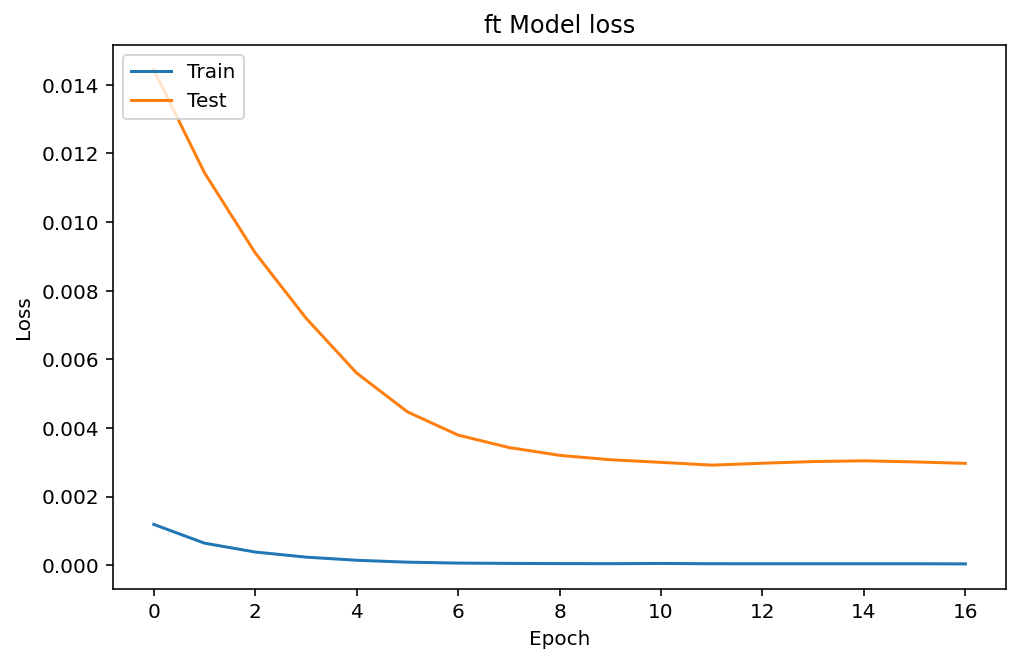

In [34]:
plt.figure(figsize=(8,5))
plt.plot(history_ft.history['loss'])
plt.plot(history_ft.history['val_loss'])
plt.title('ft Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

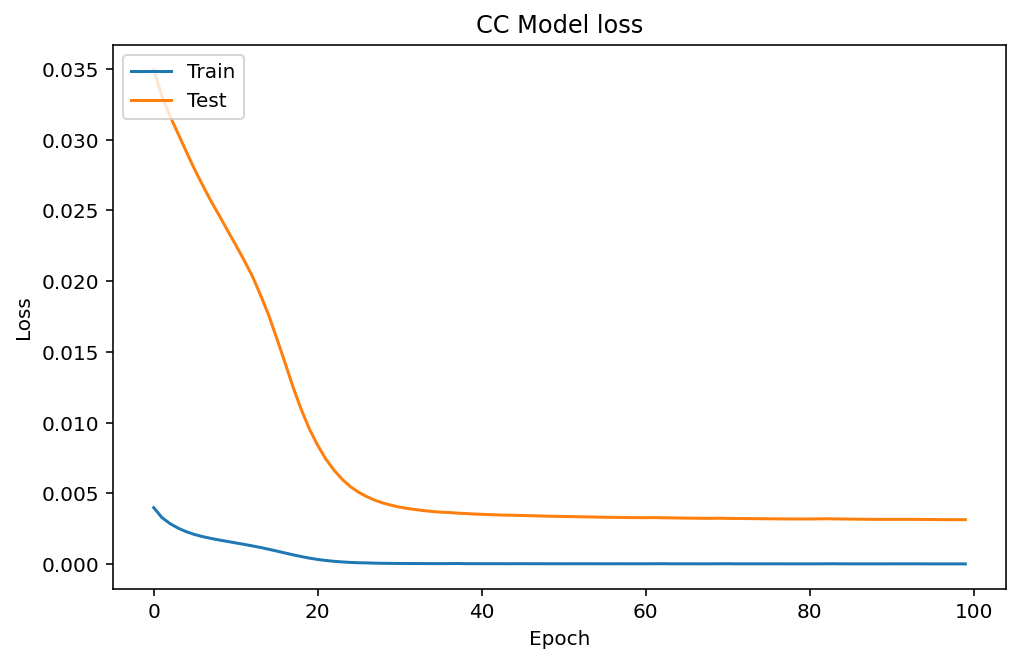

In [35]:
plt.figure(figsize=(8,5))
plt.plot(history_cc.history['loss'])
plt.plot(history_cc.history['val_loss'])
plt.title('CC Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [36]:
country = df_test['Country_Region'].unique().tolist()
adj_input_cols = [e for e in features if e not in ('Lat',
       'Long', 'Population','weekend','Country_label')]
# fill data for overlapped days
test_dff = df_test.copy().join(pd.DataFrame(columns = adj_input_cols + TARGETS))
test_dff['weekday'] = test_dff['Date'].dt.weekday
lags = np.arange(1,6,1)  # lag of 1 to 5
test_overlap_mask = (test_dff['Date'] <= train['Date'].max())
train_overlap_mask = (train['Date'] >= test_dff['Date'].min())

In [37]:
test_dff.loc[test_overlap_mask, features + TARGETS] = df_train.loc[train_overlap_mask, features + TARGETS].values
pred_dt_range = pd.date_range(start = df_train['Date'].max() + pd.Timedelta(days=1), end = test_dff['Date'].max(), freq = '1D')


#### Format below code 

In [ ]:
def prepare_test_set(test_dff, lag, mask):
    mask_org = (test_dff['Date'] == (d - pd.Timedelta(days=lag))) & (test_dff['Country_Region'] == i) 
    #print('maskorg',d - pd.Timedelta(days=lag))
    try:
        test_dff.loc[mask, 'prev_ConfirmedCases_' + str(lag)] = test_dff.loc[mask_org, 'ConfirmedCases'].values
    except:
        test_dff.loc[mask, 'prev_ConfirmedCases_' + str(lag)] = 0

    try:
        test_dff.loc[mask, 'prev_Fatalities_' + str(lag)] = test_dff.loc[mask_org, 'Fatalities'].values
    except:
        test_dff.loc[mask, 'prev_Fatalities_' + str(lag)] = 0
    return test_dff


In [ ]:
def predict_test(test_dff, mask, features, features_t, scaler_x, scaler_y, model):
    test_X  = test_dff.loc[mask, features]
    # predict for comfirmed cases
    test_X_cc = test_X[features_t]
    X_test_cc =  scaler_x.transform(test_X_cc) # intput/output 2D array-like
    X_test_cc = X_test_cc.reshape(X_test_cc.shape[0], 1, X_test_cc.shape[1])
    next_cc = model.predict(X_test_cc)
    next_cc_scaled = scaler_y.inverse_transform(next_cc)
    return next_cc_scaled

Break below code

In [39]:
with tqdm(total = len(pred_dt_range)) as pbar:
    for d in pred_dt_range:
        for i in country:
            mask = (test_dff['Date'] == d) & (test_dff['Country_Region'] == i) 
            #print(mask)
            for lag in lags:
                    mask_org = (test_dff['Date'] == (d - pd.Timedelta(days=lag))) & (test_dff['Country_Region'] == i) 
                    #print('maskorg',d - pd.Timedelta(days=lag))
                    try:
                        test_dff.loc[mask, 'prev_ConfirmedCases_' + str(lag)] = test_dff.loc[mask_org, 'ConfirmedCases'].values
                    except:
                        test_dff.loc[mask, 'prev_ConfirmedCases_' + str(lag)] = 0

                    try:
                        test_dff.loc[mask, 'prev_Fatalities_' + str(lag)] = test_dff.loc[mask_org, 'Fatalities'].values
                    except:
                        test_dff.loc[mask, 'prev_Fatalities_' + str(lag)] = 0
            #print(mask)
            #print(test_dff.loc[mask, features].head())     
            test_X  = test_dff.loc[mask, features]
            # predict for comfirmed cases
            test_X_cc = test_X[features_confirmed]
            X_test_cc =  scaler_cc.transform(test_X_cc) # intput/output 2D array-like
            X_test_cc = X_test_cc.reshape(X_test_cc.shape[0], 1, X_test_cc.shape[1])
            next_cc = model_cc.predict(X_test_cc).clip(0)
            next_cc_scaled = y_scaler_cc.inverse_transform(next_cc)


            # predict for fatal cases
            test_X_ft = test_X[features_fatalities]

            X_test_ft =  scaler_ft.transform(test_X_ft) # intput/output 2D array-like
            X_test_ft = X_test_ft.reshape(X_test_ft.shape[0], 1, X_test_ft.shape[1])
            next_ft = model_ft.predict(X_test_ft).clip(0)
            next_ft_scaled = y_scaler_ft.inverse_transform(next_ft)
            print(d, ' - ', i, ' - ',  ' - Predicted Confirmed Cases are ', next_cc_scaled, ' - Predicted Fatal Cases are ', next_ft_scaled)

            # update yhat for next day
            test_dff.loc[mask, 'ConfirmedCases'] = next_cc_scaled
            test_dff.loc[mask, 'Fatalities'] = next_ft_scaled

        pbar.update(1)
            

  0%|          | 0/30 [00:00<?, ?it/s]

2020-04-08 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[207.57658]]  - Predicted Fatal Cases are  [[0.]]
2020-04-08 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[142.11502]]  - Predicted Fatal Cases are  [[9.086542]]
2020-04-08 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[1156.094]]  - Predicted Fatal Cases are  [[148.05331]]
2020-04-08 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[312.17377]]  - Predicted Fatal Cases are  [[7.6075664]]
2020-04-08 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[10.942335]]
2020-04-08 00:00:00  -  Antigua and Barbuda   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[29.232645]]
2020-04-08 00:00:00  -  Argentina   -   - Predicted Confirmed Cases are  [[2155.508]]  - Predicted Fatal Cases are  [[127.30532]]
2020-04-08 00:00:00  -  Armenia   -   - Predicted Confirmed Cases are  [[678.21375]]  - Predicted Fatal 

2020-04-08 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[1502.0042]]  - Predicted Fatal Cases are  [[29.26769]]
2020-04-08 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[1085.6782]]  - Predicted Fatal Cases are  [[10.127272]]
2020-04-08 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67560.72]]  - Predicted Fatal Cases are  [[3942.4248]]
2020-04-08 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[1213.0067]]  - Predicted Fatal Cases are  [[11.20279]]
2020-04-08 00:00:00  -  China Inner Mongolia  -   - Predicted Confirmed Cases are  [[192.51181]]  - Predicted Fatal Cases are  [[7.973298]]
2020-04-08 00:00:00  -  China Jiangsu  -   - Predicted Confirmed Cases are  [[778.0745]]  - Predicted Fatal Cases are  [[7.702452]]
2020-04-08 00:00:00  -  China Jiangxi  -   - Predicted Confirmed Cases are  [[1133.9463]]  - Predicted Fatal Cases are  [[8.650251]]
2020-04-08 00:00:00  -  China Jilin  -   - Predicted Confirmed Cas

2020-04-08 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[132.76257]]  - Predicted Fatal Cases are  [[19.194675]]
2020-04-08 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[124.667656]]  - Predicted Fatal Cases are  [[12.347303]]
2020-04-08 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[12.748557]]
2020-04-08 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[24.488161]]  - Predicted Fatal Cases are  [[16.905148]]
2020-04-08 00:00:00  -  Haiti   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[13.119877]]
2020-04-08 00:00:00  -  Holy See   -   - Predicted Confirmed Cases are  [[89.649895]]  - Predicted Fatal Cases are  [[15.50227]]
2020-04-08 00:00:00  -  Honduras   -   - Predicted Confirmed Cases are  [[372.03882]]  - Predicted Fatal Cases are  [[37.067444]]
2020-04-08 00:00:00  -  Hungary   -   - Predicted Confirmed Cases are  [[940.59534]]  - Predicted Fatal C

2020-04-08 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[5444.091]]  - Predicted Fatal Cases are  [[122.26131]]
2020-04-08 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[16252.501]]  - Predicted Fatal Cases are  [[348.58084]]
2020-04-08 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[1872.4673]]  - Predicted Fatal Cases are  [[17.225527]]
2020-04-08 00:00:00  -  Romania   -   - Predicted Confirmed Cases are  [[5121.057]]  - Predicted Fatal Cases are  [[196.74986]]
2020-04-08 00:00:00  -  Russia   -   - Predicted Confirmed Cases are  [[8405.998]]  - Predicted Fatal Cases are  [[99.09446]]
2020-04-08 00:00:00  -  Rwanda   -   - Predicted Confirmed Cases are  [[114.29157]]  - Predicted Fatal Cases are  [[3.0673826]]
2020-04-08 00:00:00  -  Saint Kitts and Nevis   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[13.312947]]
2020-04-08 00:00:00  -  Saint Lucia   -   - Predicted Confirmed Cases are  [[103.050354]]  - Predi

2020-04-08 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases are  [[782.63025]]  - Predicted Fatal Cases are  [[29.096838]]
2020-04-08 00:00:00  -  US New York  -   - Predicted Confirmed Cases are  [[73480.88]]  - Predicted Fatal Cases are  [[4785.0635]]
2020-04-08 00:00:00  -  US North Carolina  -   - Predicted Confirmed Cases are  [[3338.0474]]  - Predicted Fatal Cases are  [[57.14084]]
2020-04-08 00:00:00  -  US North Dakota  -   - Predicted Confirmed Cases are  [[240.4329]]  - Predicted Fatal Cases are  [[19.773434]]
2020-04-08 00:00:00  -  US Ohio  -   - Predicted Confirmed Cases are  [[5137.4253]]  - Predicted Fatal Cases are  [[148.41835]]
2020-04-08 00:00:00  -  US Oklahoma  -   - Predicted Confirmed Cases are  [[1473.7113]]  - Predicted Fatal Cases are  [[68.649666]]
2020-04-08 00:00:00  -  US Oregon  -   - Predicted Confirmed Cases are  [[1172.1191]]  - Predicted Fatal Cases are  [[45.132107]]
2020-04-08 00:00:00  -  US Pennsylvania  -   - Predicted Confirmed Cases 

  3%|▎         | 1/30 [00:21<10:36, 21.96s/it]

2020-04-08 00:00:00  -  Zambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-08 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[11.28799]]
2020-04-09 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[189.05515]]  - Predicted Fatal Cases are  [[0.]]
2020-04-09 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[102.379745]]  - Predicted Fatal Cases are  [[10.112604]]
2020-04-09 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[1148.9534]]  - Predicted Fatal Cases are  [[169.85909]]
2020-04-09 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[281.03775]]  - Predicted Fatal Cases are  [[9.086101]]
2020-04-09 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[11.121218]]
2020-04-09 00:00:00  -  Antigua and Barbuda   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[30.45585

2020-04-09 00:00:00  -  China Hainan  -   - Predicted Confirmed Cases are  [[262.05853]]  - Predicted Fatal Cases are  [[11.193433]]
2020-04-09 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[411.86612]]  - Predicted Fatal Cases are  [[11.981508]]
2020-04-09 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[655.2242]]  - Predicted Fatal Cases are  [[19.185982]]
2020-04-09 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[1561.647]]  - Predicted Fatal Cases are  [[29.36782]]
2020-04-09 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[1146.8058]]  - Predicted Fatal Cases are  [[10.197629]]
2020-04-09 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67547.25]]  - Predicted Fatal Cases are  [[4002.7705]]
2020-04-09 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[1263.6357]]  - Predicted Fatal Cases are  [[11.295132]]
2020-04-09 00:00:00  -  China Inner Mongolia  -   - Predicted Confir

2020-04-09 00:00:00  -  Georgia   -   - Predicted Confirmed Cases are  [[307.79764]]  - Predicted Fatal Cases are  [[16.031452]]
2020-04-09 00:00:00  -  Germany   -   - Predicted Confirmed Cases are  [[72003.234]]  - Predicted Fatal Cases are  [[2157.0728]]
2020-04-09 00:00:00  -  Ghana   -   - Predicted Confirmed Cases are  [[238.80128]]  - Predicted Fatal Cases are  [[18.446577]]
2020-04-09 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[2303.7522]]  - Predicted Fatal Cases are  [[96.896065]]
2020-04-09 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[13.111517]]
2020-04-09 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[149.73442]]  - Predicted Fatal Cases are  [[20.784443]]
2020-04-09 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[131.01346]]  - Predicted Fatal Cases are  [[12.864466]]
2020-04-09 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cas

2020-04-09 00:00:00  -  Panama   -   - Predicted Confirmed Cases are  [[2347.474]]  - Predicted Fatal Cases are  [[66.95265]]
2020-04-09 00:00:00  -  Papua New Guinea   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[13.555511]]
2020-04-09 00:00:00  -  Paraguay   -   - Predicted Confirmed Cases are  [[323.09576]]  - Predicted Fatal Cases are  [[9.290672]]
2020-04-09 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[3221.0425]]  - Predicted Fatal Cases are  [[107.792534]]
2020-04-09 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[4566.7974]]  - Predicted Fatal Cases are  [[205.39793]]
2020-04-09 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[6075.022]]  - Predicted Fatal Cases are  [[136.13753]]
2020-04-09 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[18423.936]]  - Predicted Fatal Cases are  [[374.61395]]
2020-04-09 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[2068.0771]]  - Predicted F

2020-04-09 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[364.82788]]  - Predicted Fatal Cases are  [[24.210417]]
2020-04-09 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[475.90112]]  - Predicted Fatal Cases are  [[26.289923]]
2020-04-09 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[2370.582]]  - Predicted Fatal Cases are  [[74.362434]]
2020-04-09 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[786.88385]]  - Predicted Fatal Cases are  [[26.975428]]
2020-04-09 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [[55476.91]]  - Predicted Fatal Cases are  [[1256.4246]]
2020-04-09 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases are  [[859.14124]]  - Predicted Fatal Cases are  [[30.711689]]
2020-04-09 00:00:00  -  US New York  -   - Predicted Confirmed Cases are  [[73002.82]]  - Predicted Fatal Cases are  [[5196.905]]
2020-04-09 00:00:00  -  US North Carolina  -   - Predicted Confirmed Cases

  7%|▋         | 2/30 [00:43<10:11, 21.83s/it]

2020-04-09 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[11.780337]]
2020-04-10 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[174.0469]]  - Predicted Fatal Cases are  [[0.]]
2020-04-10 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[61.391933]]  - Predicted Fatal Cases are  [[9.781098]]
2020-04-10 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[1148.33]]  - Predicted Fatal Cases are  [[187.0714]]
2020-04-10 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[250.42824]]  - Predicted Fatal Cases are  [[9.493092]]
2020-04-10 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[11.75562]]
2020-04-10 00:00:00  -  Antigua and Barbuda   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[32.718502]]
2020-04-10 00:00:00  -  Argentina   -   - Predicted Confirmed Cases are  [[2521.4255]]  - Predicted Fatal Cases are 

2020-04-10 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[691.3371]]  - Predicted Fatal Cases are  [[19.662334]]
2020-04-10 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[1618.0576]]  - Predicted Fatal Cases are  [[29.934128]]
2020-04-10 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[1205.9492]]  - Predicted Fatal Cases are  [[10.673844]]
2020-04-10 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67535.164]]  - Predicted Fatal Cases are  [[4115.0024]]
2020-04-10 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[1311.3046]]  - Predicted Fatal Cases are  [[11.852892]]
2020-04-10 00:00:00  -  China Inner Mongolia  -   - Predicted Confirmed Cases are  [[229.28368]]  - Predicted Fatal Cases are  [[8.597029]]
2020-04-10 00:00:00  -  China Jiangsu  -   - Predicted Confirmed Cases are  [[841.68335]]  - Predicted Fatal Cases are  [[8.397792]]
2020-04-10 00:00:00  -  China Jiangxi  -   - Predicted Co

2020-04-10 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[2442.6252]]  - Predicted Fatal Cases are  [[102.017944]]
2020-04-10 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[13.97451]]
2020-04-10 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[168.49196]]  - Predicted Fatal Cases are  [[22.139315]]
2020-04-10 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[136.779]]  - Predicted Fatal Cases are  [[13.678954]]
2020-04-10 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[14.006935]]
2020-04-10 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[26.96441]]  - Predicted Fatal Cases are  [[18.64623]]
2020-04-10 00:00:00  -  Haiti   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[14.939018]]
2020-04-10 00:00:00  -  Holy See   -   - Predicted Confirmed Cases are  [[130.49306]]  - Predicted Fatal Cases are  [[1

2020-04-10 00:00:00  -  Paraguay   -   - Predicted Confirmed Cases are  [[365.5395]]  - Predicted Fatal Cases are  [[10.058924]]
2020-04-10 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[3560.287]]  - Predicted Fatal Cases are  [[120.10111]]
2020-04-10 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[5006.1763]]  - Predicted Fatal Cases are  [[218.62025]]
2020-04-10 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[6746.219]]  - Predicted Fatal Cases are  [[154.39899]]
2020-04-10 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[20767.336]]  - Predicted Fatal Cases are  [[407.0392]]
2020-04-10 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[2270.6902]]  - Predicted Fatal Cases are  [[19.959208]]
2020-04-10 00:00:00  -  Romania   -   - Predicted Confirmed Cases are  [[6180.936]]  - Predicted Fatal Cases are  [[233.6537]]
2020-04-10 00:00:00  -  Russia   -   - Predicted Confirmed Cases are  [[11343.357]]  - Predicted Fatal 

2020-04-10 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[386.19357]]  - Predicted Fatal Cases are  [[25.321402]]
2020-04-10 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[514.51794]]  - Predicted Fatal Cases are  [[28.74945]]
2020-04-10 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[2528.6028]]  - Predicted Fatal Cases are  [[85.05104]]
2020-04-10 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[845.4188]]  - Predicted Fatal Cases are  [[28.857515]]
2020-04-10 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [[58370.086]]  - Predicted Fatal Cases are  [[1422.9951]]
2020-04-10 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases are  [[935.8612]]  - Predicted Fatal Cases are  [[32.981064]]
2020-04-10 00:00:00  -  US New York  -   - Predicted Confirmed Cases are  [[72563.984]]  - Predicted Fatal Cases are  [[5609.7783]]
2020-04-10 00:00:00  -  US North Carolina  -   - Predicted Confirmed Cases

 10%|█         | 3/30 [01:05<09:50, 21.86s/it]

2020-04-10 00:00:00  -  Zambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-10 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[12.766433]]
2020-04-11 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[159.26144]]  - Predicted Fatal Cases are  [[15.520148]]
2020-04-11 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[5.8630815]]  - Predicted Fatal Cases are  [[21.444014]]
2020-04-11 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[1293.1633]]  - Predicted Fatal Cases are  [[178.9286]]
2020-04-11 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[218.38829]]  - Predicted Fatal Cases are  [[20.96073]]
2020-04-11 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[17.240295]]
2020-04-11 00:00:00  -  Antigua and Barbuda   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[43

2020-04-11 00:00:00  -  China Guizhou  -   - Predicted Confirmed Cases are  [[229.55469]]  - Predicted Fatal Cases are  [[22.475273]]
2020-04-11 00:00:00  -  China Hainan  -   - Predicted Confirmed Cases are  [[290.6385]]  - Predicted Fatal Cases are  [[25.540071]]
2020-04-11 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[460.17236]]  - Predicted Fatal Cases are  [[27.968336]]
2020-04-11 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[754.8073]]  - Predicted Fatal Cases are  [[34.25546]]
2020-04-11 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[1805.7338]]  - Predicted Fatal Cases are  [[46.05654]]
2020-04-11 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[1327.2644]]  - Predicted Fatal Cases are  [[24.536066]]
2020-04-11 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[68020.95]]  - Predicted Fatal Cases are  [[4170.1157]]
2020-04-11 00:00:00  -  China Hunan  -   - Predicted Confirmed Case

2020-04-11 00:00:00  -  Gambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[15.00603]]
2020-04-11 00:00:00  -  Georgia   -   - Predicted Confirmed Cases are  [[344.56564]]  - Predicted Fatal Cases are  [[27.108534]]
2020-04-11 00:00:00  -  Germany   -   - Predicted Confirmed Cases are  [[71305.98]]  - Predicted Fatal Cases are  [[2388.5154]]
2020-04-11 00:00:00  -  Ghana   -   - Predicted Confirmed Cases are  [[334.7471]]  - Predicted Fatal Cases are  [[22.509241]]
2020-04-11 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[2792.1133]]  - Predicted Fatal Cases are  [[108.895905]]
2020-04-11 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[13.816691]]
2020-04-11 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[296.77756]]  - Predicted Fatal Cases are  [[29.50339]]
2020-04-11 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[185.98976]]  - Predicted Fatal Cases are  [[

2020-04-11 00:00:00  -  Pakistan   -   - Predicted Confirmed Cases are  [[6654.9746]]  - Predicted Fatal Cases are  [[102.444695]]
2020-04-11 00:00:00  -  Panama   -   - Predicted Confirmed Cases are  [[3026.134]]  - Predicted Fatal Cases are  [[74.673164]]
2020-04-11 00:00:00  -  Papua New Guinea   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[11.90874]]
2020-04-11 00:00:00  -  Paraguay   -   - Predicted Confirmed Cases are  [[522.2072]]  - Predicted Fatal Cases are  [[7.003703]]
2020-04-11 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[4419.435]]  - Predicted Fatal Cases are  [[118.759094]]
2020-04-11 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[5657.647]]  - Predicted Fatal Cases are  [[213.0182]]
2020-04-11 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[8028.8013]]  - Predicted Fatal Cases are  [[154.99942]]
2020-04-11 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[25401.246]]  - Predicted 

2020-04-11 00:00:00  -  US Michigan  -   - Predicted Confirmed Cases are  [[37756.184]]  - Predicted Fatal Cases are  [[943.1415]]
2020-04-11 00:00:00  -  US Minnesota  -   - Predicted Confirmed Cases are  [[1459.8142]]  - Predicted Fatal Cases are  [[61.26391]]
2020-04-11 00:00:00  -  US Mississippi  -   - Predicted Confirmed Cases are  [[2645.2083]]  - Predicted Fatal Cases are  [[83.755264]]
2020-04-11 00:00:00  -  US Missouri  -   - Predicted Confirmed Cases are  [[4364.2617]]  - Predicted Fatal Cases are  [[82.815865]]
2020-04-11 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[428.81522]]  - Predicted Fatal Cases are  [[33.144722]]
2020-04-11 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[577.82196]]  - Predicted Fatal Cases are  [[36.16742]]
2020-04-11 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[2993.24]]  - Predicted Fatal Cases are  [[89.3266]]
2020-04-11 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[9

 13%|█▎        | 4/30 [01:27<09:31, 21.99s/it]

2020-04-11 00:00:00  -  West Bank and Gaza   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[5.417319]]
2020-04-11 00:00:00  -  Zambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-11 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[4.9880877]]
2020-04-12 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[70.78872]]  - Predicted Fatal Cases are  [[13.070021]]
2020-04-12 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[19.107096]]
2020-04-12 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[1211.3956]]  - Predicted Fatal Cases are  [[181.38954]]
2020-04-12 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[108.07102]]  - Predicted Fatal Cases are  [[18.441603]]
2020-04-12 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[19.776047]

2020-04-12 00:00:00  -  China Hainan  -   - Predicted Confirmed Cases are  [[332.03476]]  - Predicted Fatal Cases are  [[27.355389]]
2020-04-12 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[504.3486]]  - Predicted Fatal Cases are  [[30.055874]]
2020-04-12 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[821.8124]]  - Predicted Fatal Cases are  [[36.371853]]
2020-04-12 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[1984.4211]]  - Predicted Fatal Cases are  [[48.562588]]
2020-04-12 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[1453.9067]]  - Predicted Fatal Cases are  [[26.619268]]
2020-04-12 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[68030.21]]  - Predicted Fatal Cases are  [[4354.328]]
2020-04-12 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[1601.5374]]  - Predicted Fatal Cases are  [[30.055391]]
2020-04-12 00:00:00  -  China Inner Mongolia  -   - Predicted Confir

2020-04-12 00:00:00  -  Germany   -   - Predicted Confirmed Cases are  [[70410.83]]  - Predicted Fatal Cases are  [[2553.2502]]
2020-04-12 00:00:00  -  Ghana   -   - Predicted Confirmed Cases are  [[344.36334]]  - Predicted Fatal Cases are  [[26.149351]]
2020-04-12 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[3129.3013]]  - Predicted Fatal Cases are  [[114.996605]]
2020-04-12 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[17.184084]]
2020-04-12 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[361.45047]]  - Predicted Fatal Cases are  [[34.62055]]
2020-04-12 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[195.45526]]  - Predicted Fatal Cases are  [[19.694357]]
2020-04-12 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[17.170576]]
2020-04-12 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[59.807976]]  - Predicted Fatal Cases

2020-04-12 00:00:00  -  Oman   -   - Predicted Confirmed Cases are  [[264.83682]]  - Predicted Fatal Cases are  [[17.65305]]
2020-04-12 00:00:00  -  Pakistan   -   - Predicted Confirmed Cases are  [[7591.241]]  - Predicted Fatal Cases are  [[112.575615]]
2020-04-12 00:00:00  -  Panama   -   - Predicted Confirmed Cases are  [[3311.3147]]  - Predicted Fatal Cases are  [[79.140755]]
2020-04-12 00:00:00  -  Papua New Guinea   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[15.26663]]
2020-04-12 00:00:00  -  Paraguay   -   - Predicted Confirmed Cases are  [[651.6517]]  - Predicted Fatal Cases are  [[7.9750223]]
2020-04-12 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[4857.452]]  - Predicted Fatal Cases are  [[125.926254]]
2020-04-12 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[6325.707]]  - Predicted Fatal Cases are  [[227.00742]]
2020-04-12 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[9225.384]]  - Predicted Fata

2020-04-12 00:00:00  -  US Massachusetts  -   - Predicted Confirmed Cases are  [[35496.18]]  - Predicted Fatal Cases are  [[394.04407]]
2020-04-12 00:00:00  -  US Michigan  -   - Predicted Confirmed Cases are  [[43576.74]]  - Predicted Fatal Cases are  [[1011.4645]]
2020-04-12 00:00:00  -  US Minnesota  -   - Predicted Confirmed Cases are  [[1580.6694]]  - Predicted Fatal Cases are  [[67.960106]]
2020-04-12 00:00:00  -  US Mississippi  -   - Predicted Confirmed Cases are  [[2874.5757]]  - Predicted Fatal Cases are  [[91.32338]]
2020-04-12 00:00:00  -  US Missouri  -   - Predicted Confirmed Cases are  [[4754.8574]]  - Predicted Fatal Cases are  [[91.93375]]
2020-04-12 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[463.17346]]  - Predicted Fatal Cases are  [[38.521805]]
2020-04-12 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[613.33905]]  - Predicted Fatal Cases are  [[41.527]]
2020-04-12 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[3

 17%|█▋        | 5/30 [01:49<09:05, 21.82s/it]

2020-04-12 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[7.399679]]
2020-04-13 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-13 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.40263596]]
2020-04-13 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[982.6722]]  - Predicted Fatal Cases are  [[185.39276]]
2020-04-13 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[12.485997]]  - Predicted Fatal Cases are  [[0.]]
2020-04-13 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[20.917112]]
2020-04-13 00:00:00  -  Antigua and Barbuda   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[63.49267]]
2020-04-13 00:00:00  -  Argentina   -   - Predicted Confirmed Cases are  [[3744.875]]  - Predicted Fatal Cases are  [[225.8424]]
202

2020-04-13 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[527.8841]]  - Predicted Fatal Cases are  [[19.654564]]
2020-04-13 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[856.7797]]  - Predicted Fatal Cases are  [[27.01356]]
2020-04-13 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[2019.4752]]  - Predicted Fatal Cases are  [[38.6223]]
2020-04-13 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[1509.8413]]  - Predicted Fatal Cases are  [[17.94988]]
2020-04-13 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67538.41]]  - Predicted Fatal Cases are  [[4830.5366]]
2020-04-13 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[1640.0568]]  - Predicted Fatal Cases are  [[20.388697]]
2020-04-13 00:00:00  -  China Inner Mongolia  -   - Predicted Confirmed Cases are  [[323.18332]]  - Predicted Fatal Cases are  [[16.773645]]
2020-04-13 00:00:00  -  China Jiangsu  -   - Predicted Confirme

2020-04-13 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[27.455473]]
2020-04-13 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[303.55234]]  - Predicted Fatal Cases are  [[41.826157]]
2020-04-13 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[162.2509]]  - Predicted Fatal Cases are  [[27.324488]]
2020-04-13 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[27.537868]]
2020-04-13 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[36.69816]]  - Predicted Fatal Cases are  [[32.644966]]
2020-04-13 00:00:00  -  Haiti   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[28.197023]]
2020-04-13 00:00:00  -  Holy See   -   - Predicted Confirmed Cases are  [[220.96153]]  - Predicted Fatal Cases are  [[34.5828]]
2020-04-13 00:00:00  -  Honduras   -   - Predicted Confirmed Cases are  [[616.0298]]  - Predicted Fatal Cases are  [[

2020-04-13 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[6808.3994]]  - Predicted Fatal Cases are  [[264.78894]]
2020-04-13 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[9997.178]]  - Predicted Fatal Cases are  [[187.28717]]
2020-04-13 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[33943.996]]  - Predicted Fatal Cases are  [[481.3667]]
2020-04-13 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[2769.7258]]  - Predicted Fatal Cases are  [[34.258335]]
2020-04-13 00:00:00  -  Romania   -   - Predicted Confirmed Cases are  [[9101.275]]  - Predicted Fatal Cases are  [[282.0121]]
2020-04-13 00:00:00  -  Russia   -   - Predicted Confirmed Cases are  [[18335.797]]  - Predicted Fatal Cases are  [[176.43977]]
2020-04-13 00:00:00  -  Rwanda   -   - Predicted Confirmed Cases are  [[137.61034]]  - Predicted Fatal Cases are  [[6.3807664]]
2020-04-13 00:00:00  -  Saint Kitts and Nevis   -   - Predicted Confirmed Cases are  [[0.]]  - Predic

2020-04-13 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [[64432.477]]  - Predicted Fatal Cases are  [[1714.41]]
2020-04-13 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases are  [[1125.2489]]  - Predicted Fatal Cases are  [[54.64938]]
2020-04-13 00:00:00  -  US New York  -   - Predicted Confirmed Cases are  [[68518.25]]  - Predicted Fatal Cases are  [[5912.7803]]
2020-04-13 00:00:00  -  US North Carolina  -   - Predicted Confirmed Cases are  [[5225.8867]]  - Predicted Fatal Cases are  [[95.62137]]
2020-04-13 00:00:00  -  US North Dakota  -   - Predicted Confirmed Cases are  [[318.22806]]  - Predicted Fatal Cases are  [[42.67406]]
2020-04-13 00:00:00  -  US Ohio  -   - Predicted Confirmed Cases are  [[8677.415]]  - Predicted Fatal Cases are  [[226.18042]]
2020-04-13 00:00:00  -  US Oklahoma  -   - Predicted Confirmed Cases are  [[2081.2688]]  - Predicted Fatal Cases are  [[110.053795]]
2020-04-13 00:00:00  -  US Oregon  -   - Predicted Confirmed Cases are  

 20%|██        | 6/30 [02:10<08:43, 21.82s/it]

2020-04-13 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[23.742416]]
2020-04-14 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-14 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[4.319877]]
2020-04-14 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[952.9295]]  - Predicted Fatal Cases are  [[193.99388]]
2020-04-14 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[4.098871]]
2020-04-14 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[23.33646]]
2020-04-14 00:00:00  -  Antigua and Barbuda   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[69.42848]]
2020-04-14 00:00:00  -  Argentina   -   - Predicted Confirmed Cases are  [[4144.3877]]  - Predicted Fatal Cases are  [[241.05931]]
2020

2020-04-14 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[557.9416]]  - Predicted Fatal Cases are  [[25.608849]]
2020-04-14 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[911.75824]]  - Predicted Fatal Cases are  [[32.659042]]
2020-04-14 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[2146.3945]]  - Predicted Fatal Cases are  [[44.88773]]
2020-04-14 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[1609.7532]]  - Predicted Fatal Cases are  [[23.331251]]
2020-04-14 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67539.945]]  - Predicted Fatal Cases are  [[4948.9067]]
2020-04-14 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[1742.468]]  - Predicted Fatal Cases are  [[26.505354]]
2020-04-14 00:00:00  -  China Inner Mongolia  -   - Predicted Confirmed Cases are  [[351.7256]]  - Predicted Fatal Cases are  [[22.416182]]
2020-04-14 00:00:00  -  China Jiangsu  -   - Predicted Confi

2020-04-14 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[3535.3418]]  - Predicted Fatal Cases are  [[130.36201]]
2020-04-14 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[28.311443]]
2020-04-14 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[343.9233]]  - Predicted Fatal Cases are  [[46.30589]]
2020-04-14 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[172.1764]]  - Predicted Fatal Cases are  [[29.270298]]
2020-04-14 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[28.382069]]
2020-04-14 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[40.495113]]  - Predicted Fatal Cases are  [[34.462208]]
2020-04-14 00:00:00  -  Haiti   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[29.216932]]
2020-04-14 00:00:00  -  Holy See   -   - Predicted Confirmed Cases are  [[249.11252]]  - Predicted Fatal Cases are  [[

2020-04-14 00:00:00  -  Papua New Guinea   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[28.71397]]
2020-04-14 00:00:00  -  Paraguay   -   - Predicted Confirmed Cases are  [[722.61163]]  - Predicted Fatal Cases are  [[14.790298]]
2020-04-14 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[5310.801]]  - Predicted Fatal Cases are  [[145.35513]]
2020-04-14 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[7588.8936]]  - Predicted Fatal Cases are  [[272.24094]]
2020-04-14 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[11430.452]]  - Predicted Fatal Cases are  [[199.75308]]
2020-04-14 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[38871.812]]  - Predicted Fatal Cases are  [[504.9222]]
2020-04-14 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[3011.565]]  - Predicted Fatal Cases are  [[34.475014]]
2020-04-14 00:00:00  -  Romania   -   - Predicted Confirmed Cases are  [[10335.333]]  - Predicted F

2020-04-14 00:00:00  -  US Missouri  -   - Predicted Confirmed Cases are  [[5267.3843]]  - Predicted Fatal Cases are  [[110.474915]]
2020-04-14 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[502.84833]]  - Predicted Fatal Cases are  [[51.130833]]
2020-04-14 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[662.38135]]  - Predicted Fatal Cases are  [[54.482937]]
2020-04-14 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[3527.3376]]  - Predicted Fatal Cases are  [[118.661575]]
2020-04-14 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[1087.8092]]  - Predicted Fatal Cases are  [[54.821667]]
2020-04-14 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [[65323.297]]  - Predicted Fatal Cases are  [[1843.9645]]
2020-04-14 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases are  [[1209.4447]]  - Predicted Fatal Cases are  [[59.73603]]
2020-04-14 00:00:00  -  US New York  -   - Predicted Confirmed Cases 

 23%|██▎       | 7/30 [02:32<08:20, 21.74s/it]

2020-04-14 00:00:00  -  Zambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-14 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[21.897848]]
2020-04-15 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-15 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[5.3459554]]
2020-04-15 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[935.05316]]  - Predicted Fatal Cases are  [[198.1519]]
2020-04-15 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[5.225608]]
2020-04-15 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[26.07684]]
2020-04-15 00:00:00  -  Antigua and Barbuda   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[77.159546]]
2020-04-15 00:00:00

2020-04-15 00:00:00  -  China Hainan  -   - Predicted Confirmed Cases are  [[435.98126]]  - Predicted Fatal Cases are  [[27.377201]]
2020-04-15 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[595.6157]]  - Predicted Fatal Cases are  [[30.261368]]
2020-04-15 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[978.01624]]  - Predicted Fatal Cases are  [[37.1495]]
2020-04-15 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[2322.04]]  - Predicted Fatal Cases are  [[49.971573]]
2020-04-15 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[1734.5505]]  - Predicted Fatal Cases are  [[27.639097]]
2020-04-15 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67545.17]]  - Predicted Fatal Cases are  [[5111.163]]
2020-04-15 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[1881.4005]]  - Predicted Fatal Cases are  [[31.453396]]
2020-04-15 00:00:00  -  China Inner Mongolia  -   - Predicted Confirmed

2020-04-15 00:00:00  -  Germany   -   - Predicted Confirmed Cases are  [[68231.24]]  - Predicted Fatal Cases are  [[3265.4006]]
2020-04-15 00:00:00  -  Ghana   -   - Predicted Confirmed Cases are  [[343.53812]]  - Predicted Fatal Cases are  [[38.99781]]
2020-04-15 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[3912.1777]]  - Predicted Fatal Cases are  [[137.38]]
2020-04-15 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[30.579054]]
2020-04-15 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[407.61636]]  - Predicted Fatal Cases are  [[51.470055]]
2020-04-15 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[189.9369]]  - Predicted Fatal Cases are  [[32.177658]]
2020-04-15 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[30.645538]]
2020-04-15 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[49.11654]]  - Predicted Fatal Cases are  

2020-04-15 00:00:00  -  Pakistan   -   - Predicted Confirmed Cases are  [[11061.717]]  - Predicted Fatal Cases are  [[149.42203]]
2020-04-15 00:00:00  -  Panama   -   - Predicted Confirmed Cases are  [[3873.1174]]  - Predicted Fatal Cases are  [[100.90455]]
2020-04-15 00:00:00  -  Papua New Guinea   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[30.524632]]
2020-04-15 00:00:00  -  Paraguay   -   - Predicted Confirmed Cases are  [[837.17145]]  - Predicted Fatal Cases are  [[15.029181]]
2020-04-15 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[5967.2505]]  - Predicted Fatal Cases are  [[153.78046]]
2020-04-15 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[8553.133]]  - Predicted Fatal Cases are  [[283.93912]]
2020-04-15 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[13292.552]]  - Predicted Fatal Cases are  [[213.59608]]
2020-04-15 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[44238.125]]  - Predic

2020-04-15 00:00:00  -  US Michigan  -   - Predicted Confirmed Cases are  [[55957.24]]  - Predicted Fatal Cases are  [[1323.0951]]
2020-04-15 00:00:00  -  US Minnesota  -   - Predicted Confirmed Cases are  [[1823.6628]]  - Predicted Fatal Cases are  [[92.127655]]
2020-04-15 00:00:00  -  US Mississippi  -   - Predicted Confirmed Cases are  [[3404.0996]]  - Predicted Fatal Cases are  [[121.04107]]
2020-04-15 00:00:00  -  US Missouri  -   - Predicted Confirmed Cases are  [[5900.661]]  - Predicted Fatal Cases are  [[121.14906]]
2020-04-15 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[539.0671]]  - Predicted Fatal Cases are  [[56.71102]]
2020-04-15 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[710.6998]]  - Predicted Fatal Cases are  [[60.501404]]
2020-04-15 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[3896.4614]]  - Predicted Fatal Cases are  [[129.99951]]
2020-04-15 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [

 27%|██▋       | 8/30 [02:53<07:56, 21.65s/it]

2020-04-15 00:00:00  -  Zambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-15 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[21.99606]]
2020-04-16 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-16 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[1.3336459]]
2020-04-16 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[842.37726]]  - Predicted Fatal Cases are  [[198.7444]]
2020-04-16 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[1.2210413]]
2020-04-16 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[28.956615]]
2020-04-16 00:00:00  -  Antigua and Barbuda   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[87.85668]]
2020-04-16 00:00:00

2020-04-16 00:00:00  -  China Hainan  -   - Predicted Confirmed Cases are  [[477.23734]]  - Predicted Fatal Cases are  [[28.694862]]
2020-04-16 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[635.9612]]  - Predicted Fatal Cases are  [[31.822378]]
2020-04-16 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[1044.5336]]  - Predicted Fatal Cases are  [[38.827717]]
2020-04-16 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[2489.4316]]  - Predicted Fatal Cases are  [[52.06449]]
2020-04-16 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[1859.2378]]  - Predicted Fatal Cases are  [[29.330225]]
2020-04-16 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67543.34]]  - Predicted Fatal Cases are  [[5326.9526]]
2020-04-16 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[2016.7346]]  - Predicted Fatal Cases are  [[33.500126]]
2020-04-16 00:00:00  -  China Inner Mongolia  -   - Predicted Confi

2020-04-16 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[4291.332]]  - Predicted Fatal Cases are  [[145.57935]]
2020-04-16 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[35.591965]]
2020-04-16 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[446.53748]]  - Predicted Fatal Cases are  [[58.842438]]
2020-04-16 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[193.47836]]  - Predicted Fatal Cases are  [[37.236088]]
2020-04-16 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[35.685017]]
2020-04-16 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[49.050034]]  - Predicted Fatal Cases are  [[42.63547]]
2020-04-16 00:00:00  -  Haiti   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[36.513744]]
2020-04-16 00:00:00  -  Holy See   -   - Predicted Confirmed Cases are  [[318.984]]  - Predicted Fatal Cases are  [[5

2020-04-16 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[6505.3115]]  - Predicted Fatal Cases are  [[160.67838]]
2020-04-16 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[9608.801]]  - Predicted Fatal Cases are  [[302.72583]]
2020-04-16 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[15339.072]]  - Predicted Fatal Cases are  [[227.27919]]
2020-04-16 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[49215.49]]  - Predicted Fatal Cases are  [[565.6275]]
2020-04-16 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[3505.0847]]  - Predicted Fatal Cases are  [[42.120823]]
2020-04-16 00:00:00  -  Romania   -   - Predicted Confirmed Cases are  [[13765.653]]  - Predicted Fatal Cases are  [[335.3259]]
2020-04-16 00:00:00  -  Russia   -   - Predicted Confirmed Cases are  [[29813.287]]  - Predicted Fatal Cases are  [[235.4939]]
2020-04-16 00:00:00  -  Rwanda   -   - Predicted Confirmed Cases are  [[155.17963]]  - Predicted Fatal C

2020-04-16 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[571.817]]  - Predicted Fatal Cases are  [[65.099464]]
2020-04-16 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[749.7639]]  - Predicted Fatal Cases are  [[68.76278]]
2020-04-16 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[4206.7817]]  - Predicted Fatal Cases are  [[140.50212]]
2020-04-16 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[1236.1359]]  - Predicted Fatal Cases are  [[68.95285]]
2020-04-16 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [[66427.055]]  - Predicted Fatal Cases are  [[2132.8691]]
2020-04-16 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases are  [[1373.2601]]  - Predicted Fatal Cases are  [[74.52649]]
2020-04-16 00:00:00  -  US New York  -   - Predicted Confirmed Cases are  [[67838.21]]  - Predicted Fatal Cases are  [[6233.949]]
2020-04-16 00:00:00  -  US North Carolina  -   - Predicted Confirmed Cases are

 30%|███       | 9/30 [03:15<07:35, 21.70s/it]

2020-04-16 00:00:00  -  West Bank and Gaza   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[28.106638]]
2020-04-16 00:00:00  -  Zambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-16 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[26.260029]]
2020-04-17 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-17 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-17 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[718.80585]]  - Predicted Fatal Cases are  [[204.21344]]
2020-04-17 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-17 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[31.117485]]
2020-04-17 00:00:00  -  Antigua

2020-04-17 00:00:00  -  China Guangxi  -   - Predicted Confirmed Cases are  [[528.97644]]  - Predicted Fatal Cases are  [[24.969969]]
2020-04-17 00:00:00  -  China Guizhou  -   - Predicted Confirmed Cases are  [[388.9303]]  - Predicted Fatal Cases are  [[25.057825]]
2020-04-17 00:00:00  -  China Hainan  -   - Predicted Confirmed Cases are  [[519.9177]]  - Predicted Fatal Cases are  [[28.783796]]
2020-04-17 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[673.16925]]  - Predicted Fatal Cases are  [[31.991907]]
2020-04-17 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[1107.0927]]  - Predicted Fatal Cases are  [[39.1806]]
2020-04-17 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[2634.4915]]  - Predicted Fatal Cases are  [[52.650066]]
2020-04-17 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[1974.8903]]  - Predicted Fatal Cases are  [[29.761461]]
2020-04-17 00:00:00  -  China Hubei  -   - Predicted Confirmed C

2020-04-17 00:00:00  -  Georgia   -   - Predicted Confirmed Cases are  [[679.4646]]  - Predicted Fatal Cases are  [[52.409966]]
2020-04-17 00:00:00  -  Germany   -   - Predicted Confirmed Cases are  [[67894.555]]  - Predicted Fatal Cases are  [[3743.8916]]
2020-04-17 00:00:00  -  Ghana   -   - Predicted Confirmed Cases are  [[343.58136]]  - Predicted Fatal Cases are  [[48.91328]]
2020-04-17 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[4653.4146]]  - Predicted Fatal Cases are  [[153.68169]]
2020-04-17 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[40.23333]]
2020-04-17 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[461.39832]]  - Predicted Fatal Cases are  [[65.105]]
2020-04-17 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[188.49594]]  - Predicted Fatal Cases are  [[41.7114]]
2020-04-17 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  

2020-04-17 00:00:00  -  Panama   -   - Predicted Confirmed Cases are  [[4394.2485]]  - Predicted Fatal Cases are  [[115.682335]]
2020-04-17 00:00:00  -  Papua New Guinea   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[41.286827]]
2020-04-17 00:00:00  -  Paraguay   -   - Predicted Confirmed Cases are  [[1004.5217]]  - Predicted Fatal Cases are  [[19.19586]]
2020-04-17 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[6983.763]]  - Predicted Fatal Cases are  [[170.67116]]
2020-04-17 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[10777.365]]  - Predicted Fatal Cases are  [[323.51984]]
2020-04-17 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[17619.809]]  - Predicted Fatal Cases are  [[244.58649]]
2020-04-17 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[53431.605]]  - Predicted Fatal Cases are  [[607.11664]]
2020-04-17 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[3741.5806]]  - Predicted

2020-04-17 00:00:00  -  US Minnesota  -   - Predicted Confirmed Cases are  [[2034.0393]]  - Predicted Fatal Cases are  [[110.799805]]
2020-04-17 00:00:00  -  US Mississippi  -   - Predicted Confirmed Cases are  [[3878.2126]]  - Predicted Fatal Cases are  [[141.83316]]
2020-04-17 00:00:00  -  US Missouri  -   - Predicted Confirmed Cases are  [[6963.3887]]  - Predicted Fatal Cases are  [[141.17899]]
2020-04-17 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[600.5699]]  - Predicted Fatal Cases are  [[72.241104]]
2020-04-17 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[784.8992]]  - Predicted Fatal Cases are  [[76.07213]]
2020-04-17 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[4471.614]]  - Predicted Fatal Cases are  [[152.53265]]
2020-04-17 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[1291.0319]]  - Predicted Fatal Cases are  [[76.39061]]
2020-04-17 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are

 33%|███▎      | 10/30 [03:37<07:13, 21.67s/it]

2020-04-17 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[31.234005]]
2020-04-18 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[9.144944]]
2020-04-18 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[9.136911]]
2020-04-18 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[819.43646]]  - Predicted Fatal Cases are  [[203.02798]]
2020-04-18 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[9.006055]]
2020-04-18 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[34.717754]]
2020-04-18 00:00:00  -  Antigua and Barbuda   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[102.44677]]
2020-04-18 00:00:00  -  Argentina   -   - Predicted Confirmed Cases are  [[6913.048]]  - Predicted Fatal Cases are  [[322.8965

2020-04-18 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[1222.5753]]  - Predicted Fatal Cases are  [[51.535374]]
2020-04-18 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[2969.618]]  - Predicted Fatal Cases are  [[66.2078]]
2020-04-18 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[2198.7969]]  - Predicted Fatal Cases are  [[41.455868]]
2020-04-18 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67989.3]]  - Predicted Fatal Cases are  [[5420.7993]]
2020-04-18 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[2394.278]]  - Predicted Fatal Cases are  [[47.30527]]
2020-04-18 00:00:00  -  China Inner Mongolia  -   - Predicted Confirmed Cases are  [[501.99817]]  - Predicted Fatal Cases are  [[41.753765]]
2020-04-18 00:00:00  -  China Jiangsu  -   - Predicted Confirmed Cases are  [[1510.1256]]  - Predicted Fatal Cases are  [[45.35865]]
2020-04-18 00:00:00  -  China Jiangxi  -   - Predicted Confirm

2020-04-18 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[38.604]]
2020-04-18 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[636.7249]]  - Predicted Fatal Cases are  [[69.40619]]
2020-04-18 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[245.60376]]  - Predicted Fatal Cases are  [[42.48482]]
2020-04-18 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[38.688324]]
2020-04-18 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[74.91155]]  - Predicted Fatal Cases are  [[47.55026]]
2020-04-18 00:00:00  -  Haiti   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[39.726444]]
2020-04-18 00:00:00  -  Holy See   -   - Predicted Confirmed Cases are  [[384.36963]]  - Predicted Fatal Cases are  [[62.176632]]
2020-04-18 00:00:00  -  Honduras   -   - Predicted Confirmed Cases are  [[1076.4482]]  - Predicted Fatal Cases are  [[92.

2020-04-18 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[12640.893]]  - Predicted Fatal Cases are  [[317.90643]]
2020-04-18 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[21472.871]]  - Predicted Fatal Cases are  [[247.48532]]
2020-04-18 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[58160.855]]  - Predicted Fatal Cases are  [[610.9862]]
2020-04-18 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[4346.9595]]  - Predicted Fatal Cases are  [[43.89512]]
2020-04-18 00:00:00  -  Romania   -   - Predicted Confirmed Cases are  [[19141.59]]  - Predicted Fatal Cases are  [[361.80576]]
2020-04-18 00:00:00  -  Russia   -   - Predicted Confirmed Cases are  [[40292.68]]  - Predicted Fatal Cases are  [[273.96533]]
2020-04-18 00:00:00  -  Rwanda   -   - Predicted Confirmed Cases are  [[172.81764]]  - Predicted Fatal Cases are  [[0.]]
2020-04-18 00:00:00  -  Saint Kitts and Nevis   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fat

2020-04-18 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [[67616.52]]  - Predicted Fatal Cases are  [[2353.2566]]
2020-04-18 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases are  [[1673.9495]]  - Predicted Fatal Cases are  [[87.14554]]
2020-04-18 00:00:00  -  US New York  -   - Predicted Confirmed Cases are  [[68193.555]]  - Predicted Fatal Cases are  [[6075.1133]]
2020-04-18 00:00:00  -  US North Carolina  -   - Predicted Confirmed Cases are  [[9426.268]]  - Predicted Fatal Cases are  [[137.29369]]
2020-04-18 00:00:00  -  US North Dakota  -   - Predicted Confirmed Cases are  [[429.8189]]  - Predicted Fatal Cases are  [[73.08374]]
2020-04-18 00:00:00  -  US Ohio  -   - Predicted Confirmed Cases are  [[17636.715]]  - Predicted Fatal Cases are  [[300.03275]]
2020-04-18 00:00:00  -  US Oklahoma  -   - Predicted Confirmed Cases are  [[3226.7334]]  - Predicted Fatal Cases are  [[154.66455]]
2020-04-18 00:00:00  -  US Oregon  -   - Predicted Confirmed Cases are 

 37%|███▋      | 11/30 [03:59<06:51, 21.67s/it]

2020-04-19 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[9.380121]]
2020-04-19 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[9.323672]]
2020-04-19 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[786.0049]]  - Predicted Fatal Cases are  [[207.12297]]
2020-04-19 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[9.276156]]
2020-04-19 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[37.316975]]
2020-04-19 00:00:00  -  Antigua and Barbuda   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[110.683975]]
2020-04-19 00:00:00  -  Argentina   -   - Predicted Confirmed Cases are  [[7842.802]]  - Predicted Fatal Cases are  [[343.99835]]
2020-04-19 00:00:00  -  Armenia   -   - Predicted Confirmed Cases are  [[180.56174]]  - Predicted Fatal Cases are  [[7.

2020-04-19 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[3237.2913]]  - Predicted Fatal Cases are  [[70.54153]]
2020-04-19 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[2383.356]]  - Predicted Fatal Cases are  [[45.077633]]
2020-04-19 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[68012.51]]  - Predicted Fatal Cases are  [[5519.77]]
2020-04-19 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[2602.5857]]  - Predicted Fatal Cases are  [[51.508774]]
2020-04-19 00:00:00  -  China Inner Mongolia  -   - Predicted Confirmed Cases are  [[546.0824]]  - Predicted Fatal Cases are  [[45.67008]]
2020-04-19 00:00:00  -  China Jiangsu  -   - Predicted Confirmed Cases are  [[1634.8005]]  - Predicted Fatal Cases are  [[49.74694]]
2020-04-19 00:00:00  -  China Jiangxi  -   - Predicted Confirmed Cases are  [[2486.9072]]  - Predicted Fatal Cases are  [[48.79146]]
2020-04-19 00:00:00  -  China Jilin  -   - Predicted Confirmed Cases

2020-04-19 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[6077.3774]]  - Predicted Fatal Cases are  [[167.06105]]
2020-04-19 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[41.42804]]
2020-04-19 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[726.101]]  - Predicted Fatal Cases are  [[75.409546]]
2020-04-19 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[268.9691]]  - Predicted Fatal Cases are  [[45.93822]]
2020-04-19 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[41.51809]]
2020-04-19 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[85.94716]]  - Predicted Fatal Cases are  [[51.018265]]
2020-04-19 00:00:00  -  Haiti   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[42.611828]]
2020-04-19 00:00:00  -  Holy See   -   - Predicted Confirmed Cases are  [[423.92813]]  - Predicted Fatal Cases are  [[67.9

2020-04-19 00:00:00  -  Papua New Guinea   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[40.41594]]
2020-04-19 00:00:00  -  Paraguay   -   - Predicted Confirmed Cases are  [[1431.3157]]  - Predicted Fatal Cases are  [[16.656525]]
2020-04-19 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[9820.018]]  - Predicted Fatal Cases are  [[178.58487]]
2020-04-19 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[14560.361]]  - Predicted Fatal Cases are  [[331.8741]]
2020-04-19 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[25351.047]]  - Predicted Fatal Cases are  [[262.1146]]
2020-04-19 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[61102.613]]  - Predicted Fatal Cases are  [[643.80035]]
2020-04-19 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[4820.931]]  - Predicted Fatal Cases are  [[46.61418]]
2020-04-19 00:00:00  -  Romania   -   - Predicted Confirmed Cases are  [[22586.234]]  - Predicted Fat

2020-04-19 00:00:00  -  US Missouri  -   - Predicted Confirmed Cases are  [[9729.255]]  - Predicted Fatal Cases are  [[155.52155]]
2020-04-19 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[737.8017]]  - Predicted Fatal Cases are  [[84.35719]]
2020-04-19 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[976.99036]]  - Predicted Fatal Cases are  [[88.36967]]
2020-04-19 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[6036.005]]  - Predicted Fatal Cases are  [[166.29335]]
2020-04-19 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[1636.4843]]  - Predicted Fatal Cases are  [[88.6145]]
2020-04-19 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [[67784.5]]  - Predicted Fatal Cases are  [[2509.5984]]
2020-04-19 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases are  [[1827.2732]]  - Predicted Fatal Cases are  [[94.52204]]
2020-04-19 00:00:00  -  US New York  -   - Predicted Confirmed Cases are  [[6818

 40%|████      | 12/30 [04:23<06:45, 22.54s/it]

2020-04-19 00:00:00  -  Zambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-19 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[24.974989]]
2020-04-20 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-20 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-20 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[547.1144]]  - Predicted Fatal Cases are  [[217.51285]]
2020-04-20 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-20 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[38.734463]]
2020-04-20 00:00:00  -  Antigua and Barbuda   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[124.60437]]
2020-04-20 00:00:00  -  Argenti

2020-04-20 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[817.2745]]  - Predicted Fatal Cases are  [[39.352013]]
2020-04-20 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[1360.9727]]  - Predicted Fatal Cases are  [[46.617783]]
2020-04-20 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[3333.9165]]  - Predicted Fatal Cases are  [[61.419308]]
2020-04-20 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[2465.8135]]  - Predicted Fatal Cases are  [[37.029377]]
2020-04-20 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67533.61]]  - Predicted Fatal Cases are  [[5900.0776]]
2020-04-20 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[2680.8855]]  - Predicted Fatal Cases are  [[42.598835]]
2020-04-20 00:00:00  -  China Inner Mongolia  -   - Predicted Confirmed Cases are  [[595.552]]  - Predicted Fatal Cases are  [[37.73883]]
2020-04-20 00:00:00  -  China Jiangsu  -   - Predicted Confir

2020-04-20 00:00:00  -  Ghana   -   - Predicted Confirmed Cases are  [[416.71387]]  - Predicted Fatal Cases are  [[62.572483]]
2020-04-20 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[6414.305]]  - Predicted Fatal Cases are  [[179.46454]]
2020-04-20 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[52.355007]]
2020-04-20 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[654.1933]]  - Predicted Fatal Cases are  [[85.15394]]
2020-04-20 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[232.0775]]  - Predicted Fatal Cases are  [[54.691357]]
2020-04-20 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[52.55426]]
2020-04-20 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[61.247837]]  - Predicted Fatal Cases are  [[60.92065]]
2020-04-20 00:00:00  -  Haiti   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[53.444

2020-04-20 00:00:00  -  Paraguay   -   - Predicted Confirmed Cases are  [[1403.745]]  - Predicted Fatal Cases are  [[24.11027]]
2020-04-20 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[10029.828]]  - Predicted Fatal Cases are  [[200.14996]]
2020-04-20 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[16306.186]]  - Predicted Fatal Cases are  [[380.02744]]
2020-04-20 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[28638.14]]  - Predicted Fatal Cases are  [[296.59247]]
2020-04-20 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[62335.668]]  - Predicted Fatal Cases are  [[732.4497]]
2020-04-20 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[4966.7246]]  - Predicted Fatal Cases are  [[62.00586]]
2020-04-20 00:00:00  -  Romania   -   - Predicted Confirmed Cases are  [[25475.98]]  - Predicted Fatal Cases are  [[432.71387]]
2020-04-20 00:00:00  -  Russia   -   - Predicted Confirmed Cases are  [[49893.65]]  - Predicted Fatal C

2020-04-20 00:00:00  -  US Missouri  -   - Predicted Confirmed Cases are  [[10128.383]]  - Predicted Fatal Cases are  [[176.90234]]
2020-04-20 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[737.7645]]  - Predicted Fatal Cases are  [[95.82679]]
2020-04-20 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[968.0403]]  - Predicted Fatal Cases are  [[100.41675]]
2020-04-20 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[6117.86]]  - Predicted Fatal Cases are  [[189.9652]]
2020-04-20 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[1611.582]]  - Predicted Fatal Cases are  [[100.77342]]
2020-04-20 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [[67156.56]]  - Predicted Fatal Cases are  [[2927.6907]]
2020-04-20 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases are  [[1796.1302]]  - Predicted Fatal Cases are  [[107.59897]]
2020-04-20 00:00:00  -  US New York  -   - Predicted Confirmed Cases are  [[67

 43%|████▎     | 13/30 [04:45<06:19, 22.30s/it]

2020-04-20 00:00:00  -  Vietnam   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[81.49739]]
2020-04-20 00:00:00  -  West Bank and Gaza   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[44.676456]]
2020-04-20 00:00:00  -  Zambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-20 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[41.711945]]
2020-04-21 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-21 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-21 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[460.51212]]  - Predicted Fatal Cases are  [[219.42805]]
2020-04-21 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-21 00:00:00  -  Angola 

2020-04-21 00:00:00  -  China Guangxi  -   - Predicted Confirmed Cases are  [[678.0292]]  - Predicted Fatal Cases are  [[36.835808]]
2020-04-21 00:00:00  -  China Guizhou  -   - Predicted Confirmed Cases are  [[512.34766]]  - Predicted Fatal Cases are  [[36.83588]]
2020-04-21 00:00:00  -  China Hainan  -   - Predicted Confirmed Cases are  [[699.1344]]  - Predicted Fatal Cases are  [[40.222916]]
2020-04-21 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[868.8185]]  - Predicted Fatal Cases are  [[44.941784]]
2020-04-21 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[1451.9865]]  - Predicted Fatal Cases are  [[51.996346]]
2020-04-21 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[3593.1013]]  - Predicted Fatal Cases are  [[67.47239]]
2020-04-21 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[2645.401]]  - Predicted Fatal Cases are  [[42.186554]]
2020-04-21 00:00:00  -  China Hubei  -   - Predicted Confirmed Cas

2020-04-21 00:00:00  -  Georgia   -   - Predicted Confirmed Cases are  [[958.3769]]  - Predicted Fatal Cases are  [[74.252075]]
2020-04-21 00:00:00  -  Germany   -   - Predicted Confirmed Cases are  [[67721.29]]  - Predicted Fatal Cases are  [[4631.6323]]
2020-04-21 00:00:00  -  Ghana   -   - Predicted Confirmed Cases are  [[433.59036]]  - Predicted Fatal Cases are  [[66.80929]]
2020-04-21 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[7128.066]]  - Predicted Fatal Cases are  [[187.85368]]
2020-04-21 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[55.24023]]
2020-04-21 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[709.3038]]  - Predicted Fatal Cases are  [[92.122284]]
2020-04-21 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[241.61838]]  - Predicted Fatal Cases are  [[58.60475]]
2020-04-21 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are 

2020-04-21 00:00:00  -  Panama   -   - Predicted Confirmed Cases are  [[6489.863]]  - Predicted Fatal Cases are  [[146.04291]]
2020-04-21 00:00:00  -  Papua New Guinea   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[57.28658]]
2020-04-21 00:00:00  -  Paraguay   -   - Predicted Confirmed Cases are  [[1535.357]]  - Predicted Fatal Cases are  [[24.599014]]
2020-04-21 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[11229.367]]  - Predicted Fatal Cases are  [[207.43214]]
2020-04-21 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[18833.156]]  - Predicted Fatal Cases are  [[393.2339]]
2020-04-21 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[33323.742]]  - Predicted Fatal Cases are  [[310.83835]]
2020-04-21 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[63930.727]]  - Predicted Fatal Cases are  [[769.45886]]
2020-04-21 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[5445.167]]  - Predicted Fat

2020-04-21 00:00:00  -  US Mississippi  -   - Predicted Confirmed Cases are  [[5728.1577]]  - Predicted Fatal Cases are  [[188.45795]]
2020-04-21 00:00:00  -  US Missouri  -   - Predicted Confirmed Cases are  [[11421.255]]  - Predicted Fatal Cases are  [[187.43527]]
2020-04-21 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[783.9482]]  - Predicted Fatal Cases are  [[104.437904]]
2020-04-21 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[1028.9728]]  - Predicted Fatal Cases are  [[109.0691]]
2020-04-21 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[6737.41]]  - Predicted Fatal Cases are  [[201.33595]]
2020-04-21 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[1718.39]]  - Predicted Fatal Cases are  [[109.50251]]
2020-04-21 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [[67210.27]]  - Predicted Fatal Cases are  [[3099.2986]]
2020-04-21 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases are 

 47%|████▋     | 14/30 [05:07<05:54, 22.17s/it]

2020-04-21 00:00:00  -  West Bank and Gaza   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[45.952637]]
2020-04-21 00:00:00  -  Zambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-21 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[42.74721]]
2020-04-22 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-22 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-22 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[415.7739]]  - Predicted Fatal Cases are  [[223.09789]]
2020-04-22 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-22 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[44.3907]]
2020-04-22 00:00:00  -  Antigua and

2020-04-22 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[929.005]]  - Predicted Fatal Cases are  [[49.585716]]
2020-04-22 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[1560.8162]]  - Predicted Fatal Cases are  [[56.499992]]
2020-04-22 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[3922.556]]  - Predicted Fatal Cases are  [[72.60199]]
2020-04-22 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[2863.8884]]  - Predicted Fatal Cases are  [[46.502884]]
2020-04-22 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67540.65]]  - Predicted Fatal Cases are  [[6056.4575]]
2020-04-22 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[3130.6592]]  - Predicted Fatal Cases are  [[53.471123]]
2020-04-22 00:00:00  -  China Inner Mongolia  -   - Predicted Confirmed Cases are  [[694.5521]]  - Predicted Fatal Cases are  [[47.84547]]
2020-04-22 00:00:00  -  China Jiangsu  -   - Predicted Confirme

2020-04-22 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[8046.679]]  - Predicted Fatal Cases are  [[196.63818]]
2020-04-22 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[58.26874]]
2020-04-22 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[798.60284]]  - Predicted Fatal Cases are  [[98.90635]]
2020-04-22 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[264.7764]]  - Predicted Fatal Cases are  [[62.467632]]
2020-04-22 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[58.498436]]
2020-04-22 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[74.48979]]  - Predicted Fatal Cases are  [[68.66771]]
2020-04-22 00:00:00  -  Haiti   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[59.52153]]
2020-04-22 00:00:00  -  Holy See   -   - Predicted Confirmed Cases are  [[609.8381]]  - Predicted Fatal Cases are  [[85.97

2020-04-22 00:00:00  -  Papua New Guinea   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[60.281982]]
2020-04-22 00:00:00  -  Paraguay   -   - Predicted Confirmed Cases are  [[1715.9786]]  - Predicted Fatal Cases are  [[25.276457]]
2020-04-22 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[12921.028]]  - Predicted Fatal Cases are  [[216.25174]]
2020-04-22 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[21970.842]]  - Predicted Fatal Cases are  [[408.91144]]
2020-04-22 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[38608.938]]  - Predicted Fatal Cases are  [[327.559]]
2020-04-22 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[65074.855]]  - Predicted Fatal Cases are  [[811.9845]]
2020-04-22 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[6087.172]]  - Predicted Fatal Cases are  [[67.970955]]
2020-04-22 00:00:00  -  Romania   -   - Predicted Confirmed Cases are  [[34753.74]]  - Predicted Fa

2020-04-22 00:00:00  -  US Mississippi  -   - Predicted Confirmed Cases are  [[6430.622]]  - Predicted Fatal Cases are  [[200.52148]]
2020-04-22 00:00:00  -  US Missouri  -   - Predicted Confirmed Cases are  [[13224.769]]  - Predicted Fatal Cases are  [[199.4976]]
2020-04-22 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[844.29706]]  - Predicted Fatal Cases are  [[112.85818]]
2020-04-22 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[1111.7375]]  - Predicted Fatal Cases are  [[117.68585]]
2020-04-22 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[7610.689]]  - Predicted Fatal Cases are  [[213.79733]]
2020-04-22 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[1868.7235]]  - Predicted Fatal Cases are  [[118.16321]]
2020-04-22 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [[67252.81]]  - Predicted Fatal Cases are  [[3305.3083]]
2020-04-22 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases ar

 50%|█████     | 15/30 [05:29<05:31, 22.09s/it]

2020-04-22 00:00:00  -  Zambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-22 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[44.117226]]
2020-04-23 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-23 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-23 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[319.89127]]  - Predicted Fatal Cases are  [[228.13847]]
2020-04-23 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-23 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[46.91228]]
2020-04-23 00:00:00  -  Antigua and Barbuda   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[152.88452]]
2020-04-23 00:00:00  -  Argenti

2020-04-23 00:00:00  -  China Hainan  -   - Predicted Confirmed Cases are  [[803.5919]]  - Predicted Fatal Cases are  [[45.775307]]
2020-04-23 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[986.23804]]  - Predicted Fatal Cases are  [[51.264904]]
2020-04-23 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[1663.2441]]  - Predicted Fatal Cases are  [[58.284626]]
2020-04-23 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[4235.9497]]  - Predicted Fatal Cases are  [[74.82332]]
2020-04-23 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[3072.2825]]  - Predicted Fatal Cases are  [[48.269993]]
2020-04-23 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67539.766]]  - Predicted Fatal Cases are  [[6160.3184]]
2020-04-23 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[3367.0427]]  - Predicted Fatal Cases are  [[55.60815]]
2020-04-23 00:00:00  -  China Inner Mongolia  -   - Predicted Confi

2020-04-23 00:00:00  -  Georgia   -   - Predicted Confirmed Cases are  [[1128.6545]]  - Predicted Fatal Cases are  [[85.98551]]
2020-04-23 00:00:00  -  Germany   -   - Predicted Confirmed Cases are  [[67695.14]]  - Predicted Fatal Cases are  [[5067.833]]
2020-04-23 00:00:00  -  Ghana   -   - Predicted Confirmed Cases are  [[489.12643]]  - Predicted Fatal Cases are  [[76.303185]]
2020-04-23 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[8998.857]]  - Predicted Fatal Cases are  [[206.80229]]
2020-04-23 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[63.089294]]
2020-04-23 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[855.66187]]  - Predicted Fatal Cases are  [[106.741104]]
2020-04-23 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[274.23138]]  - Predicted Fatal Cases are  [[67.54994]]
2020-04-23 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases a

2020-04-23 00:00:00  -  Panama   -   - Predicted Confirmed Cases are  [[8025.5947]]  - Predicted Fatal Cases are  [[162.96017]]
2020-04-23 00:00:00  -  Papua New Guinea   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[65.73481]]
2020-04-23 00:00:00  -  Paraguay   -   - Predicted Confirmed Cases are  [[1859.3287]]  - Predicted Fatal Cases are  [[27.281845]]
2020-04-23 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[14624.666]]  - Predicted Fatal Cases are  [[228.09195]]
2020-04-23 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[25483.963]]  - Predicted Fatal Cases are  [[433.12772]]
2020-04-23 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[43796.105]]  - Predicted Fatal Cases are  [[349.52478]]
2020-04-23 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[65867.34]]  - Predicted Fatal Cases are  [[869.4835]]
2020-04-23 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[6711.7104]]  - Predicted F

2020-04-23 00:00:00  -  US Mississippi  -   - Predicted Confirmed Cases are  [[7087.601]]  - Predicted Fatal Cases are  [[215.48367]]
2020-04-23 00:00:00  -  US Missouri  -   - Predicted Confirmed Cases are  [[15118.719]]  - Predicted Fatal Cases are  [[214.43784]]
2020-04-23 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[894.58685]]  - Predicted Fatal Cases are  [[122.64902]]
2020-04-23 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[1178.4135]]  - Predicted Fatal Cases are  [[127.78589]]
2020-04-23 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[8451.093]]  - Predicted Fatal Cases are  [[229.56401]]
2020-04-23 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[1989.2305]]  - Predicted Fatal Cases are  [[128.29852]]
2020-04-23 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [[67278.52]]  - Predicted Fatal Cases are  [[3555.4182]]
2020-04-23 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases a

 53%|█████▎    | 16/30 [05:51<05:08, 22.05s/it]

2020-04-23 00:00:00  -  West Bank and Gaza   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[52.399597]]
2020-04-23 00:00:00  -  Zambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-23 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[48.63745]]
2020-04-24 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-24 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-24 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[178.00845]]  - Predicted Fatal Cases are  [[233.5418]]
2020-04-24 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-24 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[49.361244]]
2020-04-24 00:00:00  -  Antigua a

2020-04-24 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[1040.7427]]  - Predicted Fatal Cases are  [[51.99302]]
2020-04-24 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[1760.2053]]  - Predicted Fatal Cases are  [[59.1982]]
2020-04-24 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[4537.2046]]  - Predicted Fatal Cases are  [[76.091934]]
2020-04-24 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[3272.8984]]  - Predicted Fatal Cases are  [[49.23034]]
2020-04-24 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67513.375]]  - Predicted Fatal Cases are  [[6256.331]]
2020-04-24 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[3592.3662]]  - Predicted Fatal Cases are  [[56.82994]]
2020-04-24 00:00:00  -  China Inner Mongolia  -   - Predicted Confirmed Cases are  [[807.1683]]  - Predicted Fatal Cases are  [[51.13752]]
2020-04-24 00:00:00  -  China Jiangsu  -   - Predicted Confirmed

2020-04-24 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[9999.085]]  - Predicted Fatal Cases are  [[217.65742]]
2020-04-24 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[68.61304]]
2020-04-24 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[880.52136]]  - Predicted Fatal Cases are  [[115.20455]]
2020-04-24 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[271.04462]]  - Predicted Fatal Cases are  [[73.211914]]
2020-04-24 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[68.92712]]
2020-04-24 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[71.52472]]  - Predicted Fatal Cases are  [[79.99334]]
2020-04-24 00:00:00  -  Haiti   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[69.96453]]
2020-04-24 00:00:00  -  Holy See   -   - Predicted Confirmed Cases are  [[748.6982]]  - Predicted Fatal Cases are  [[99.1

2020-04-24 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[16330.513]]  - Predicted Fatal Cases are  [[241.28154]]
2020-04-24 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[29409.133]]  - Predicted Fatal Cases are  [[460.74008]]
2020-04-24 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[48618.324]]  - Predicted Fatal Cases are  [[374.02505]]
2020-04-24 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[66353.25]]  - Predicted Fatal Cases are  [[935.66833]]
2020-04-24 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[7331.0435]]  - Predicted Fatal Cases are  [[80.75497]]
2020-04-24 00:00:00  -  Romania   -   - Predicted Confirmed Cases are  [[44822.11]]  - Predicted Fatal Cases are  [[545.07465]]
2020-04-24 00:00:00  -  Russia   -   - Predicted Confirmed Cases are  [[62909.84]]  - Predicted Fatal Cases are  [[441.68353]]
2020-04-24 00:00:00  -  Rwanda   -   - Predicted Confirmed Cases are  [[217.18176]]  - Predicted Fatal 

2020-04-24 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[2080.2175]]  - Predicted Fatal Cases are  [[139.42276]]
2020-04-24 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [[67257.65]]  - Predicted Fatal Cases are  [[3812.4932]]
2020-04-24 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases are  [[2329.5107]]  - Predicted Fatal Cases are  [[147.6833]]
2020-04-24 00:00:00  -  US New York  -   - Predicted Confirmed Cases are  [[67334.18]]  - Predicted Fatal Cases are  [[6581.326]]
2020-04-24 00:00:00  -  US North Carolina  -   - Predicted Confirmed Cases are  [[19732.775]]  - Predicted Fatal Cases are  [[219.7504]]
2020-04-24 00:00:00  -  US North Dakota  -   - Predicted Confirmed Cases are  [[569.71875]]  - Predicted Fatal Cases are  [[128.16267]]
2020-04-24 00:00:00  -  US Ohio  -   - Predicted Confirmed Cases are  [[41479.473]]  - Predicted Fatal Cases are  [[466.2353]]
2020-04-24 00:00:00  -  US Oklahoma  -   - Predicted Confirmed Case

 57%|█████▋    | 17/30 [06:13<04:47, 22.15s/it]

2020-04-24 00:00:00  -  Zambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-24 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[54.36121]]
2020-04-25 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[9.144944]]
2020-04-25 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[6.024988]]
2020-04-25 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[204.58047]]  - Predicted Fatal Cases are  [[231.13243]]
2020-04-25 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[6.104916]]
2020-04-25 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[52.283184]]
2020-04-25 00:00:00  -  Antigua and Barbuda   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[167.55513]]
2020-04-25 00

2020-04-25 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[1962.2081]]  - Predicted Fatal Cases are  [[70.86548]]
2020-04-25 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[5170.3823]]  - Predicted Fatal Cases are  [[88.86957]]
2020-04-25 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[3681.1064]]  - Predicted Fatal Cases are  [[60.258747]]
2020-04-25 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67988.25]]  - Predicted Fatal Cases are  [[6048.9756]]
2020-04-25 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[4070.2312]]  - Predicted Fatal Cases are  [[69.276054]]
2020-04-25 00:00:00  -  China Inner Mongolia  -   - Predicted Confirmed Cases are  [[886.0181]]  - Predicted Fatal Cases are  [[62.515068]]
2020-04-25 00:00:00  -  China Jiangsu  -   - Predicted Confirmed Cases are  [[2478.429]]  - Predicted Fatal Cases are  [[68.49562]]
2020-04-25 00:00:00  -  China Jiangxi  -   - Predicted Confi

2020-04-25 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[11894.287]]  - Predicted Fatal Cases are  [[222.2683]]
2020-04-25 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[66.33016]]
2020-04-25 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[1121.7024]]  - Predicted Fatal Cases are  [[118.2659]]
2020-04-25 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[339.23294]]  - Predicted Fatal Cases are  [[73.21658]]
2020-04-25 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[66.605286]]
2020-04-25 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[106.46212]]  - Predicted Fatal Cases are  [[79.38192]]
2020-04-25 00:00:00  -  Haiti   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[67.83617]]
2020-04-25 00:00:00  -  Holy See   -   - Predicted Confirmed Cases are  [[817.02893]]  - Predicted Fatal Cases are  [[104

2020-04-25 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[20303.926]]  - Predicted Fatal Cases are  [[239.72116]]
2020-04-25 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[34488.06]]  - Predicted Fatal Cases are  [[454.99188]]
2020-04-25 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[54115.945]]  - Predicted Fatal Cases are  [[376.8764]]
2020-04-25 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[67391.62]]  - Predicted Fatal Cases are  [[944.4661]]
2020-04-25 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[8712.813]]  - Predicted Fatal Cases are  [[76.21813]]
2020-04-25 00:00:00  -  Romania   -   - Predicted Confirmed Cases are  [[50743.973]]  - Predicted Fatal Cases are  [[548.6563]]
2020-04-25 00:00:00  -  Russia   -   - Predicted Confirmed Cases are  [[65031.38]]  - Predicted Fatal Cases are  [[459.2824]]
2020-04-25 00:00:00  -  Rwanda   -   - Predicted Confirmed Cases are  [[237.62024]]  - Predicted Fatal Cases

2020-04-25 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[1077.0402]]  - Predicted Fatal Cases are  [[137.64772]]
2020-04-25 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[1427.3009]]  - Predicted Fatal Cases are  [[143.02539]]
2020-04-25 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[11344.796]]  - Predicted Fatal Cases are  [[250.66138]]
2020-04-25 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[2445.0432]]  - Predicted Fatal Cases are  [[143.532]]
2020-04-25 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [[67980.2]]  - Predicted Fatal Cases are  [[3828.6985]]
2020-04-25 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases are  [[2745.2234]]  - Predicted Fatal Cases are  [[151.67607]]
2020-04-25 00:00:00  -  US New York  -   - Predicted Confirmed Cases are  [[68035.32]]  - Predicted Fatal Cases are  [[6292.3594]]
2020-04-25 00:00:00  -  US North Carolina  -   - Predicted Confirmed Cases 

 60%|██████    | 18/30 [06:35<04:25, 22.13s/it]

2020-04-25 00:00:00  -  Zambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-25 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[47.03305]]
2020-04-26 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[9.380121]]
2020-04-26 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[6.237832]]
2020-04-26 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[134.22128]]  - Predicted Fatal Cases are  [[234.70212]]
2020-04-26 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[6.321222]]
2020-04-26 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[54.905575]]
2020-04-26 00:00:00  -  Antigua and Barbuda   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[177.04774]]
2020-04-26 00

2020-04-26 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[2122.3157]]  - Predicted Fatal Cases are  [[74.64495]]
2020-04-26 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[5703.634]]  - Predicted Fatal Cases are  [[93.259834]]
2020-04-26 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[4017.0503]]  - Predicted Fatal Cases are  [[63.889606]]
2020-04-26 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[68011.66]]  - Predicted Fatal Cases are  [[6073.476]]
2020-04-26 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[4463.8667]]  - Predicted Fatal Cases are  [[73.51182]]
2020-04-26 00:00:00  -  China Inner Mongolia  -   - Predicted Confirmed Cases are  [[958.69446]]  - Predicted Fatal Cases are  [[66.46529]]
2020-04-26 00:00:00  -  China Jiangsu  -   - Predicted Confirmed Cases are  [[2697.4336]]  - Predicted Fatal Cases are  [[72.92746]]
2020-04-26 00:00:00  -  China Jiangxi  -   - Predicted Confir

2020-04-26 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[69.9681]]
2020-04-26 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[1249.752]]  - Predicted Fatal Cases are  [[125.782486]]
2020-04-26 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[370.0392]]  - Predicted Fatal Cases are  [[77.61532]]
2020-04-26 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[70.268875]]
2020-04-26 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[119.94738]]  - Predicted Fatal Cases are  [[83.85141]]
2020-04-26 00:00:00  -  Haiti   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[71.55491]]
2020-04-26 00:00:00  -  Holy See   -   - Predicted Confirmed Cases are  [[895.4476]]  - Predicted Fatal Cases are  [[111.860695]]
2020-04-26 00:00:00  -  Honduras   -   - Predicted Confirmed Cases are  [[1988.2408]]  - Predicted Fatal Cases are  [[1

2020-04-26 00:00:00  -  Paraguay   -   - Predicted Confirmed Cases are  [[2665.9448]]  - Predicted Fatal Cases are  [[27.328516]]
2020-04-26 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[23949.459]]  - Predicted Fatal Cases are  [[249.29886]]
2020-04-26 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[39617.934]]  - Predicted Fatal Cases are  [[475.02496]]
2020-04-26 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[58020.863]]  - Predicted Fatal Cases are  [[396.9638]]
2020-04-26 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[67667.734]]  - Predicted Fatal Cases are  [[999.8841]]
2020-04-26 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[9960.98]]  - Predicted Fatal Cases are  [[80.266525]]
2020-04-26 00:00:00  -  Romania   -   - Predicted Confirmed Cases are  [[55232.48]]  - Predicted Fatal Cases are  [[578.4036]]
2020-04-26 00:00:00  -  Russia   -   - Predicted Confirmed Cases are  [[66133.69]]  - Predicted Fatal C

2020-04-26 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[1171.1826]]  - Predicted Fatal Cases are  [[147.5194]]
2020-04-26 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[1557.1666]]  - Predicted Fatal Cases are  [[153.0974]]
2020-04-26 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[13180.371]]  - Predicted Fatal Cases are  [[265.3669]]
2020-04-26 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[2690.2776]]  - Predicted Fatal Cases are  [[153.65967]]
2020-04-26 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [[68026.44]]  - Predicted Fatal Cases are  [[4021.0696]]
2020-04-26 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases are  [[3027.7312]]  - Predicted Fatal Cases are  [[162.15497]]
2020-04-26 00:00:00  -  US New York  -   - Predicted Confirmed Cases are  [[68069.71]]  - Predicted Fatal Cases are  [[6268.9053]]
2020-04-26 00:00:00  -  US North Carolina  -   - Predicted Confirmed Cases 

 63%|██████▎   | 19/30 [06:57<04:02, 22.00s/it]

2020-04-26 00:00:00  -  Zambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-26 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[49.249958]]
2020-04-27 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-27 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-27 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[247.5876]]
2020-04-27 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-27 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[57.186466]]
2020-04-27 00:00:00  -  Antigua and Barbuda   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[196.29607]]
2020-04-27 00:00:00  -  Argentina   - 

2020-04-27 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[1270.2249]]  - Predicted Fatal Cases are  [[59.668846]]
2020-04-27 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[2183.015]]  - Predicted Fatal Cases are  [[67.01899]]
2020-04-27 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[5970.7183]]  - Predicted Fatal Cases are  [[85.43584]]
2020-04-27 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[4171.6]]  - Predicted Fatal Cases are  [[56.84892]]
2020-04-27 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67532.914]]  - Predicted Fatal Cases are  [[6392.741]]
2020-04-27 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[4642.7227]]  - Predicted Fatal Cases are  [[65.82415]]
2020-04-27 00:00:00  -  China Inner Mongolia  -   - Predicted Confirmed Cases are  [[1009.2858]]  - Predicted Fatal Cases are  [[59.66447]]
2020-04-27 00:00:00  -  China Jiangsu  -   - Predicted Confirmed C

2020-04-27 00:00:00  -  Ghana   -   - Predicted Confirmed Cases are  [[590.8367]]  - Predicted Fatal Cases are  [[99.31236]]
2020-04-27 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[14992.881]]  - Predicted Fatal Cases are  [[250.95612]]
2020-04-27 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[83.328094]]
2020-04-27 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[1160.3687]]  - Predicted Fatal Cases are  [[141.09744]]
2020-04-27 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[330.81546]]  - Predicted Fatal Cases are  [[89.48292]]
2020-04-27 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[83.78169]]
2020-04-27 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[94.41119]]  - Predicted Fatal Cases are  [[96.993866]]
2020-04-27 00:00:00  -  Haiti   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[84.91

2020-04-27 00:00:00  -  Panama   -   - Predicted Confirmed Cases are  [[12771.951]]  - Predicted Fatal Cases are  [[205.54787]]
2020-04-27 00:00:00  -  Papua New Guinea   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[89.30241]]
2020-04-27 00:00:00  -  Paraguay   -   - Predicted Confirmed Cases are  [[2627.0283]]  - Predicted Fatal Cases are  [[36.00745]]
2020-04-27 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[26167.732]]  - Predicted Fatal Cases are  [[280.34473]]
2020-04-27 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[44276.406]]  - Predicted Fatal Cases are  [[539.313]]
2020-04-27 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[60159.742]]  - Predicted Fatal Cases are  [[448.37555]]
2020-04-27 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[67178.87]]  - Predicted Fatal Cases are  [[1146.0509]]
2020-04-27 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[10664.127]]  - Predicted Fat

2020-04-27 00:00:00  -  US Minnesota  -   - Predicted Confirmed Cases are  [[4693.063]]  - Predicted Fatal Cases are  [[230.53603]]
2020-04-27 00:00:00  -  US Mississippi  -   - Predicted Confirmed Cases are  [[11332.63]]  - Predicted Fatal Cases are  [[284.05048]]
2020-04-27 00:00:00  -  US Missouri  -   - Predicted Confirmed Cases are  [[27978.254]]  - Predicted Fatal Cases are  [[282.59232]]
2020-04-27 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[1158.6638]]  - Predicted Fatal Cases are  [[167.59554]]
2020-04-27 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[1535.8309]]  - Predicted Fatal Cases are  [[173.98796]]
2020-04-27 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[14029.038]]  - Predicted Fatal Cases are  [[302.47336]]
2020-04-27 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[2660.4978]]  - Predicted Fatal Cases are  [[174.78676]]
2020-04-27 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases a

 67%|██████▋   | 20/30 [07:19<03:40, 22.02s/it]

2020-04-27 00:00:00  -  West Bank and Gaza   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[74.425026]]
2020-04-27 00:00:00  -  Zambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-27 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[69.04355]]
2020-04-28 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-28 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-28 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[250.39719]]
2020-04-28 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-28 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[59.89106]]
2020-04-28 00:00:00  -  Antigua and Barb

2020-04-28 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[1351.7521]]  - Predicted Fatal Cases are  [[65.22144]]
2020-04-28 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[2335.969]]  - Predicted Fatal Cases are  [[72.371056]]
2020-04-28 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[6536.8784]]  - Predicted Fatal Cases are  [[91.486435]]
2020-04-28 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[4511.8657]]  - Predicted Fatal Cases are  [[61.966503]]
2020-04-28 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67535.055]]  - Predicted Fatal Cases are  [[6402.9688]]
2020-04-28 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[5046.214]]  - Predicted Fatal Cases are  [[71.69297]]
2020-04-28 00:00:00  -  China Inner Mongolia  -   - Predicted Confirmed Cases are  [[1083.8588]]  - Predicted Fatal Cases are  [[65.109276]]
2020-04-28 00:00:00  -  China Jiangsu  -   - Predicted Confi

2020-04-28 00:00:00  -  Ghana   -   - Predicted Confirmed Cases are  [[617.59827]]  - Predicted Fatal Cases are  [[103.86044]]
2020-04-28 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[17207.348]]  - Predicted Fatal Cases are  [[261.07565]]
2020-04-28 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[86.313225]]
2020-04-28 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[1242.9988]]  - Predicted Fatal Cases are  [[148.87144]]
2020-04-28 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[345.31216]]  - Predicted Fatal Cases are  [[93.67879]]
2020-04-28 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[86.793144]]
2020-04-28 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[98.53845]]  - Predicted Fatal Cases are  [[101.20367]]
2020-04-28 00:00:00  -  Haiti   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[88

2020-04-28 00:00:00  -  Panama   -   - Predicted Confirmed Cases are  [[14476.58]]  - Predicted Fatal Cases are  [[214.4064]]
2020-04-28 00:00:00  -  Papua New Guinea   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[92.40933]]
2020-04-28 00:00:00  -  Paraguay   -   - Predicted Confirmed Cases are  [[2851.1602]]  - Predicted Fatal Cases are  [[36.56228]]
2020-04-28 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[30358.883]]  - Predicted Fatal Cases are  [[290.69553]]
2020-04-28 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[49299.855]]  - Predicted Fatal Cases are  [[558.327]]
2020-04-28 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[62449.11]]  - Predicted Fatal Cases are  [[469.8524]]
2020-04-28 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[67289.234]]  - Predicted Fatal Cases are  [[1211.9415]]
2020-04-28 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[12105.411]]  - Predicted Fatal 

2020-04-28 00:00:00  -  US Minnesota  -   - Predicted Confirmed Cases are  [[5121.5264]]  - Predicted Fatal Cases are  [[243.86256]]
2020-04-28 00:00:00  -  US Mississippi  -   - Predicted Confirmed Cases are  [[12851.374]]  - Predicted Fatal Cases are  [[299.82324]]
2020-04-28 00:00:00  -  US Missouri  -   - Predicted Confirmed Cases are  [[32554.842]]  - Predicted Fatal Cases are  [[298.33734]]
2020-04-28 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[1232.7313]]  - Predicted Fatal Cases are  [[178.34023]]
2020-04-28 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[1637.0834]]  - Predicted Fatal Cases are  [[185.00348]]
2020-04-28 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[16083.56]]  - Predicted Fatal Cases are  [[319.20383]]
2020-04-28 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[2857.5662]]  - Predicted Fatal Cases are  [[185.83629]]
2020-04-28 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases 

 70%|███████   | 21/30 [07:41<03:17, 21.93s/it]

2020-04-28 00:00:00  -  West Bank and Gaza   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[76.13039]]
2020-04-28 00:00:00  -  Zambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-28 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[70.5045]]
2020-04-29 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-29 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-29 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[253.73337]]
2020-04-29 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-29 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[62.584057]]
2020-04-29 00:00:00  -  Antigua and Barbu

2020-04-29 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[1451.2449]]  - Predicted Fatal Cases are  [[69.92059]]
2020-04-29 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[2524.82]]  - Predicted Fatal Cases are  [[76.94988]]
2020-04-29 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[7254.0825]]  - Predicted Fatal Cases are  [[96.746414]]
2020-04-29 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[4934.937]]  - Predicted Fatal Cases are  [[66.34816]]
2020-04-29 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67540.36]]  - Predicted Fatal Cases are  [[6426.329]]
2020-04-29 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[5554.875]]  - Predicted Fatal Cases are  [[76.76672]]
2020-04-29 00:00:00  -  China Inner Mongolia  -   - Predicted Confirmed Cases are  [[1167.3036]]  - Predicted Fatal Cases are  [[69.82451]]
2020-04-29 00:00:00  -  China Jiangsu  -   - Predicted Confirmed Ca

2020-04-29 00:00:00  -  Germany   -   - Predicted Confirmed Cases are  [[67676.2]]  - Predicted Fatal Cases are  [[5994.733]]
2020-04-29 00:00:00  -  Ghana   -   - Predicted Confirmed Cases are  [[669.0281]]  - Predicted Fatal Cases are  [[108.89934]]
2020-04-29 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[20020.58]]  - Predicted Fatal Cases are  [[272.06808]]
2020-04-29 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[89.97077]]
2020-04-29 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[1373.8848]]  - Predicted Fatal Cases are  [[157.20491]]
2020-04-29 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[375.6878]]  - Predicted Fatal Cases are  [[98.3687]]
2020-04-29 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[90.48522]]
2020-04-29 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[111.30045]]  - Predicted Fatal Cases are  [[1

2020-04-29 00:00:00  -  Panama   -   - Predicted Confirmed Cases are  [[16824.887]]  - Predicted Fatal Cases are  [[224.09937]]
2020-04-29 00:00:00  -  Papua New Guinea   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[96.4091]]
2020-04-29 00:00:00  -  Paraguay   -   - Predicted Confirmed Cases are  [[3165.912]]  - Predicted Fatal Cases are  [[37.481556]]
2020-04-29 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[35505.53]]  - Predicted Fatal Cases are  [[301.96674]]
2020-04-29 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[53925.41]]  - Predicted Fatal Cases are  [[581.1452]]
2020-04-29 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[64134.805]]  - Predicted Fatal Cases are  [[493.90292]]
2020-04-29 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[67368.57]]  - Predicted Fatal Cases are  [[1285.9391]]
2020-04-29 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[14028.006]]  - Predicted Fatal

2020-04-29 00:00:00  -  US Missouri  -   - Predicted Confirmed Cases are  [[37931.156]]  - Predicted Fatal Cases are  [[315.3755]]
2020-04-29 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[1334.6937]]  - Predicted Fatal Cases are  [[189.98183]]
2020-04-29 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[1779.4178]]  - Predicted Fatal Cases are  [[196.92451]]
2020-04-29 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[18891.611]]  - Predicted Fatal Cases are  [[337.4051]]
2020-04-29 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[3138.3672]]  - Predicted Fatal Cases are  [[197.81294]]
2020-04-29 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [[67329.]]  - Predicted Fatal Cases are  [[4948.2783]]
2020-04-29 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases are  [[3555.391]]  - Predicted Fatal Cases are  [[208.45444]]
2020-04-29 00:00:00  -  US New York  -   - Predicted Confirmed Cases are  [[

 73%|███████▎  | 22/30 [08:02<02:55, 21.88s/it]

2020-04-29 00:00:00  -  West Bank and Gaza   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[78.861725]]
2020-04-29 00:00:00  -  Zambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-29 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[72.92113]]
2020-04-30 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-30 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-30 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[259.30475]]
2020-04-30 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-04-30 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[65.23499]]
2020-04-30 00:00:00  -  Antigua and Barb

2020-04-30 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[1542.6489]]  - Predicted Fatal Cases are  [[71.806625]]
2020-04-30 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[2701.1252]]  - Predicted Fatal Cases are  [[78.96282]]
2020-04-30 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[7977.6064]]  - Predicted Fatal Cases are  [[99.283745]]
2020-04-30 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[5347.74]]  - Predicted Fatal Cases are  [[68.32705]]
2020-04-30 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67539.57]]  - Predicted Fatal Cases are  [[6474.4233]]
2020-04-30 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[6055.4653]]  - Predicted Fatal Cases are  [[79.18029]]
2020-04-30 00:00:00  -  China Inner Mongolia  -   - Predicted Confirmed Cases are  [[1249.9343]]  - Predicted Fatal Cases are  [[72.13455]]
2020-04-30 00:00:00  -  China Jiangsu  -   - Predicted Confirme

2020-04-30 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[23102.24]]  - Predicted Fatal Cases are  [[285.55502]]
2020-04-30 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[95.82562]]
2020-04-30 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[1462.3021]]  - Predicted Fatal Cases are  [[167.45364]]
2020-04-30 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[390.68274]]  - Predicted Fatal Cases are  [[104.774216]]
2020-04-30 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[96.40288]]
2020-04-30 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[115.27642]]  - Predicted Fatal Cases are  [[112.70203]]
2020-04-30 00:00:00  -  Haiti   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[97.73395]]
2020-04-30 00:00:00  -  Holy See   -   - Predicted Confirmed Cases are  [[1262.883]]  - Predicted Fatal Cases are  [[1

2020-04-30 00:00:00  -  Paraguay   -   - Predicted Confirmed Cases are  [[3424.7798]]  - Predicted Fatal Cases are  [[39.97224]]
2020-04-30 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[40673.76]]  - Predicted Fatal Cases are  [[318.03192]]
2020-04-30 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[57779.215]]  - Predicted Fatal Cases are  [[615.73944]]
2020-04-30 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[65316.887]]  - Predicted Fatal Cases are  [[526.5023]]
2020-04-30 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[67419.43]]  - Predicted Fatal Cases are  [[1386.0715]]
2020-04-30 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[16119.392]]  - Predicted Fatal Cases are  [[114.28983]]
2020-04-30 00:00:00  -  Romania   -   - Predicted Confirmed Cases are  [[64438.438]]  - Predicted Fatal Cases are  [[776.92487]]
2020-04-30 00:00:00  -  Russia   -   - Predicted Confirmed Cases are  [[67476.26]]  - Predicted Fatal

2020-04-30 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[1894.5737]]  - Predicted Fatal Cases are  [[211.66803]]
2020-04-30 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[21949.543]]  - Predicted Fatal Cases are  [[361.21777]]
2020-04-30 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[3375.0005]]  - Predicted Fatal Cases are  [[212.65913]]
2020-04-30 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [[67328.805]]  - Predicted Fatal Cases are  [[5174.3525]]
2020-04-30 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases are  [[3835.0867]]  - Predicted Fatal Cases are  [[223.97487]]
2020-04-30 00:00:00  -  US New York  -   - Predicted Confirmed Cases are  [[67356.12]]  - Predicted Fatal Cases are  [[6639.167]]
2020-04-30 00:00:00  -  US North Carolina  -   - Predicted Confirmed Cases are  [[48069.152]]  - Predicted Fatal Cases are  [[322.69223]]
2020-04-30 00:00:00  -  US North Dakota  -   - Predicted Confirme

 77%|███████▋  | 23/30 [08:24<02:33, 21.95s/it]

2020-04-30 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[79.103905]]
2020-05-01 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-05-01 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-05-01 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[265.66666]]
2020-05-01 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-05-01 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[67.86153]]
2020-05-01 00:00:00  -  Antigua and Barbuda   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[241.37091]]
2020-05-01 00:00:00  -  Argentina   -   - Predicted Confirmed Cases are  [[29789.06]]  - Predicted Fatal Cases are  [[717.2612]]
2020-05-01 00:00:00  - 

2020-05-01 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[2867.4585]]  - Predicted Fatal Cases are  [[80.19452]]
2020-05-01 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[8721.893]]  - Predicted Fatal Cases are  [[100.973526]]
2020-05-01 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[5757.124]]  - Predicted Fatal Cases are  [[69.58286]]
2020-05-01 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67513.234]]  - Predicted Fatal Cases are  [[6521.308]]
2020-05-01 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[6556.8657]]  - Predicted Fatal Cases are  [[80.77774]]
2020-05-01 00:00:00  -  China Inner Mongolia  -   - Predicted Confirmed Cases are  [[1332.3517]]  - Predicted Fatal Cases are  [[73.71607]]
2020-05-01 00:00:00  -  China Jiangsu  -   - Predicted Confirmed Cases are  [[3749.4055]]  - Predicted Fatal Cases are  [[81.036415]]
2020-05-01 00:00:00  -  China Jiangxi  -   - Predicted Confi

2020-05-01 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[102.48606]]
2020-05-01 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[1507.4904]]  - Predicted Fatal Cases are  [[178.7093]]
2020-05-01 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[391.1156]]  - Predicted Fatal Cases are  [[111.928566]]
2020-05-01 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[103.13883]]
2020-05-01 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[111.03554]]  - Predicted Fatal Cases are  [[120.28914]]
2020-05-01 00:00:00  -  Haiti   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[104.49331]]
2020-05-01 00:00:00  -  Holy See   -   - Predicted Confirmed Cases are  [[1372.1707]]  - Predicted Fatal Cases are  [[152.54811]]
2020-05-01 00:00:00  -  Honduras   -   - Predicted Confirmed Cases are  [[2459.7554]]  - Predicted Fatal Cases are

2020-05-01 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[45535.61]]  - Predicted Fatal Cases are  [[336.39224]]
2020-05-01 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[60801.066]]  - Predicted Fatal Cases are  [[655.3676]]
2020-05-01 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[66081.88]]  - Predicted Fatal Cases are  [[563.6247]]
2020-05-01 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[67419.03]]  - Predicted Fatal Cases are  [[1501.6647]]
2020-05-01 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[18420.404]]  - Predicted Fatal Cases are  [[123.12034]]
2020-05-01 00:00:00  -  Romania   -   - Predicted Confirmed Cases are  [[65458.004]]  - Predicted Fatal Cases are  [[835.3002]]
2020-05-01 00:00:00  -  Russia   -   - Predicted Confirmed Cases are  [[67606.375]]  - Predicted Fatal Cases are  [[712.5367]]
2020-05-01 00:00:00  -  Rwanda   -   - Predicted Confirmed Cases are  [[299.64566]]  - Predicted Fatal Cas

2020-05-01 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[25233.89]]  - Predicted Fatal Cases are  [[388.28677]]
2020-05-01 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[3564.1194]]  - Predicted Fatal Cases are  [[229.24478]]
2020-05-01 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [[67291.89]]  - Predicted Fatal Cases are  [[5384.318]]
2020-05-01 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases are  [[4062.588]]  - Predicted Fatal Cases are  [[241.35883]]
2020-05-01 00:00:00  -  US New York  -   - Predicted Confirmed Cases are  [[67317.88]]  - Predicted Fatal Cases are  [[6650.2725]]
2020-05-01 00:00:00  -  US North Carolina  -   - Predicted Confirmed Cases are  [[52416.85]]  - Predicted Fatal Cases are  [[346.96426]]
2020-05-01 00:00:00  -  US North Dakota  -   - Predicted Confirmed Cases are  [[849.2568]]  - Predicted Fatal Cases are  [[213.60185]]
2020-05-01 00:00:00  -  US Ohio  -   - Predicted Confirmed Cases a

 80%|████████  | 24/30 [08:46<02:11, 21.91s/it]

2020-05-01 00:00:00  -  Vietnam   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[176.13513]]
2020-05-01 00:00:00  -  West Bank and Gaza   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[93.700165]]
2020-05-01 00:00:00  -  Zambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-05-01 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[86.661736]]
2020-05-02 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[9.144944]]
2020-05-02 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[6.024988]]
2020-05-02 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[262.5991]]
2020-05-02 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[6.104916]]
2020-05-02 00:00:00 

2020-05-02 00:00:00  -  China Hainan  -   - Predicted Confirmed Cases are  [[1524.9166]]  - Predicted Fatal Cases are  [[75.35502]]
2020-05-02 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[1814.8363]]  - Predicted Fatal Cases are  [[84.77605]]
2020-05-02 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[3223.7107]]  - Predicted Fatal Cases are  [[91.32295]]
2020-05-02 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[10075.258]]  - Predicted Fatal Cases are  [[113.12924]]
2020-05-02 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[6549.002]]  - Predicted Fatal Cases are  [[80.0835]]
2020-05-02 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67988.15]]  - Predicted Fatal Cases are  [[6266.4854]]
2020-05-02 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[7519.103]]  - Predicted Fatal Cases are  [[92.60492]]
2020-05-02 00:00:00  -  China Inner Mongolia  -   - Predicted Confirmed C

2020-05-02 00:00:00  -  Germany   -   - Predicted Confirmed Cases are  [[68194.57]]  - Predicted Fatal Cases are  [[6021.0107]]
2020-05-02 00:00:00  -  Ghana   -   - Predicted Confirmed Cases are  [[844.4827]]  - Predicted Fatal Cases are  [[122.54888]]
2020-05-02 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[31509.846]]  - Predicted Fatal Cases are  [[304.26685]]
2020-05-02 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[99.347984]]
2020-05-02 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[1853.0184]]  - Predicted Fatal Cases are  [[180.36716]]
2020-05-02 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[477.3947]]  - Predicted Fatal Cases are  [[110.986015]]
2020-05-02 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[99.96105]]
2020-05-02 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[151.73294]]  - Predicted Fatal Cases a

2020-05-02 00:00:00  -  Pakistan   -   - Predicted Confirmed Cases are  [[67031.76]]  - Predicted Fatal Cases are  [[432.70108]]
2020-05-02 00:00:00  -  Panama   -   - Predicted Confirmed Cases are  [[27142.186]]  - Predicted Fatal Cases are  [[251.27705]]
2020-05-02 00:00:00  -  Papua New Guinea   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[106.69726]]
2020-05-02 00:00:00  -  Paraguay   -   - Predicted Confirmed Cases are  [[4363.105]]  - Predicted Fatal Cases are  [[39.176968]]
2020-05-02 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[52065.992]]  - Predicted Fatal Cases are  [[332.893]]
2020-05-02 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[63654.914]]  - Predicted Fatal Cases are  [[650.4203]]
2020-05-02 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[67235.85]]  - Predicted Fatal Cases are  [[567.6675]]
2020-05-02 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[68075.22]]  - Predicted Fat

2020-05-02 00:00:00  -  US Minnesota  -   - Predicted Confirmed Cases are  [[8236.501]]  - Predicted Fatal Cases are  [[300.61716]]
2020-05-02 00:00:00  -  US Mississippi  -   - Predicted Confirmed Cases are  [[24366.047]]  - Predicted Fatal Cases are  [[367.47934]]
2020-05-02 00:00:00  -  US Missouri  -   - Predicted Confirmed Cases are  [[53918.2]]  - Predicted Fatal Cases are  [[365.6463]]
2020-05-02 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[1725.8848]]  - Predicted Fatal Cases are  [[223.65695]]
2020-05-02 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[2327.2368]]  - Predicted Fatal Cases are  [[231.45903]]
2020-05-02 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[31153.986]]  - Predicted Fatal Cases are  [[391.0485]]
2020-05-02 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[4245.07]]  - Predicted Fatal Cases are  [[232.51097]]
2020-05-02 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [

 83%|████████▎ | 25/30 [09:08<01:49, 21.91s/it]

2020-05-02 00:00:00  -  West Bank and Gaza   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[85.53525]]
2020-05-02 00:00:00  -  Zambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-05-02 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[78.721306]]
2020-05-03 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[9.380121]]
2020-05-03 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[6.237832]]
2020-05-03 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[266.59247]]
2020-05-03 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[6.321222]]
2020-05-03 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[72.68446]]
2020-05-03 00:00:00  -

2020-05-03 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[1960.3778]]  - Predicted Fatal Cases are  [[88.72949]]
2020-05-03 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[3510.6357]]  - Predicted Fatal Cases are  [[95.22932]]
2020-05-03 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[11336.281]]  - Predicted Fatal Cases are  [[117.71263]]
2020-05-03 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[7241.271]]  - Predicted Fatal Cases are  [[83.82616]]
2020-05-03 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[68011.59]]  - Predicted Fatal Cases are  [[6256.906]]
2020-05-03 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[8378.668]]  - Predicted Fatal Cases are  [[96.998634]]
2020-05-03 00:00:00  -  China Inner Mongolia  -   - Predicted Confirmed Cases are  [[1600.2239]]  - Predicted Fatal Cases are  [[88.60294]]
2020-05-03 00:00:00  -  China Jiangsu  -   - Predicted Confirmed

2020-05-03 00:00:00  -  Ghana   -   - Predicted Confirmed Cases are  [[916.73566]]  - Predicted Fatal Cases are  [[128.15973]]
2020-05-03 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[36325.97]]  - Predicted Fatal Cases are  [[317.02667]]
2020-05-03 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[103.605255]]
2020-05-03 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[2047.3065]]  - Predicted Fatal Cases are  [[189.57251]]
2020-05-03 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[518.99774]]  - Predicted Fatal Cases are  [[116.23071]]
2020-05-03 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[104.263916]]
2020-05-03 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[168.47145]]  - Predicted Fatal Cases are  [[124.10669]]
2020-05-03 00:00:00  -  Haiti   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [

2020-05-03 00:00:00  -  Paraguay   -   - Predicted Confirmed Cases are  [[4882.964]]  - Predicted Fatal Cases are  [[40.371613]]
2020-05-03 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[56529.31]]  - Predicted Fatal Cases are  [[345.99307]]
2020-05-03 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[65362.074]]  - Predicted Fatal Cases are  [[680.2694]]
2020-05-03 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[67635.]]  - Predicted Fatal Cases are  [[598.3101]]
2020-05-03 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[68122.695]]  - Predicted Fatal Cases are  [[1621.3842]]
2020-05-03 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[26454.533]]  - Predicted Fatal Cases are  [[122.96472]]
2020-05-03 00:00:00  -  Romania   -   - Predicted Confirmed Cases are  [[67347.23]]  - Predicted Fatal Cases are  [[892.1483]]
2020-05-03 00:00:00  -  Russia   -   - Predicted Confirmed Cases are  [[68254.02]]  - Predicted Fatal Case

2020-05-03 00:00:00  -  US Missouri  -   - Predicted Confirmed Cases are  [[57852.934]]  - Predicted Fatal Cases are  [[386.30457]]
2020-05-03 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[1888.2451]]  - Predicted Fatal Cases are  [[237.21657]]
2020-05-03 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[2559.0947]]  - Predicted Fatal Cases are  [[245.39058]]
2020-05-03 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[36554.855]]  - Predicted Fatal Cases are  [[413.1898]]
2020-05-03 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[4736.9736]]  - Predicted Fatal Cases are  [[246.51535]]
2020-05-03 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [[68040.62]]  - Predicted Fatal Cases are  [[5401.2764]]
2020-05-03 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases are  [[5441.9062]]  - Predicted Fatal Cases are  [[259.104]]
2020-05-03 00:00:00  -  US New York  -   - Predicted Confirmed Cases are  

 87%|████████▋ | 26/30 [09:30<01:27, 21.96s/it]

2020-05-03 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[82.04668]]
2020-05-04 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-05-04 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-05-04 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[281.59552]]
2020-05-04 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-05-04 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[75.933136]]
2020-05-04 00:00:00  -  Antigua and Barbuda   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[279.8915]]
2020-05-04 00:00:00  -  Argentina   -   - Predicted Confirmed Cases are  [[44346.51]]  - Predicted Fatal Cases are  [[832.9849]]
2020-05-04 00:00:00  -  

2020-05-04 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[2008.272]]  - Predicted Fatal Cases are  [[81.14215]]
2020-05-04 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[3628.1384]]  - Predicted Fatal Cases are  [[88.70441]]
2020-05-04 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[12246.404]]  - Predicted Fatal Cases are  [[111.27737]]
2020-05-04 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[7648.9307]]  - Predicted Fatal Cases are  [[77.832886]]
2020-05-04 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67532.87]]  - Predicted Fatal Cases are  [[6550.824]]
2020-05-04 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[8919.879]]  - Predicted Fatal Cases are  [[90.60658]]
2020-05-04 00:00:00  -  China Inner Mongolia  -   - Predicted Confirmed Cases are  [[1660.1605]]  - Predicted Fatal Cases are  [[83.00102]]
2020-05-04 00:00:00  -  China Jiangsu  -   - Predicted Confirmed

2020-05-04 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[40234.42]]  - Predicted Fatal Cases are  [[344.66266]]
2020-05-04 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[120.137856]]
2020-05-04 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[1941.1941]]  - Predicted Fatal Cases are  [[212.35515]]
2020-05-04 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[475.83847]]  - Predicted Fatal Cases are  [[132.17107]]
2020-05-04 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[121.01326]]
2020-05-04 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[141.32416]]  - Predicted Fatal Cases are  [[141.54155]]
2020-05-04 00:00:00  -  Haiti   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[122.53394]]
2020-05-04 00:00:00  -  Holy See   -   - Predicted Confirmed Cases are  [[1784.4987]]  - Predicted Fatal Cases are 

2020-05-04 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[66071.25]]  - Predicted Fatal Cases are  [[771.04095]]
2020-05-04 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[67312.49]]  - Predicted Fatal Cases are  [[677.6757]]
2020-05-04 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[67503.125]]  - Predicted Fatal Cases are  [[1873.2461]]
2020-05-04 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[29771.014]]  - Predicted Fatal Cases are  [[146.74603]]
2020-05-04 00:00:00  -  Romania   -   - Predicted Confirmed Cases are  [[67100.24]]  - Predicted Fatal Cases are  [[1018.34674]]
2020-05-04 00:00:00  -  Russia   -   - Predicted Confirmed Cases are  [[67849.73]]  - Predicted Fatal Cases are  [[875.4434]]
2020-05-04 00:00:00  -  Rwanda   -   - Predicted Confirmed Cases are  [[350.96964]]  - Predicted Fatal Cases are  [[13.023062]]
2020-05-04 00:00:00  -  Saint Kitts and Nevis   -   - Predicted Confirmed Cases are  [[0.]]  - Predict

2020-05-04 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[4754.167]]  - Predicted Fatal Cases are  [[281.07706]]
2020-05-04 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [[67339.89]]  - Predicted Fatal Cases are  [[5869.9854]]
2020-05-04 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases are  [[5490.0635]]  - Predicted Fatal Cases are  [[295.66095]]
2020-05-04 00:00:00  -  US New York  -   - Predicted Confirmed Cases are  [[67363.59]]  - Predicted Fatal Cases are  [[6660.9473]]
2020-05-04 00:00:00  -  US North Carolina  -   - Predicted Confirmed Cases are  [[61903.8]]  - Predicted Fatal Cases are  [[422.86832]]
2020-05-04 00:00:00  -  US North Dakota  -   - Predicted Confirmed Cases are  [[1036.5645]]  - Predicted Fatal Cases are  [[262.78253]]
2020-05-04 00:00:00  -  US Ohio  -   - Predicted Confirmed Cases are  [[66507.625]]  - Predicted Fatal Cases are  [[905.30634]]
2020-05-04 00:00:00  -  US Oklahoma  -   - Predicted Confirmed Cas

 90%|█████████ | 27/30 [09:52<01:05, 21.92s/it]

2020-05-04 00:00:00  -  West Bank and Gaza   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[115.092354]]
2020-05-04 00:00:00  -  Zambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-05-04 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[106.373436]]
2020-05-05 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-05-05 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-05-05 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[284.7289]]
2020-05-05 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-05-05 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[78.50442]]
2020-05-05 00:00:00  -  Antigua and Ba

2020-05-05 00:00:00  -  China Guizhou  -   - Predicted Confirmed Cases are  [[1268.4064]]  - Predicted Fatal Cases are  [[73.86606]]
2020-05-05 00:00:00  -  China Hainan  -   - Predicted Confirmed Cases are  [[1815.4917]]  - Predicted Fatal Cases are  [[76.674995]]
2020-05-05 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[2144.8115]]  - Predicted Fatal Cases are  [[86.682076]]
2020-05-05 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[3912.0818]]  - Predicted Fatal Cases are  [[94.06159]]
2020-05-05 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[13758.447]]  - Predicted Fatal Cases are  [[117.37887]]
2020-05-05 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[8413.087]]  - Predicted Fatal Cases are  [[82.94378]]
2020-05-05 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67535.02]]  - Predicted Fatal Cases are  [[6536.9272]]
2020-05-05 00:00:00  -  China Hunan  -   - Predicted Confirmed Case

2020-05-05 00:00:00  -  Georgia   -   - Predicted Confirmed Cases are  [[3105.2263]]  - Predicted Fatal Cases are  [[170.71526]]
2020-05-05 00:00:00  -  Germany   -   - Predicted Confirmed Cases are  [[67670.58]]  - Predicted Fatal Cases are  [[6431.3237]]
2020-05-05 00:00:00  -  Ghana   -   - Predicted Confirmed Cases are  [[899.8137]]  - Predicted Fatal Cases are  [[149.8467]]
2020-05-05 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[45111.812]]  - Predicted Fatal Cases are  [[357.72208]]
2020-05-05 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[123.65744]]
2020-05-05 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[2075.1372]]  - Predicted Fatal Cases are  [[221.94142]]
2020-05-05 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[498.21838]]  - Predicted Fatal Cases are  [[137.18393]]
2020-05-05 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases 

2020-05-05 00:00:00  -  Oman   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[143.09215]]
2020-05-05 00:00:00  -  Pakistan   -   - Predicted Confirmed Cases are  [[67772.695]]  - Predicted Fatal Cases are  [[532.3272]]
2020-05-05 00:00:00  -  Panama   -   - Predicted Confirmed Cases are  [[40236.965]]  - Predicted Fatal Cases are  [[308.785]]
2020-05-05 00:00:00  -  Papua New Guinea   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[137.47928]]
2020-05-05 00:00:00  -  Paraguay   -   - Predicted Confirmed Cases are  [[5358.068]]  - Predicted Fatal Cases are  [[51.405518]]
2020-05-05 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[61325.375]]  - Predicted Fatal Cases are  [[404.7688]]
2020-05-05 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[66898.39]]  - Predicted Fatal Cases are  [[801.38934]]
2020-05-05 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[67484.7]]  - Predicted Fatal Cases ar

2020-05-05 00:00:00  -  US Minnesota  -   - Predicted Confirmed Cases are  [[11045.809]]  - Predicted Fatal Cases are  [[381.76163]]
2020-05-05 00:00:00  -  US Mississippi  -   - Predicted Confirmed Cases are  [[37056.58]]  - Predicted Fatal Cases are  [[467.47977]]
2020-05-05 00:00:00  -  US Missouri  -   - Predicted Confirmed Cases are  [[61932.58]]  - Predicted Fatal Cases are  [[465.06534]]
2020-05-05 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[1991.0231]]  - Predicted Fatal Cases are  [[285.32446]]
2020-05-05 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[2716.671]]  - Predicted Fatal Cases are  [[295.1678]]
2020-05-05 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[45494.117]]  - Predicted Fatal Cases are  [[498.51157]]
2020-05-05 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[5185.7905]]  - Predicted Fatal Cases are  [[296.75684]]
2020-05-05 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are

 93%|█████████▎| 28/30 [10:14<00:44, 22.01s/it]

2020-05-05 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[109.10013]]
2020-05-06 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-05-06 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-05-06 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[288.5266]]
2020-05-06 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-05-06 00:00:00  -  Angola   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[81.12645]]
2020-05-06 00:00:00  -  Antigua and Barbuda   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[301.88046]]
2020-05-06 00:00:00  -  Argentina   -   - Predicted Confirmed Cases are  [[53473.973]]  - Predicted Fatal Cases are  [[895.8345]]
2020-05-06 00:00:00  - 

2020-05-06 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[4267.8506]]  - Predicted Fatal Cases are  [[98.74036]]
2020-05-06 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[15647.614]]  - Predicted Fatal Cases are  [[122.804855]]
2020-05-06 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[9368.782]]  - Predicted Fatal Cases are  [[87.40968]]
2020-05-06 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67540.34]]  - Predicted Fatal Cases are  [[6539.611]]
2020-05-06 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[11128.548]]  - Predicted Fatal Cases are  [[101.69777]]
2020-05-06 00:00:00  -  China Inner Mongolia  -   - Predicted Confirmed Cases are  [[1921.194]]  - Predicted Fatal Cases are  [[93.28322]]
2020-05-06 00:00:00  -  China Jiangsu  -   - Predicted Confirmed Cases are  [[5865.725]]  - Predicted Fatal Cases are  [[102.99792]]
2020-05-06 00:00:00  -  China Jiangxi  -   - Predicted Confir

2020-05-06 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[49847.176]]  - Predicted Fatal Cases are  [[372.1215]]
2020-05-06 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[127.97798]]
2020-05-06 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[2281.066]]  - Predicted Fatal Cases are  [[232.32399]]
2020-05-06 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[540.0824]]  - Predicted Fatal Cases are  [[142.83296]]
2020-05-06 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[128.9622]]
2020-05-06 00:00:00  -  Guyana   -   - Predicted Confirmed Cases are  [[163.86534]]  - Predicted Fatal Cases are  [[152.44937]]
2020-05-06 00:00:00  -  Haiti   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[130.68756]]
2020-05-06 00:00:00  -  Holy See   -   - Predicted Confirmed Cases are  [[2125.2139]]  - Predicted Fatal Cases are  [[1

2020-05-06 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[63353.64]]  - Predicted Fatal Cases are  [[420.41446]]
2020-05-06 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[67467.31]]  - Predicted Fatal Cases are  [[837.1374]]
2020-05-06 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[67604.98]]  - Predicted Fatal Cases are  [[749.6341]]
2020-05-06 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[67513.05]]  - Predicted Fatal Cases are  [[2127.759]]
2020-05-06 00:00:00  -  Qatar   -   - Predicted Confirmed Cases are  [[39965.37]]  - Predicted Fatal Cases are  [[156.86131]]
2020-05-06 00:00:00  -  Romania   -   - Predicted Confirmed Cases are  [[67496.58]]  - Predicted Fatal Cases are  [[1138.8129]]
2020-05-06 00:00:00  -  Russia   -   - Predicted Confirmed Cases are  [[67906.78]]  - Predicted Fatal Cases are  [[988.90015]]
2020-05-06 00:00:00  -  Rwanda   -   - Predicted Confirmed Cases are  [[390.44498]]  - Predicted Fatal Cases 

2020-05-06 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[50544.273]]  - Predicted Fatal Cases are  [[526.52014]]
2020-05-06 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[5796.3384]]  - Predicted Fatal Cases are  [[313.8525]]
2020-05-06 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [[67333.48]]  - Predicted Fatal Cases are  [[6078.348]]
2020-05-06 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases are  [[6764.405]]  - Predicted Fatal Cases are  [[329.92636]]
2020-05-06 00:00:00  -  US New York  -   - Predicted Confirmed Cases are  [[67356.63]]  - Predicted Fatal Cases are  [[6656.3096]]
2020-05-06 00:00:00  -  US North Carolina  -   - Predicted Confirmed Cases are  [[64785.547]]  - Predicted Fatal Cases are  [[470.66772]]
2020-05-06 00:00:00  -  US North Dakota  -   - Predicted Confirmed Cases are  [[1183.014]]  - Predicted Fatal Cases are  [[293.91388]]
2020-05-06 00:00:00  -  US Ohio  -   - Predicted Confirmed Cases 

 97%|█████████▋| 29/30 [10:36<00:22, 22.01s/it]

2020-05-06 00:00:00  -  Vietnam   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[233.2025]]
2020-05-06 00:00:00  -  West Bank and Gaza   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[122.46841]]
2020-05-06 00:00:00  -  Zambia   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-05-06 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[112.91732]]
2020-05-07 00:00:00  -  Afghanistan   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-05-07 00:00:00  -  Albania   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-05-07 00:00:00  -  Algeria   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[294.92395]]
2020-05-07 00:00:00  -  Andorra   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[0.]]
2020-05-07 00:00:00  -  Angola   -   -

2020-05-07 00:00:00  -  China Hainan  -   - Predicted Confirmed Cases are  [[2084.6968]]  - Predicted Fatal Cases are  [[82.73061]]
2020-05-07 00:00:00  -  China Hebei  -   - Predicted Confirmed Cases are  [[2472.5364]]  - Predicted Fatal Cases are  [[93.65486]]
2020-05-07 00:00:00  -  China Heilongjiang  -   - Predicted Confirmed Cases are  [[4609.259]]  - Predicted Fatal Cases are  [[101.07951]]
2020-05-07 00:00:00  -  China Henan  -   - Predicted Confirmed Cases are  [[17692.23]]  - Predicted Fatal Cases are  [[125.7884]]
2020-05-07 00:00:00  -  China Hong Kong  -   - Predicted Confirmed Cases are  [[10358.211]]  - Predicted Fatal Cases are  [[89.69031]]
2020-05-07 00:00:00  -  China Hubei  -   - Predicted Confirmed Cases are  [[67539.56]]  - Predicted Fatal Cases are  [[6568.5874]]
2020-05-07 00:00:00  -  China Hunan  -   - Predicted Confirmed Cases are  [[12426.672]]  - Predicted Fatal Cases are  [[104.505905]]
2020-05-07 00:00:00  -  China Inner Mongolia  -   - Predicted Confirme

2020-05-07 00:00:00  -  Georgia   -   - Predicted Confirmed Cases are  [[3729.3535]]  - Predicted Fatal Cases are  [[188.17166]]
2020-05-07 00:00:00  -  Germany   -   - Predicted Confirmed Cases are  [[67673.63]]  - Predicted Fatal Cases are  [[6513.362]]
2020-05-07 00:00:00  -  Ghana   -   - Predicted Confirmed Cases are  [[1021.1328]]  - Predicted Fatal Cases are  [[164.4311]]
2020-05-07 00:00:00  -  Greece   -   - Predicted Confirmed Cases are  [[53952.26]]  - Predicted Fatal Cases are  [[390.6286]]
2020-05-07 00:00:00  -  Grenada   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[135.09114]]
2020-05-07 00:00:00  -  Guatemala   -   - Predicted Confirmed Cases are  [[2431.044]]  - Predicted Fatal Cases are  [[245.91856]]
2020-05-07 00:00:00  -  Guinea   -   - Predicted Confirmed Cases are  [[563.5741]]  - Predicted Fatal Cases are  [[150.92624]]
2020-05-07 00:00:00  -  Guinea-Bissau   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are 

2020-05-07 00:00:00  -  Pakistan   -   - Predicted Confirmed Cases are  [[68064.74]]  - Predicted Fatal Cases are  [[594.8234]]
2020-05-07 00:00:00  -  Panama   -   - Predicted Confirmed Cases are  [[50367.316]]  - Predicted Fatal Cases are  [[340.81992]]
2020-05-07 00:00:00  -  Papua New Guinea   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[151.68062]]
2020-05-07 00:00:00  -  Paraguay   -   - Predicted Confirmed Cases are  [[6591.024]]  - Predicted Fatal Cases are  [[55.660473]]
2020-05-07 00:00:00  -  Peru   -   - Predicted Confirmed Cases are  [[64783.586]]  - Predicted Fatal Cases are  [[443.16202]]
2020-05-07 00:00:00  -  Philippines   -   - Predicted Confirmed Cases are  [[67840.85]]  - Predicted Fatal Cases are  [[889.9921]]
2020-05-07 00:00:00  -  Poland   -   - Predicted Confirmed Cases are  [[67681.75]]  - Predicted Fatal Cases are  [[801.66364]]
2020-05-07 00:00:00  -  Portugal   -   - Predicted Confirmed Cases are  [[67515.21]]  - Predicted Fa

2020-05-07 00:00:00  -  US Mississippi  -   - Predicted Confirmed Cases are  [[47670.414]]  - Predicted Fatal Cases are  [[528.5126]]
2020-05-07 00:00:00  -  US Missouri  -   - Predicted Confirmed Cases are  [[64801.96]]  - Predicted Fatal Cases are  [[525.7562]]
2020-05-07 00:00:00  -  US Montana  -   - Predicted Confirmed Cases are  [[2318.967]]  - Predicted Fatal Cases are  [[323.18945]]
2020-05-07 00:00:00  -  US Nebraska  -   - Predicted Confirmed Cases are  [[3203.0205]]  - Predicted Fatal Cases are  [[334.2293]]
2020-05-07 00:00:00  -  US Nevada  -   - Predicted Confirmed Cases are  [[54768.664]]  - Predicted Fatal Cases are  [[564.1203]]
2020-05-07 00:00:00  -  US New Hampshire  -   - Predicted Confirmed Cases are  [[6358.2295]]  - Predicted Fatal Cases are  [[336.10577]]
2020-05-07 00:00:00  -  US New Jersey  -   - Predicted Confirmed Cases are  [[67331.75]]  - Predicted Fatal Cases are  [[6181.3716]]
2020-05-07 00:00:00  -  US New Mexico  -   - Predicted Confirmed Cases are  

100%|██████████| 30/30 [10:58<00:00, 21.96s/it]

2020-05-07 00:00:00  -  Zimbabwe   -   - Predicted Confirmed Cases are  [[0.]]  - Predicted Fatal Cases are  [[121.272644]]


In [ ]:
next_ft.shape

In [40]:
submission = pd.DataFrame()
submission['ForecastId'] = test_dff['ForecastId']
submission['ConfirmedCases'] = test_dff['ConfirmedCases']
submission['Fatalities'] = test_dff['Fatalities']

In [41]:
test_dff[test_dff['Country_Region']=='Afghanistan ']

ForecastId Country_Region       Date  days  weekend  Lat  Long  \
0            1   Afghanistan  2020-03-26    85      0.0  1.0   1.0   
1            2   Afghanistan  2020-03-27    86      0.0  1.0   1.0   
2            3   Afghanistan  2020-03-28    87      1.0  1.0   1.0   
3            4   Afghanistan  2020-03-29    88      1.0  1.0   1.0   
4            5   Afghanistan  2020-03-30    89      0.0  1.0   1.0   
5            6   Afghanistan  2020-03-31    90      0.0  1.0   1.0   
6            7   Afghanistan  2020-04-01    91      0.0  1.0   1.0   
7            8   Afghanistan  2020-04-02    92      0.0  1.0   1.0   
8            9   Afghanistan  2020-04-03    93      0.0  1.0   1.0   
9           10   Afghanistan  2020-04-04    94      1.0  1.0   1.0   
10          11   Afghanistan  2020-04-05    95      1.0  1.0   1.0   
11          12   Afghanistan  2020-04-06    96      0.0  1.0   1.0   
12          13   Afghanistan  2020-04-07    97      0.0  1.0   1.0   
13          14   Afghanistan  2020-04-08    98      0.0  1.0   1.0   
14          15   Afghanistan  2020-04-09    99      0.0  1.0   1.0   
15          16   Afghanistan  2020-04-10   100      0.0  1.0   1.0   
16          17   Afghanistan  2020-04-11   101      1.0  1.0   1.0   
17          18   Afghanistan  2020-04-12   102      1.0  1.0   1.0   
18          19   Afghanistan  2020-04-13   103      0.0  1.0   1.0   
19          20   Afghanistan  2020-04-14   104      0.0  1.0   1.0   
20          21   Afghanistan  2020-04-15   105      0.0  1.0   1.0   
21          22   Afghanistan  2020-04-16   106      0.0  1.0   1.0   
22          23   Afghanistan  2020-04-17   107      0.0  1.0   1.0   
23          24   Afghanistan  2020-04-18   108      1.0  1.0   1.0   
24          25   Afghanistan  2020-04-19   109      1.0  1.0   1.0   
25          26   Afghanistan  2020-04-20   110      0.0  1.0   1.0   
26          27   Afghanistan  2020-04-21   111      0.0  1.0   1.0   
27          28   Afghanistan  2020-04-22   112      0.0  1.0   1.0   
28          29   Afghanistan  2020-04-23   113      0.0  1.0   1.0   
29          30   Afghanistan  2020-04-24   114      0.0  1.0   1.0   
30          31   Afghanistan  2020-04-25   115      1.0  1.0   1.0   
31          32   Afghanistan  2020-04-26   116      1.0  1.0   1.0   
32          33   Afghanistan  2020-04-27   117      0.0  1.0   1.0   
33          34   Afghanistan  2020-04-28   118      0.0  1.0   1.0   
34          35   Afghanistan  2020-04-29   119      0.0  1.0   1.0   
35          36   Afghanistan  2020-04-30   120      0.0  1.0   1.0   
36          37   Afghanistan  2020-05-01   121      0.0  1.0   1.0   
37          38   Afghanistan  2020-05-02   122      1.0  1.0   1.0   
38          39   Afghanistan  2020-05-03   123      1.0  1.0   1.0   
39          40   Afghanistan  2020-05-04   124      0.0  1.0   1.0   
40          41   Afghanistan  2020-05-05   125      0.0  1.0   1.0   
41          42   Afghanistan  2020-05-06   126      0.0  1.0   1.0   
42          43   Afghanistan  2020-05-07   127      0.0  1.0   1.0   

    Population  Country_label prev_ConfirmedCases_1  ... prev_Fatalities_2  \
0     0.026535            0.0                    84  ...                 1   
1     0.026535            0.0                    94  ...                 2   
2     0.026535            0.0                   110  ...                 4   
3     0.026535            0.0                   110  ...                 4   
4     0.026535            0.0                   120  ...                 4   
5     0.026535            0.0                   170  ...                 4   
6     0.026535            0.0                   174  ...                 4   
7     0.026535            0.0                   237  ...                 4   
8     0.026535            0.0                   273  ...                 4   
9     0.026535            0.0                   281  ...                 6   
10    0.026535            0.0                   299  ...         

In [42]:
test_data = pd.merge(test, submission, on='ForecastId', how = 'inner')

In [43]:
test_data.head()

ForecastId Province_State Country_Region       Date  days  weekend  \
0           1            NaN    Afghanistan 2020-03-26    85        0   
1           2            NaN    Afghanistan 2020-03-27    86        0   
2           3            NaN    Afghanistan 2020-03-28    87        1   
3           4            NaN    Afghanistan 2020-03-29    88        1   
4           5            NaN    Afghanistan 2020-03-30    89        0   

  ConfirmedCases Fatalities  
0             94          4  
1            110          4  
2            110          4  
3            120          4  
4            170          4

In [44]:
test_data[test_data['Country_Region']=='US']['Province_State'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virgin Islands', 'Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming'], dtype=object)

Anhui


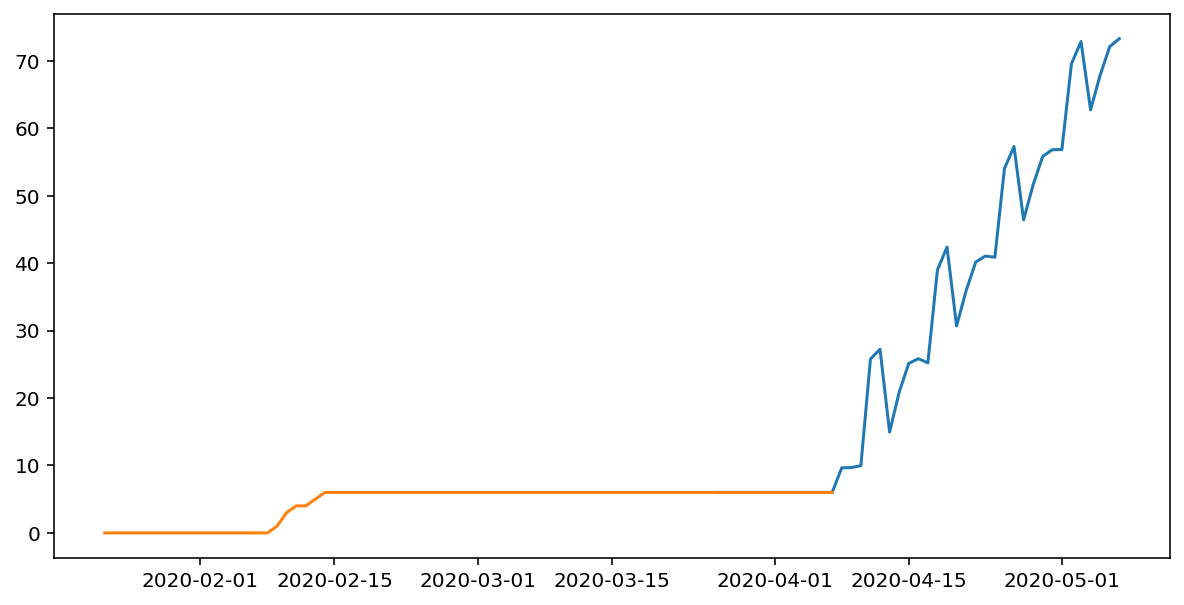

Beijing


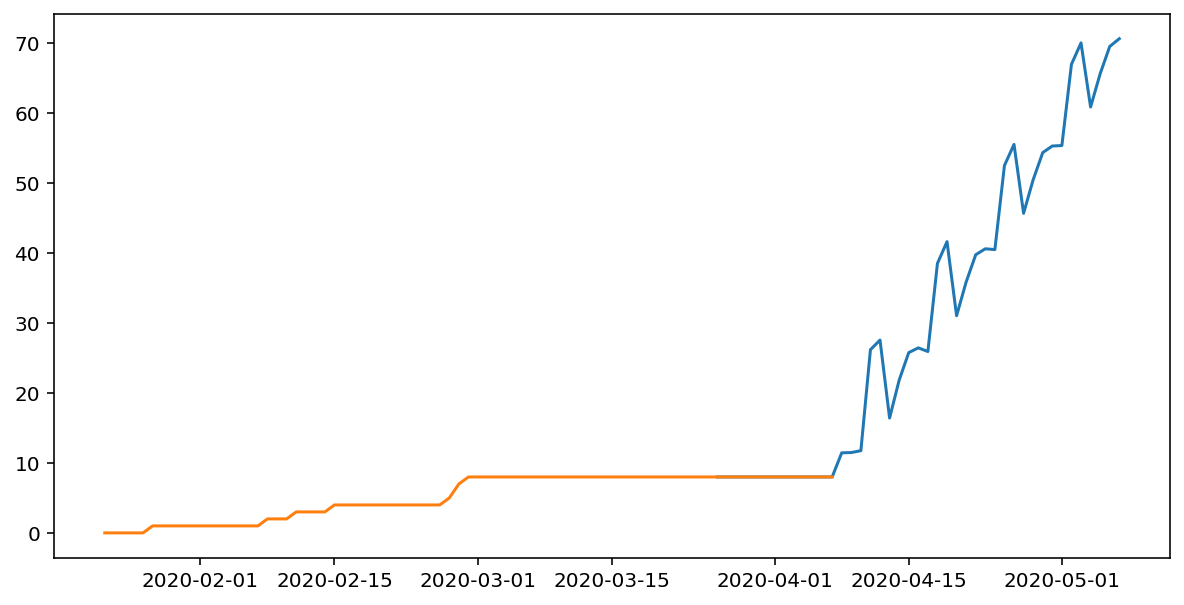

Chongqing


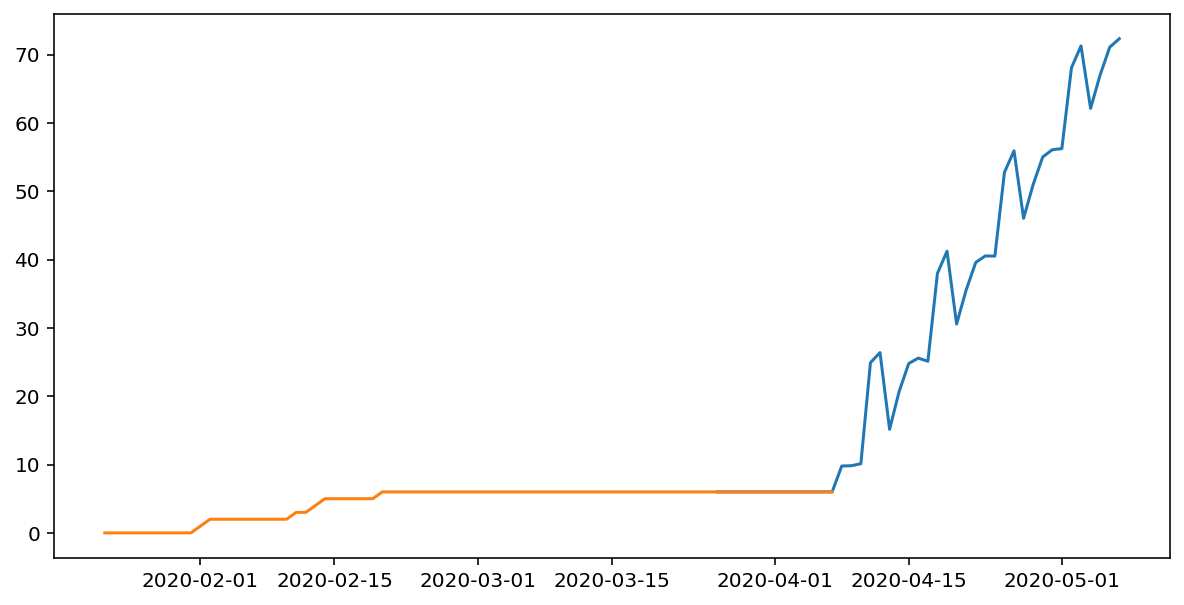

Fujian


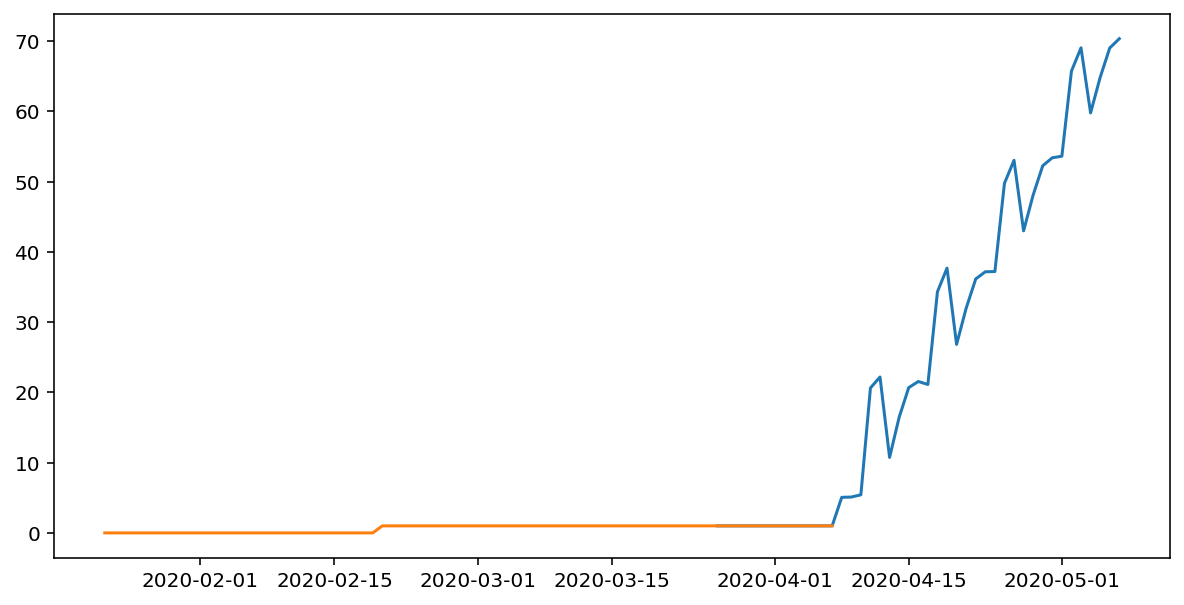

Gansu


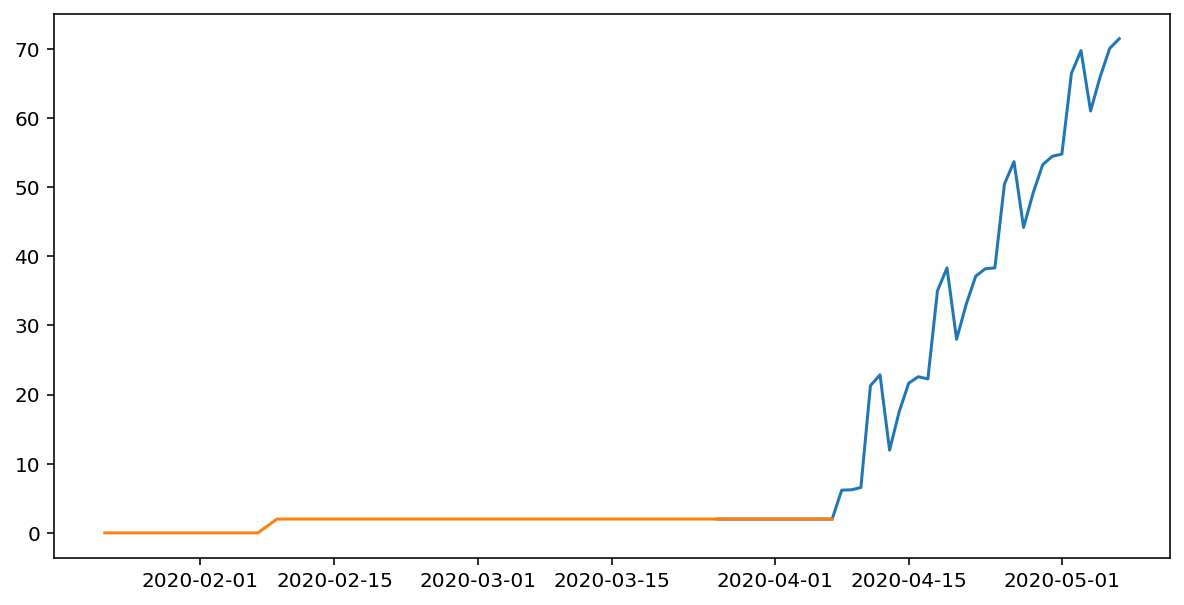

Guangdong


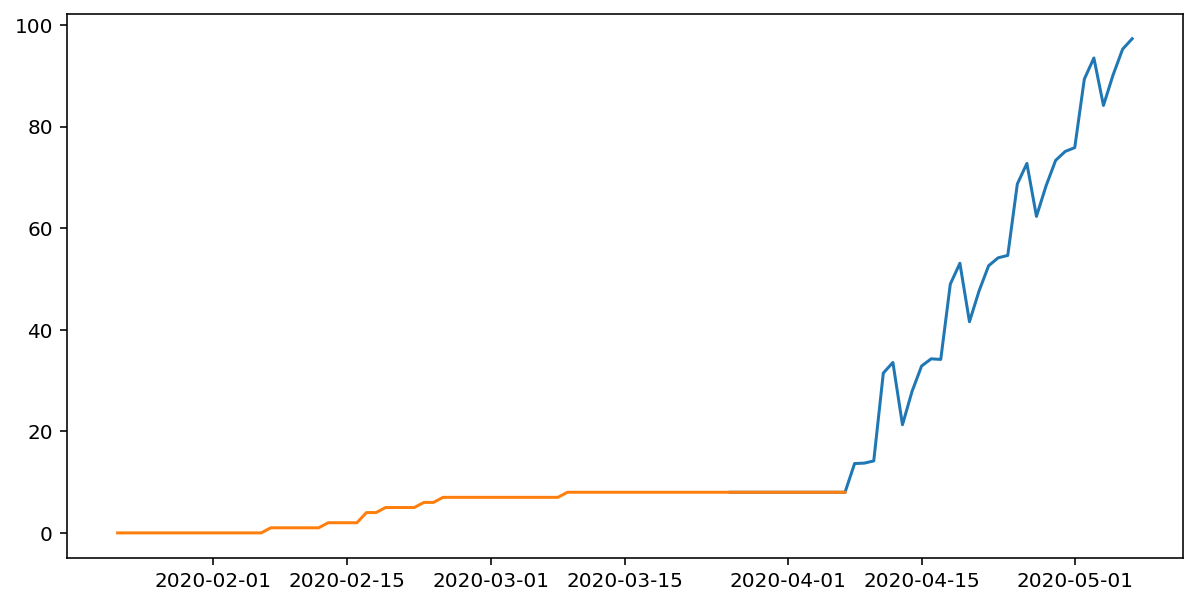

Guangxi


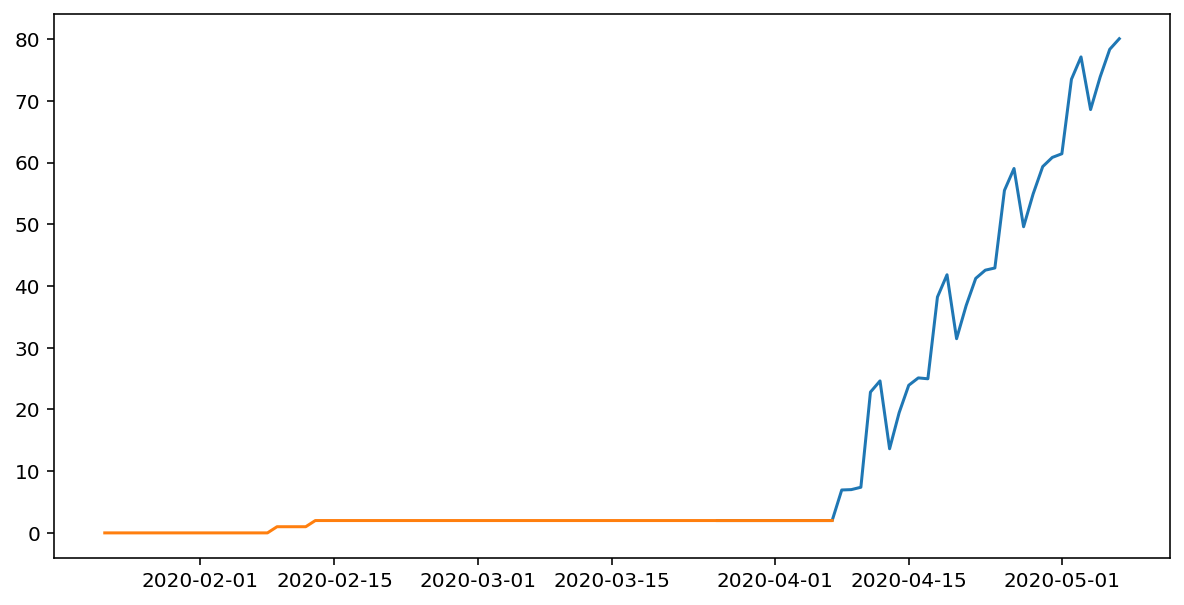

Guizhou


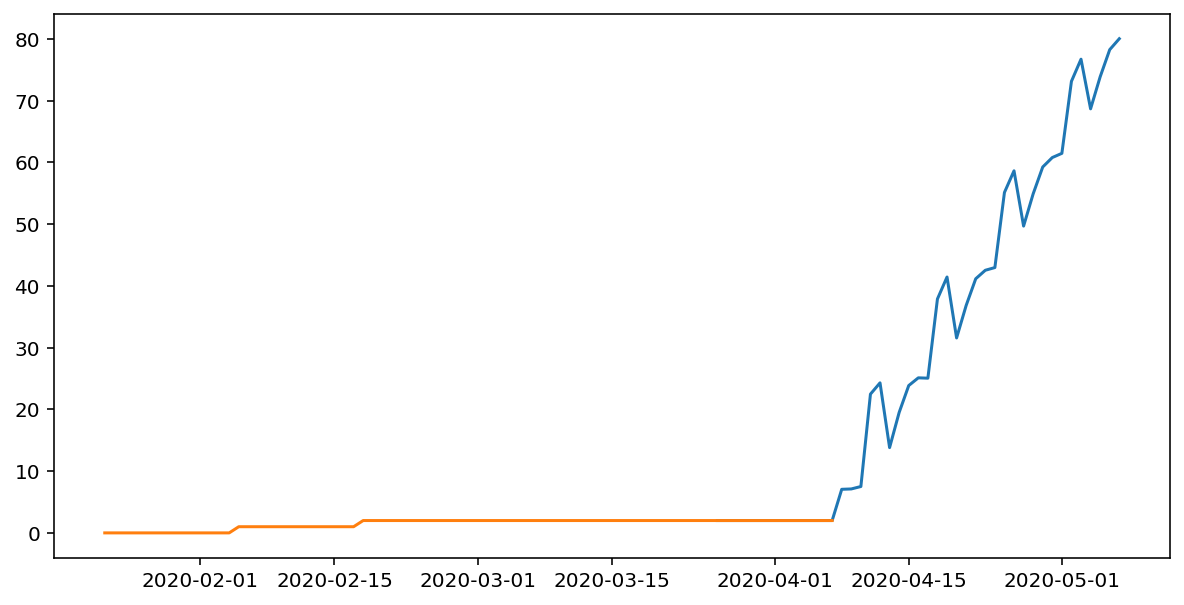

Hainan


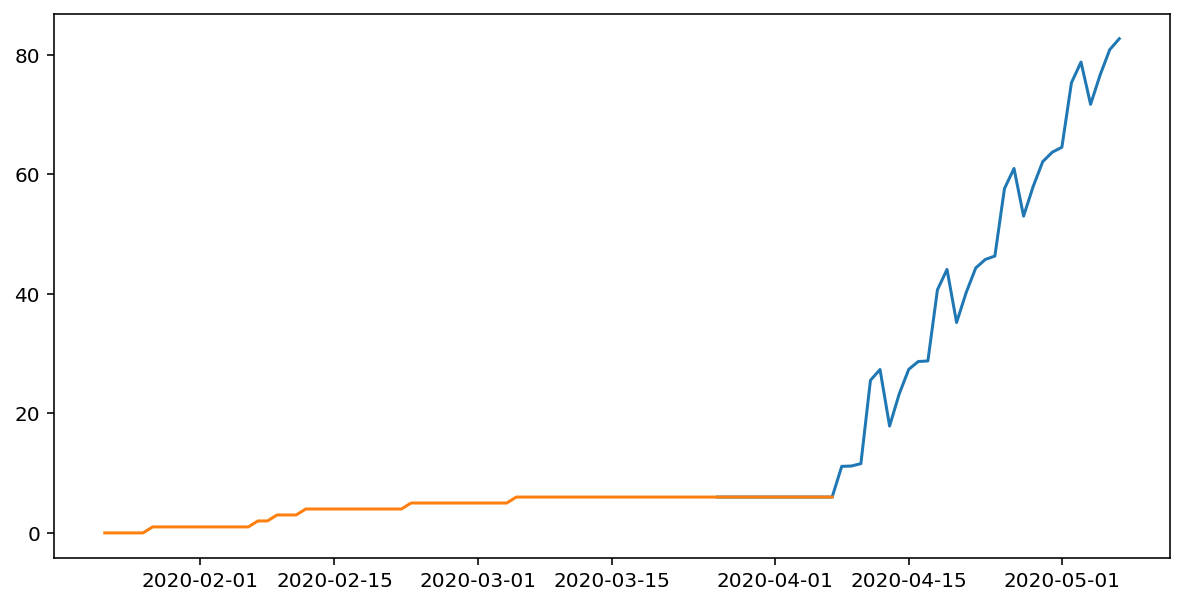

Hebei


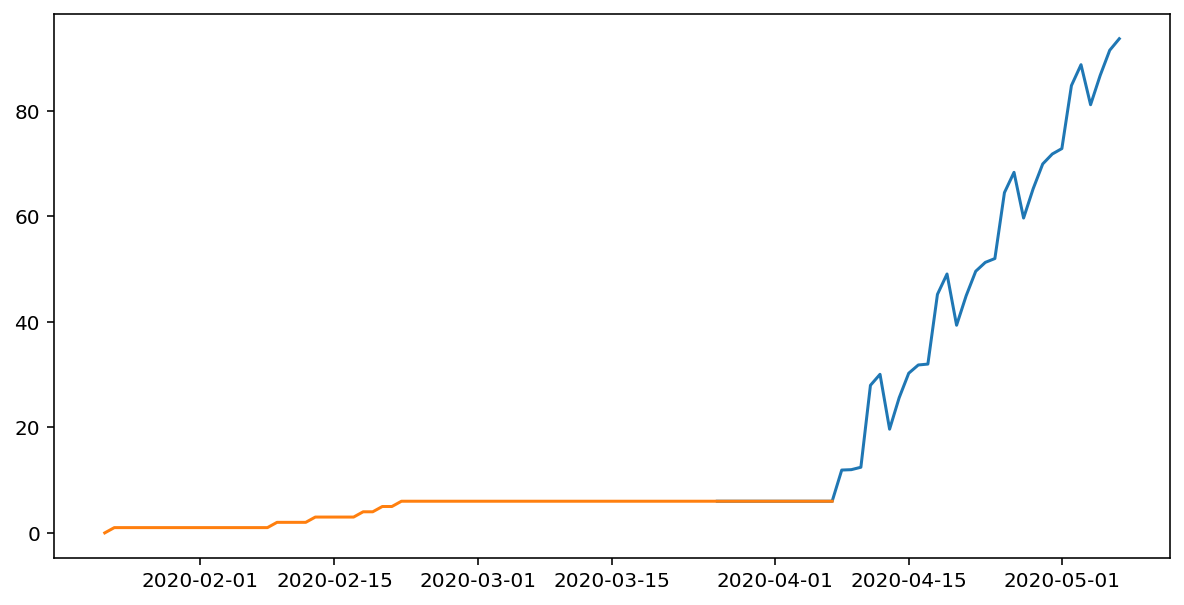

Heilongjiang


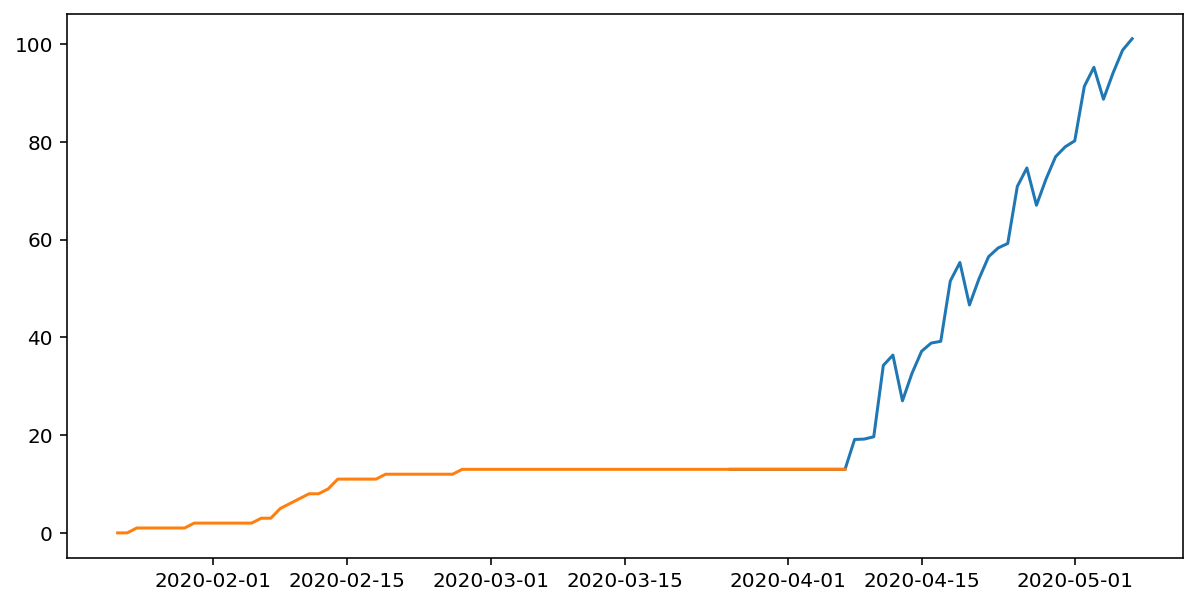

Henan


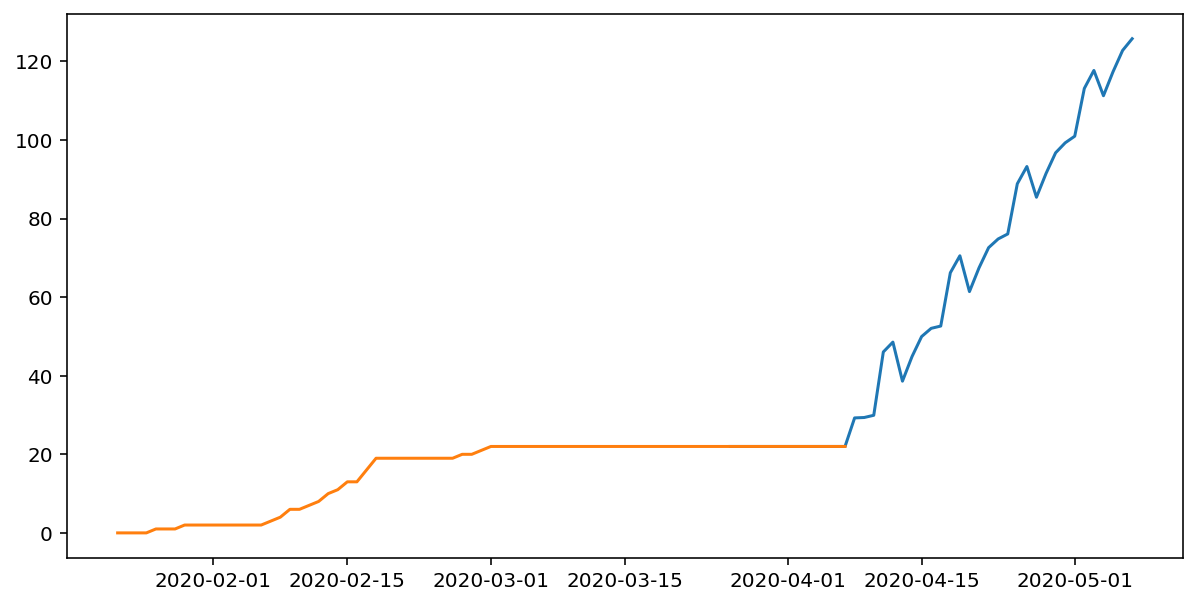

Hong Kong


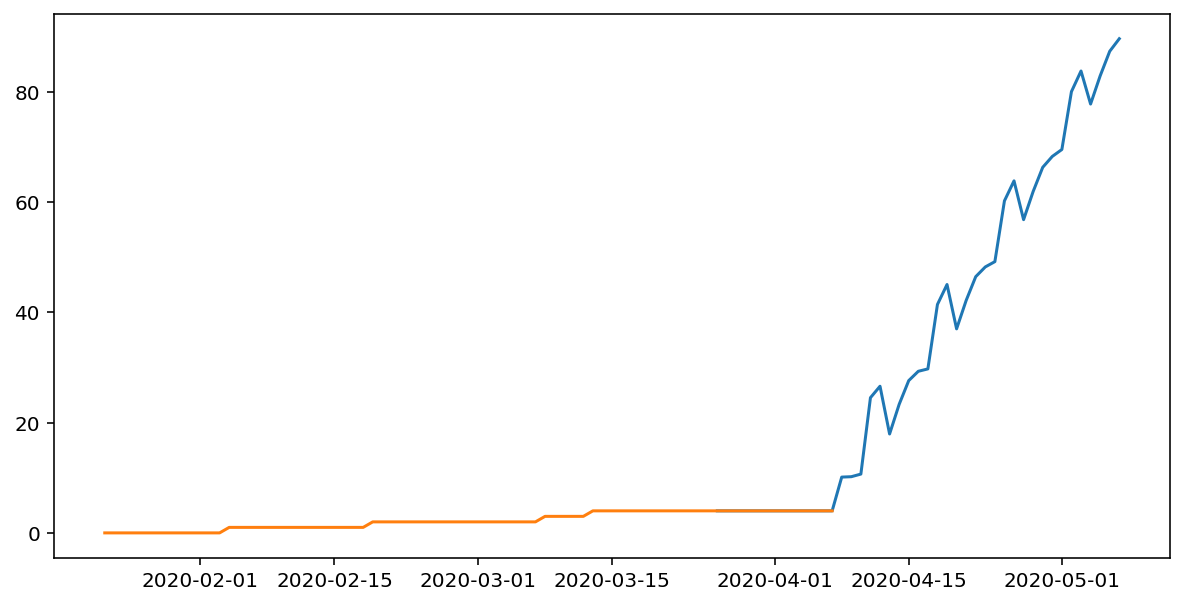

Hubei


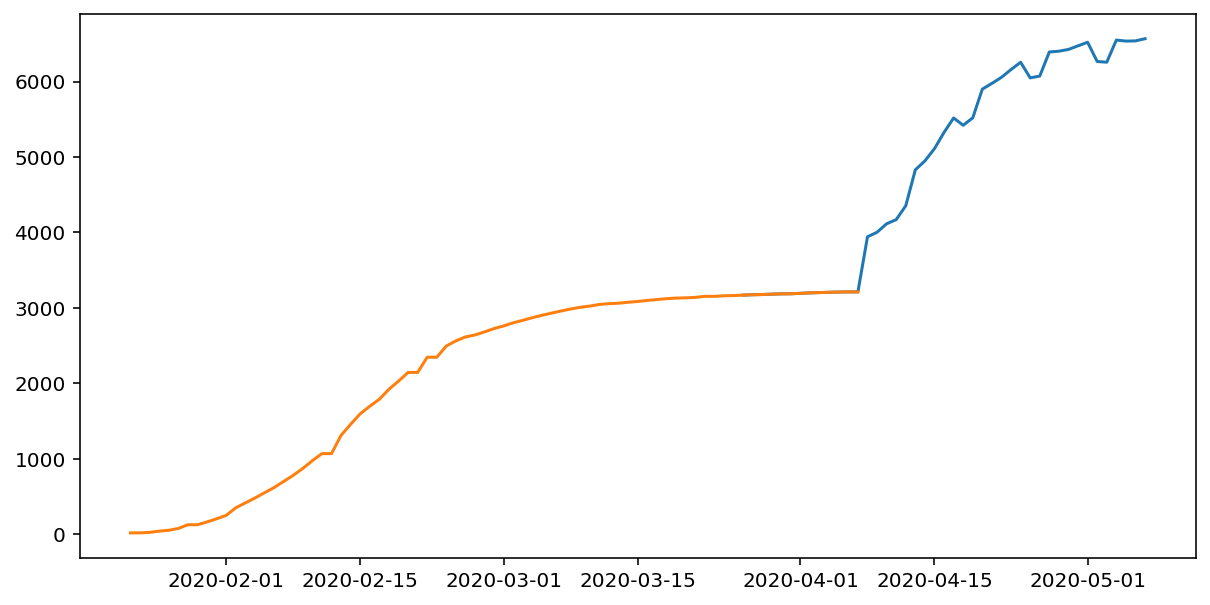

Hunan


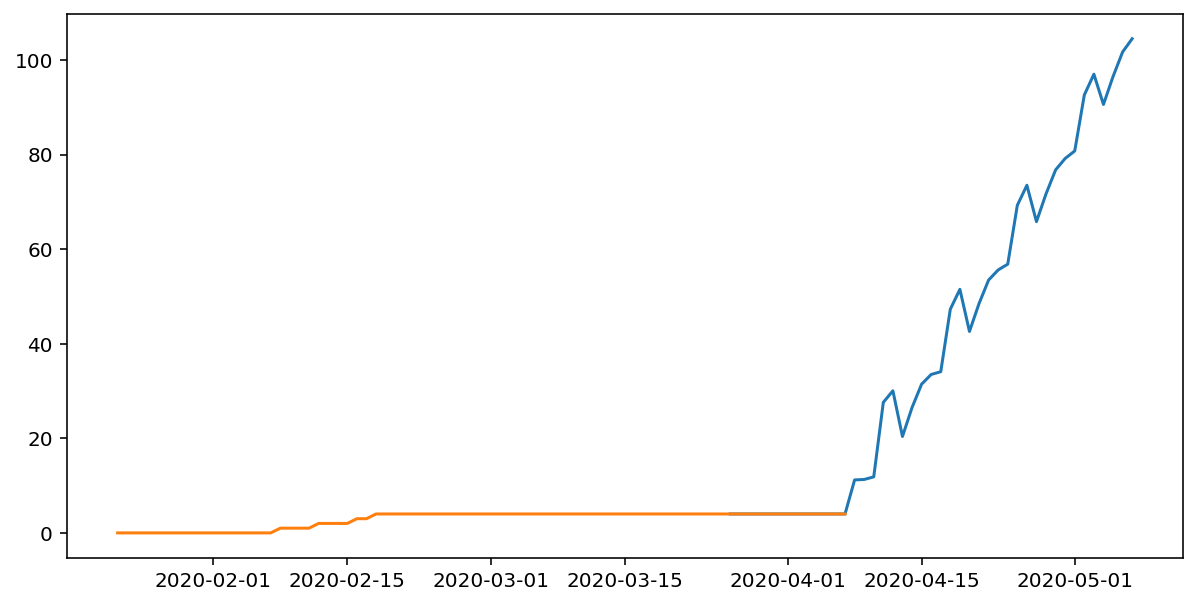

Inner Mongolia


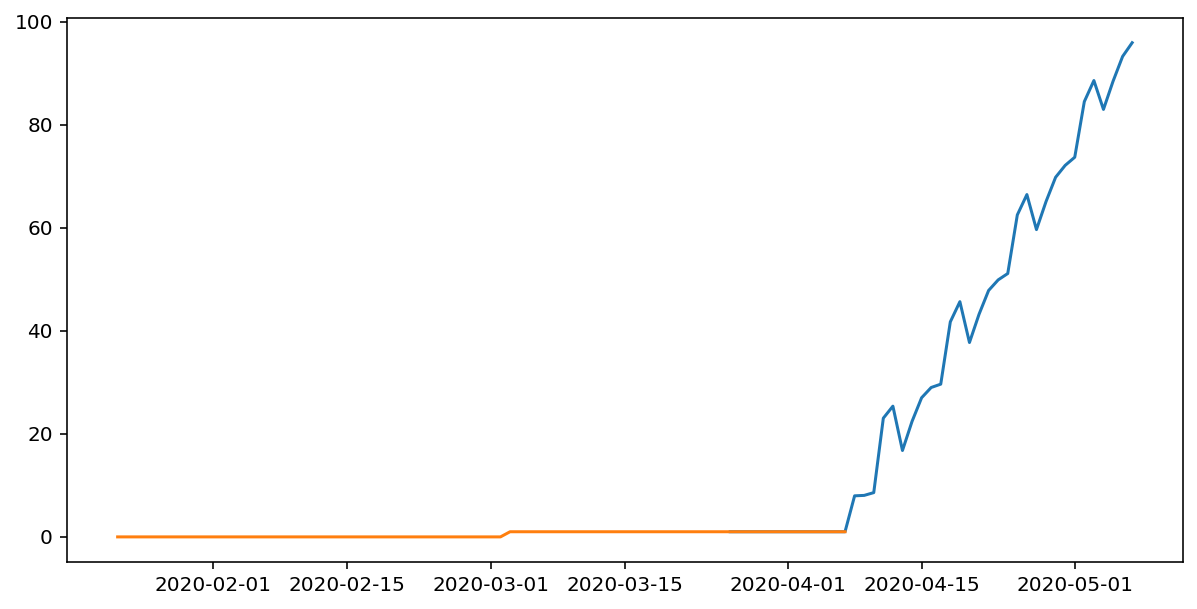

Jiangsu


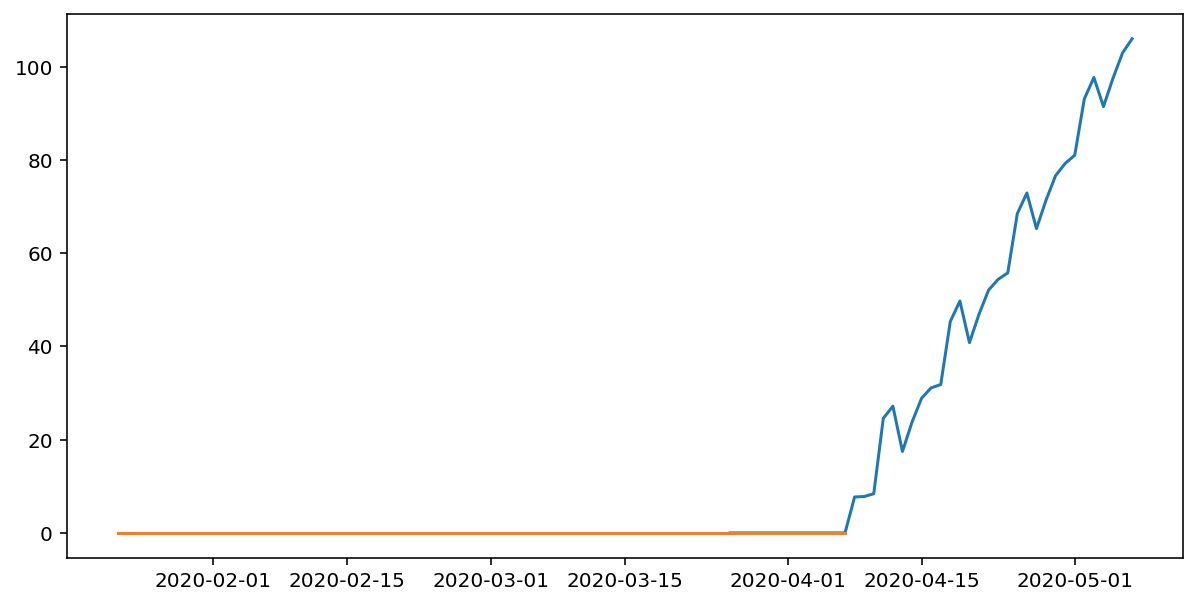

Jiangxi


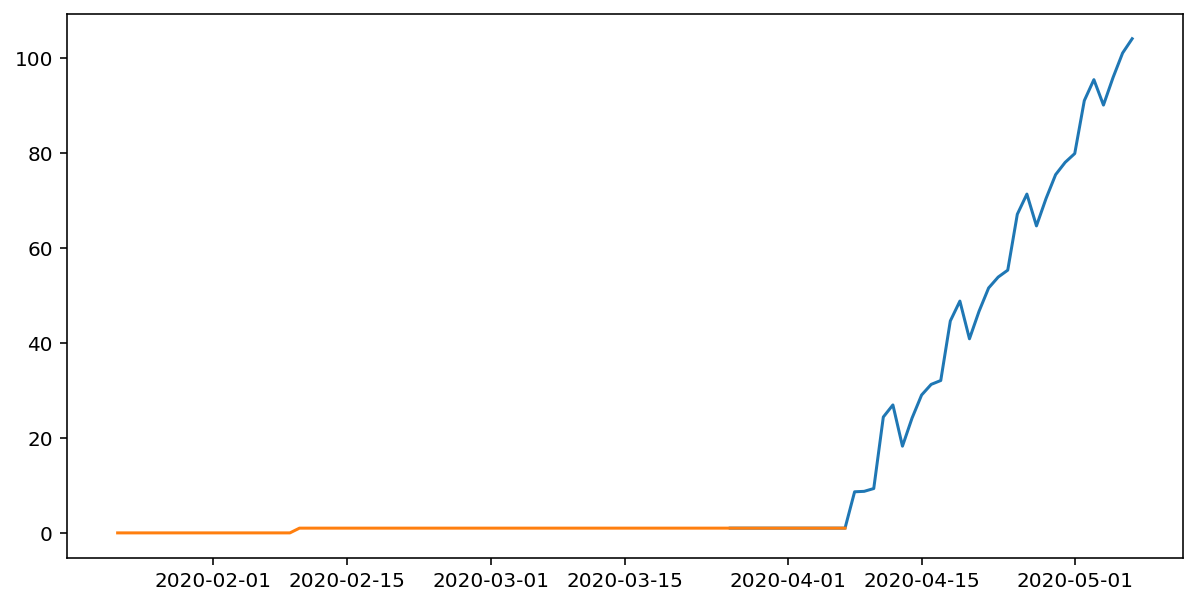

Jilin


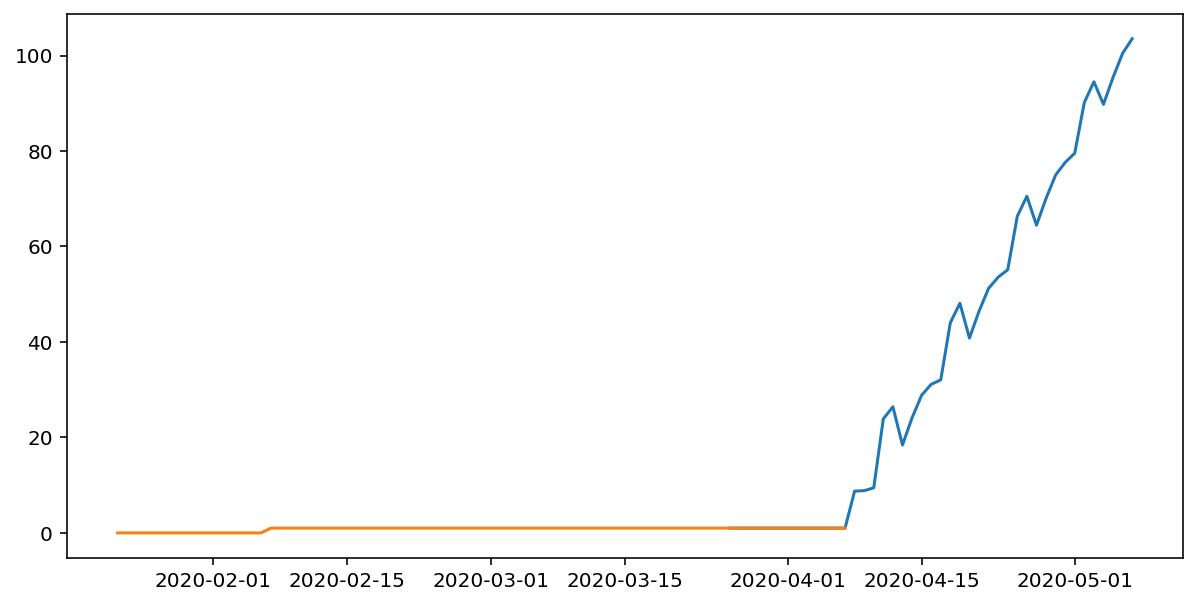

Liaoning


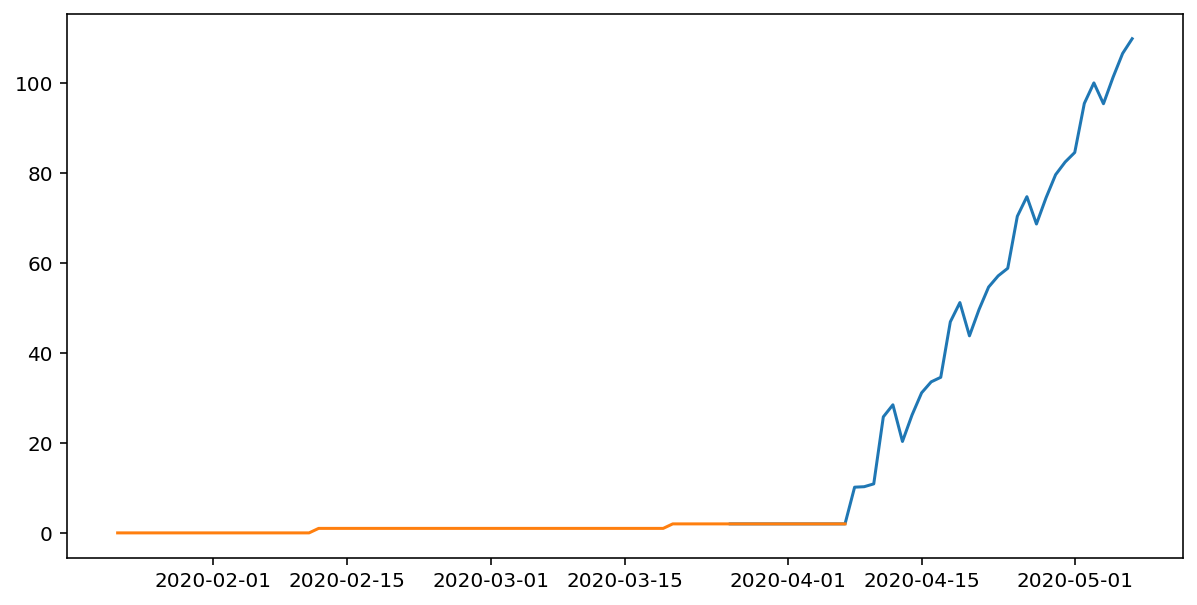

Macau


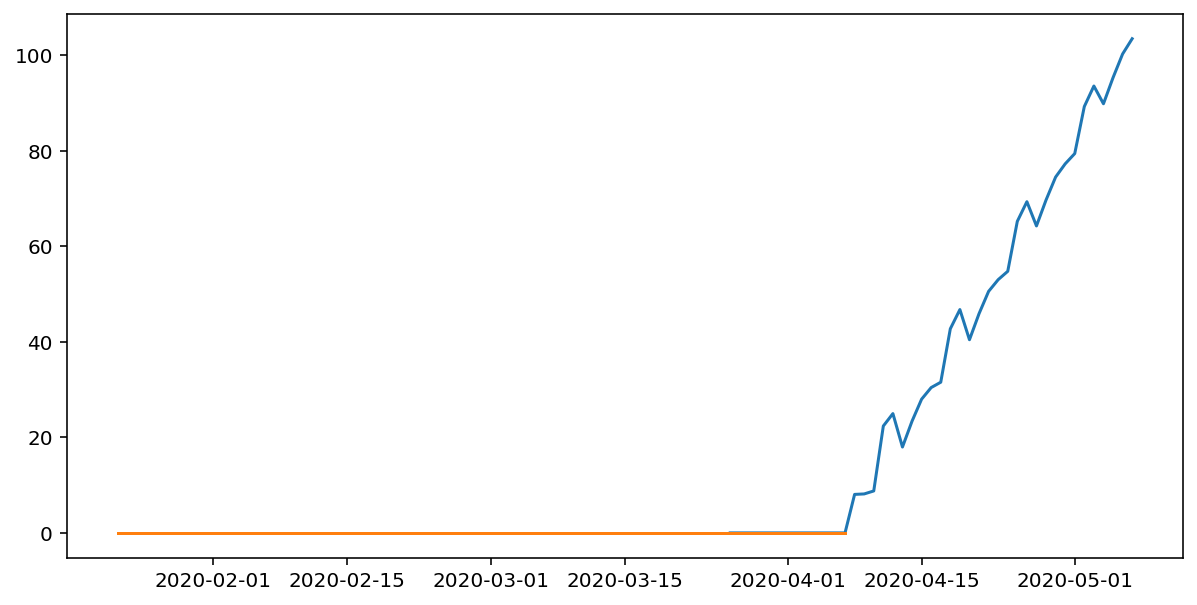

Ningxia


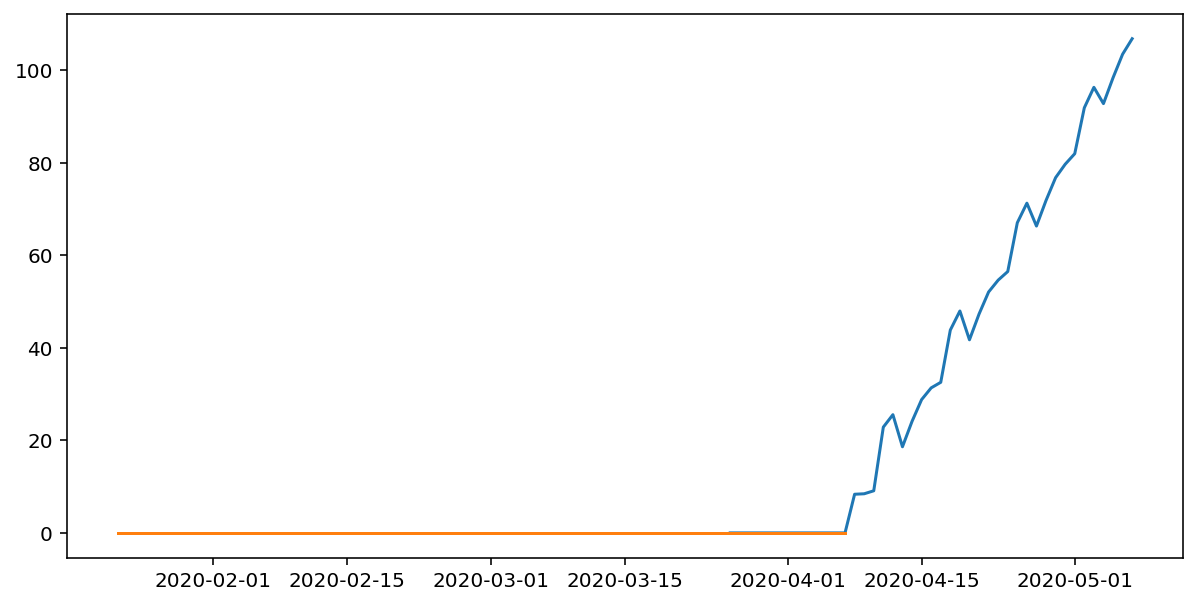

Qinghai


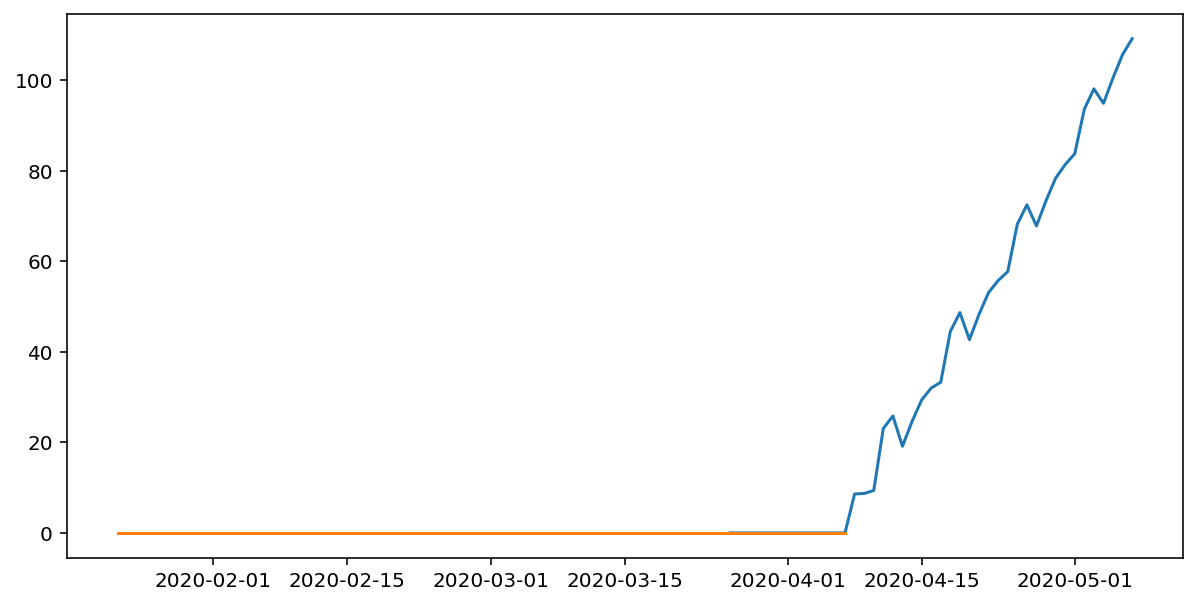

Shaanxi


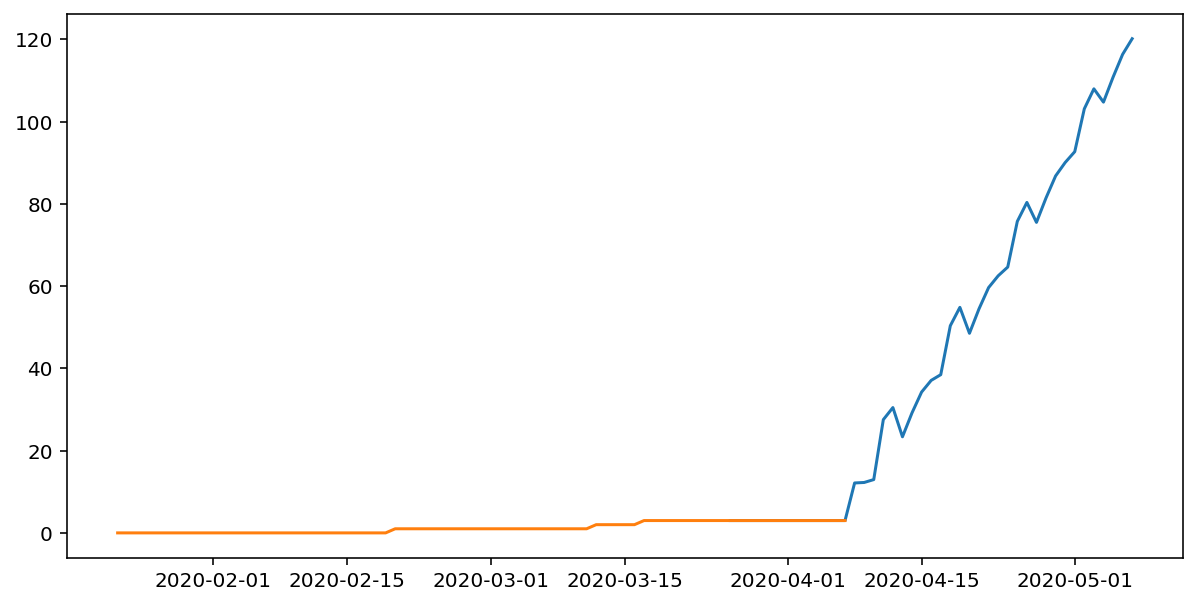

Shandong


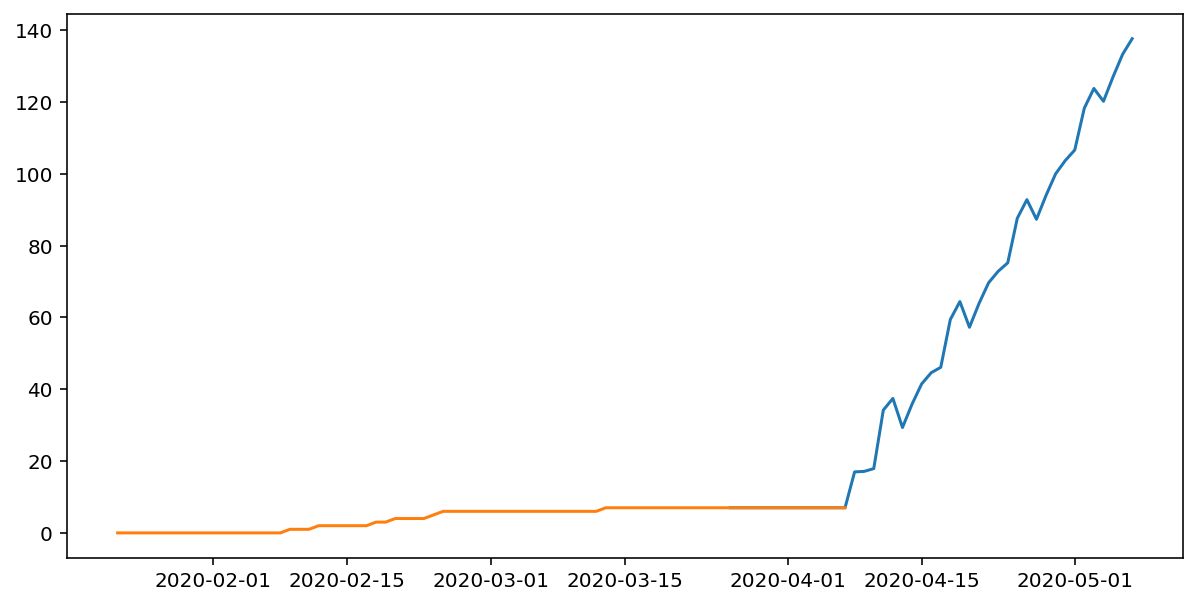

Shanghai


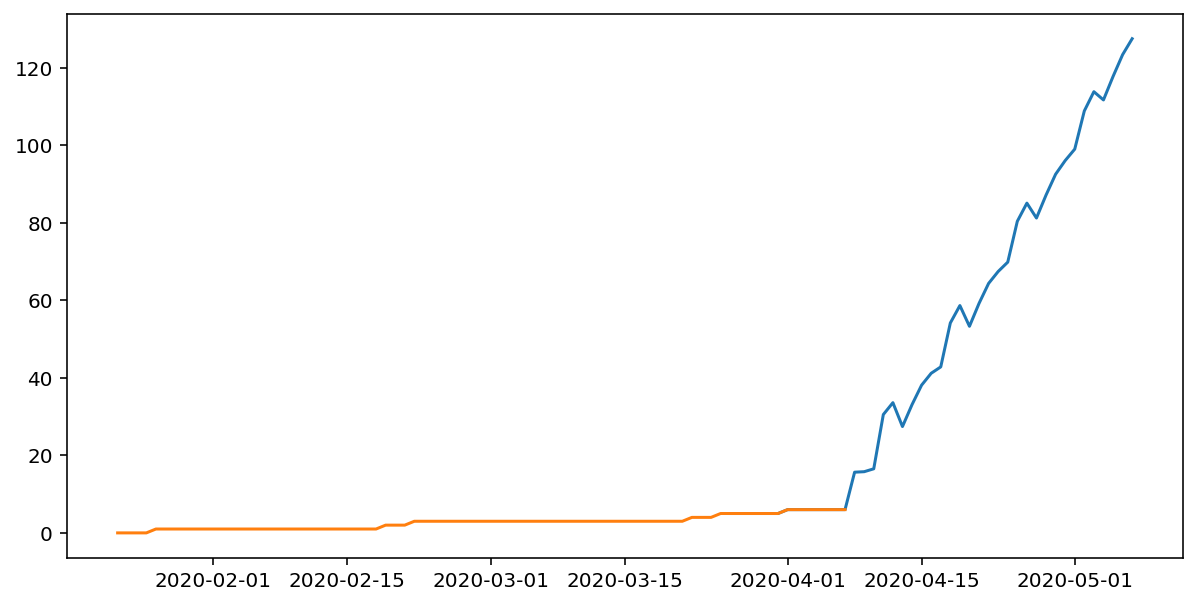

Shanxi


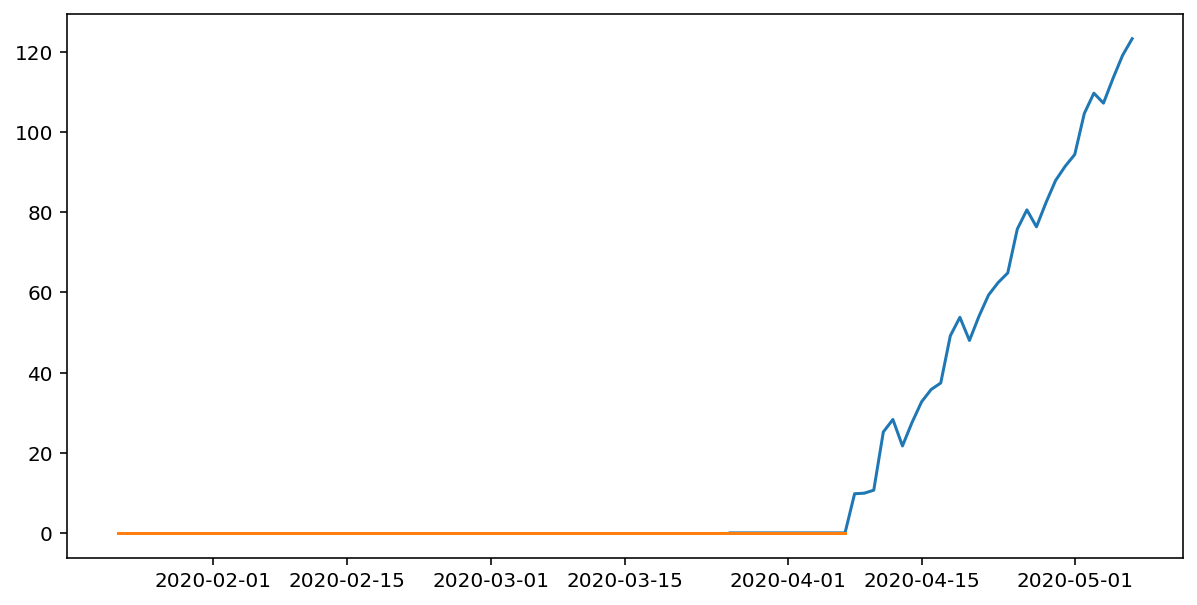

Sichuan


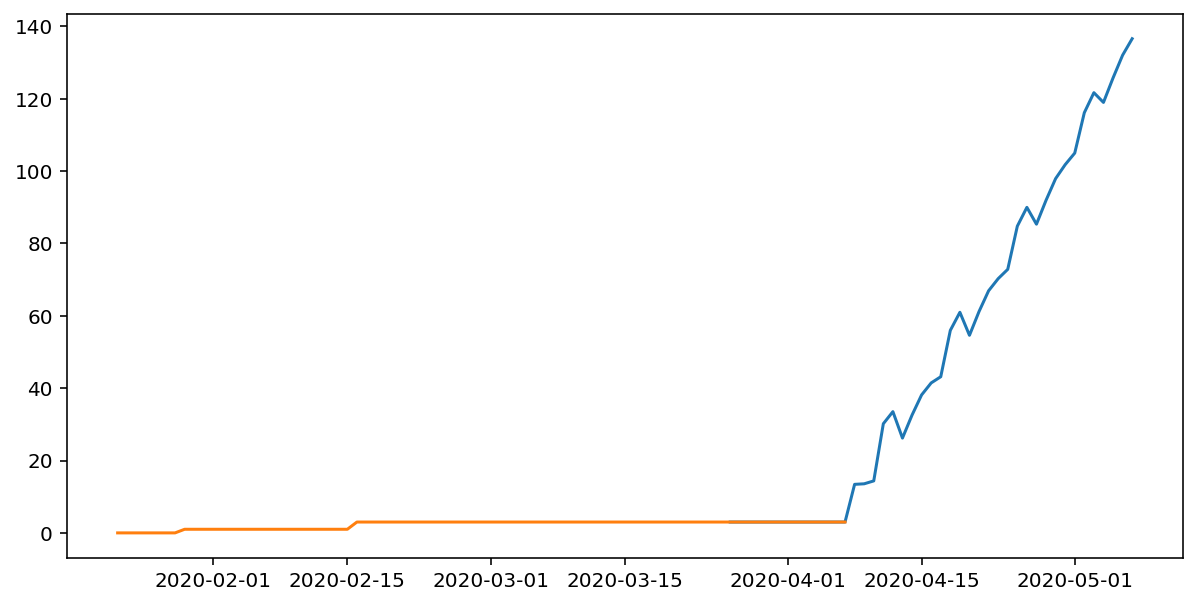

Tianjin


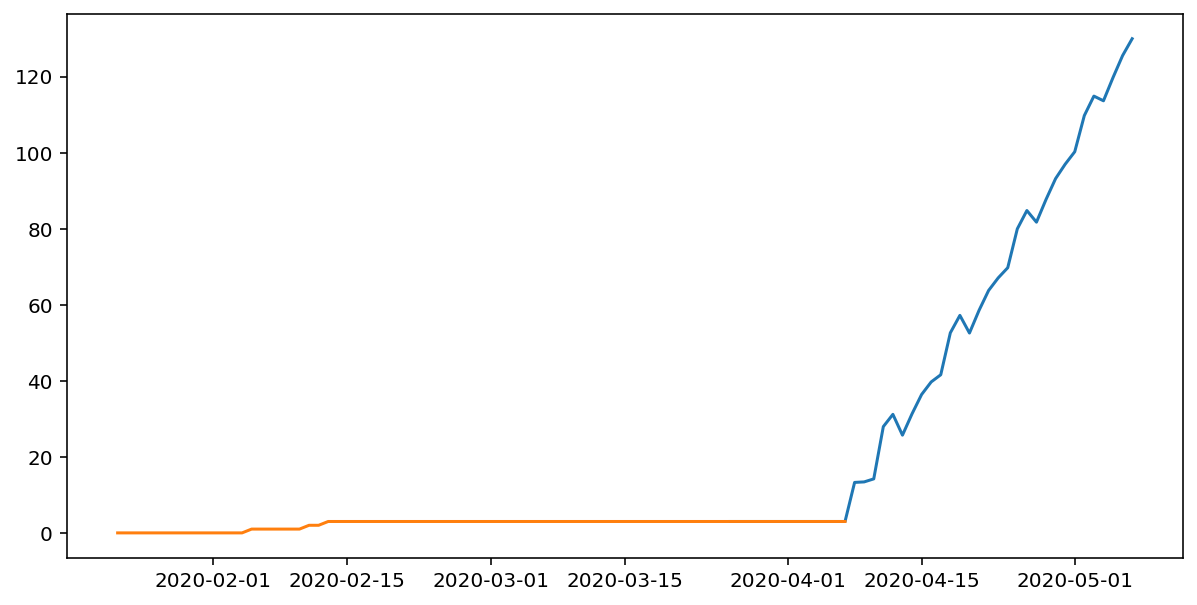

Tibet


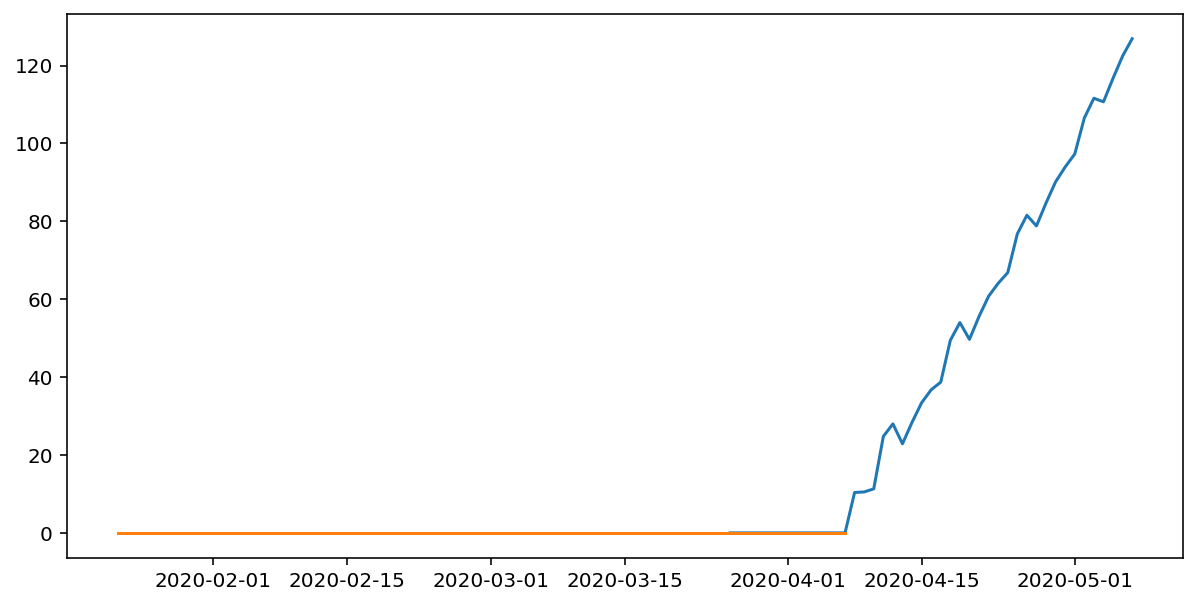

Xinjiang


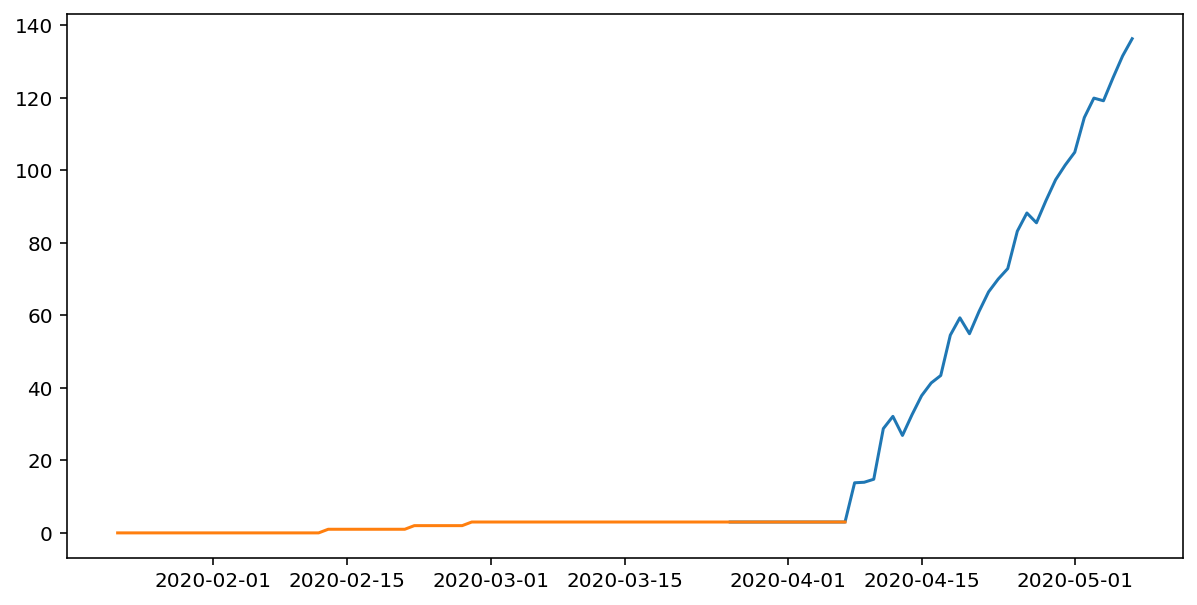

Yunnan


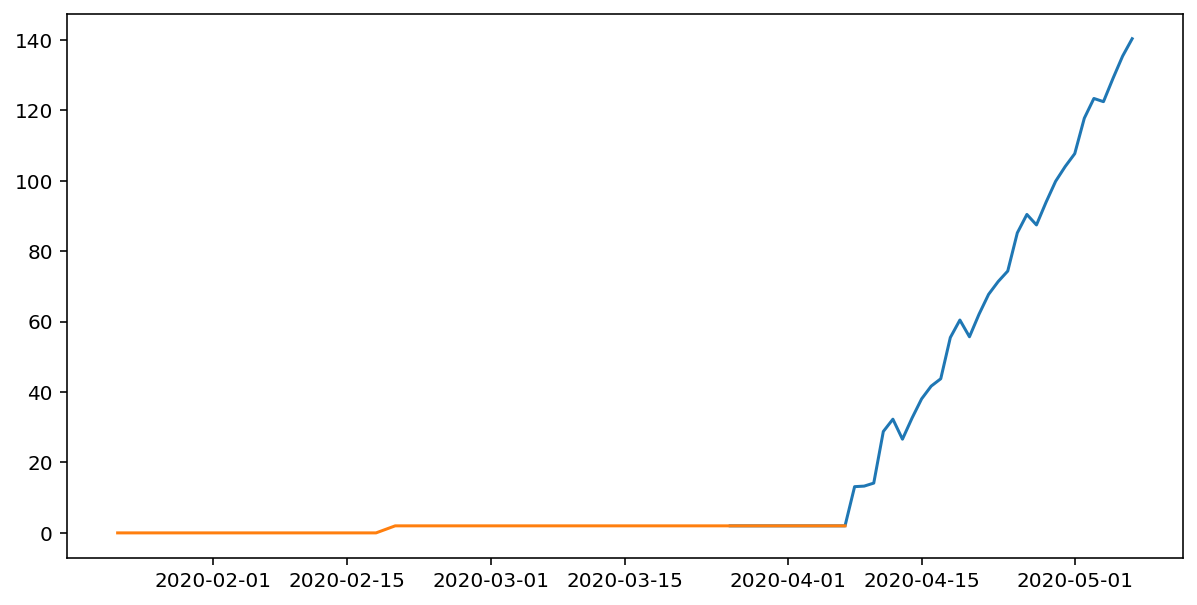

Zhejiang


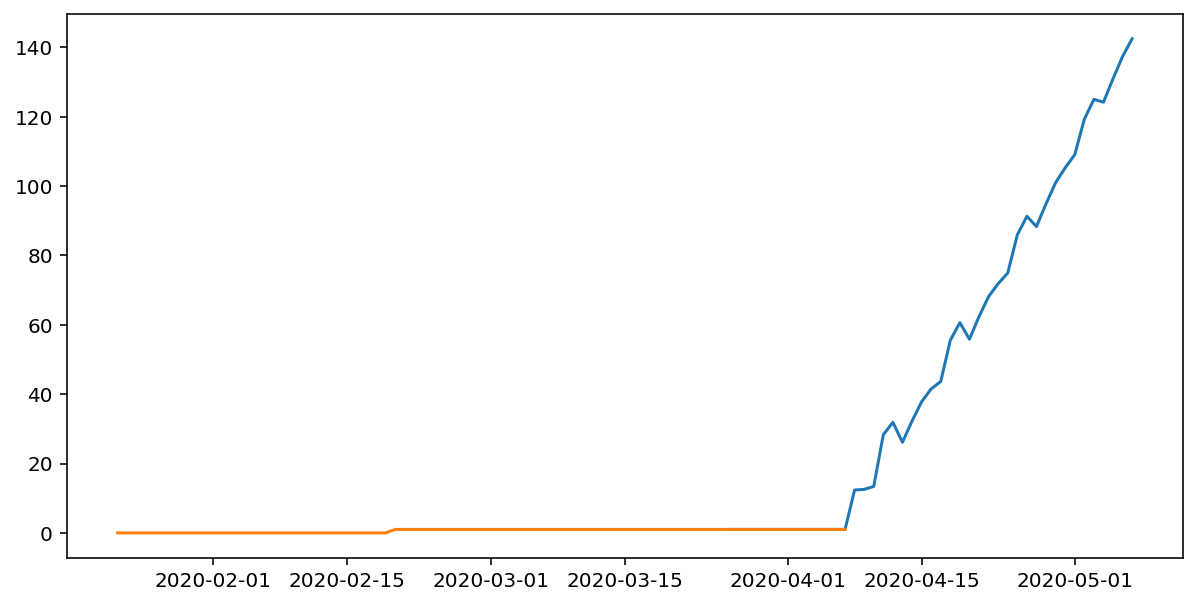

In [59]:
country = 'China'#
for i in test_data[test_data['Country_Region']==country]['Province_State'].unique().tolist():
    fig = plt.figure(figsize=(10,5))
    print(i)
    y1 = train[(train['Country_Region']==country) & (train['Province_State']==i)]['Fatalities']
    x1 = train[(train['Country_Region']==country) & (train['Province_State']==i)]['Date']
    y = test_data[(test_data['Country_Region']==country) & (test_data['Province_State']==i)]['Fatalities']
    x = test_data[(test_data['Country_Region']==country) & (test_data['Province_State']==i)]['Date']

    plt.plot(x, y)
    plt.plot(x1, y1)
    plt.show()

Alabama


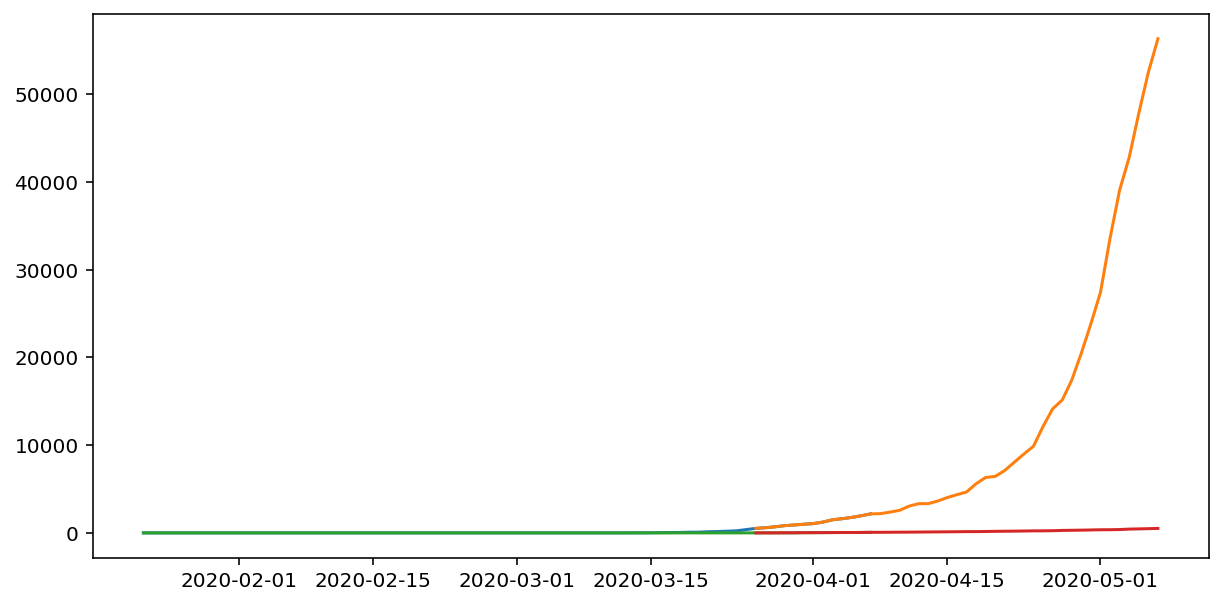

Alaska


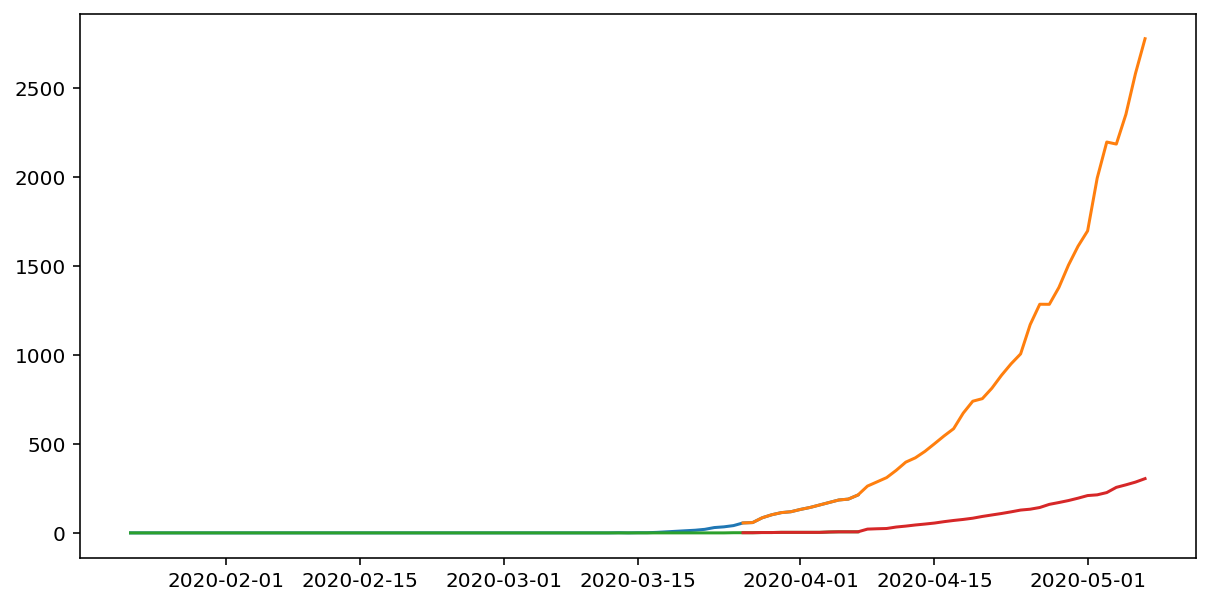

Arizona


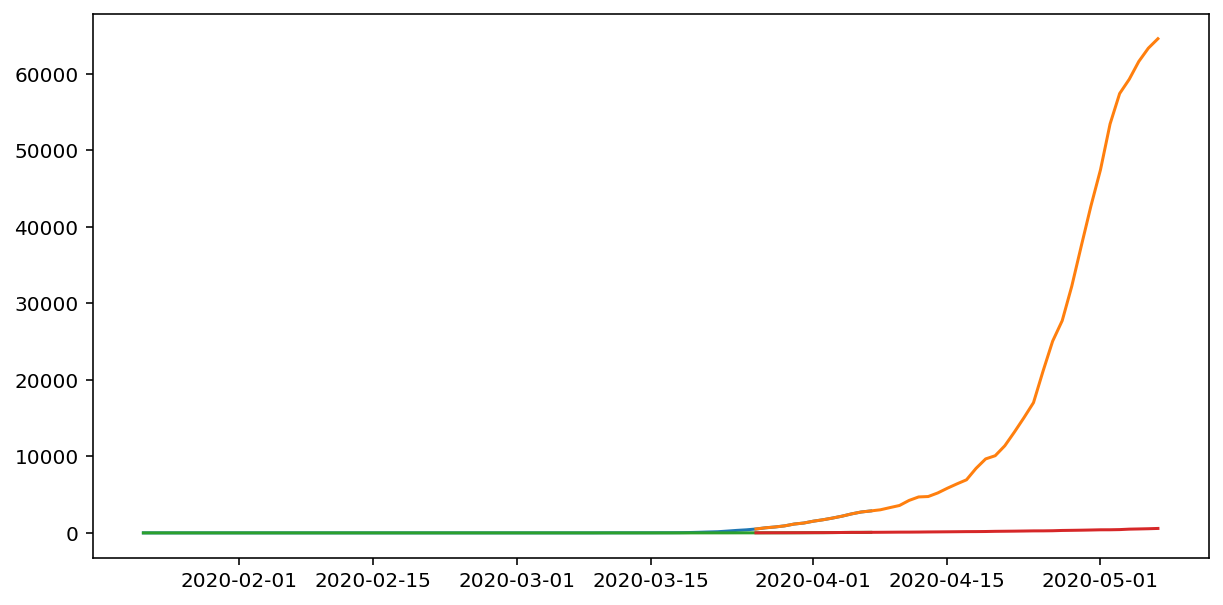

Arkansas


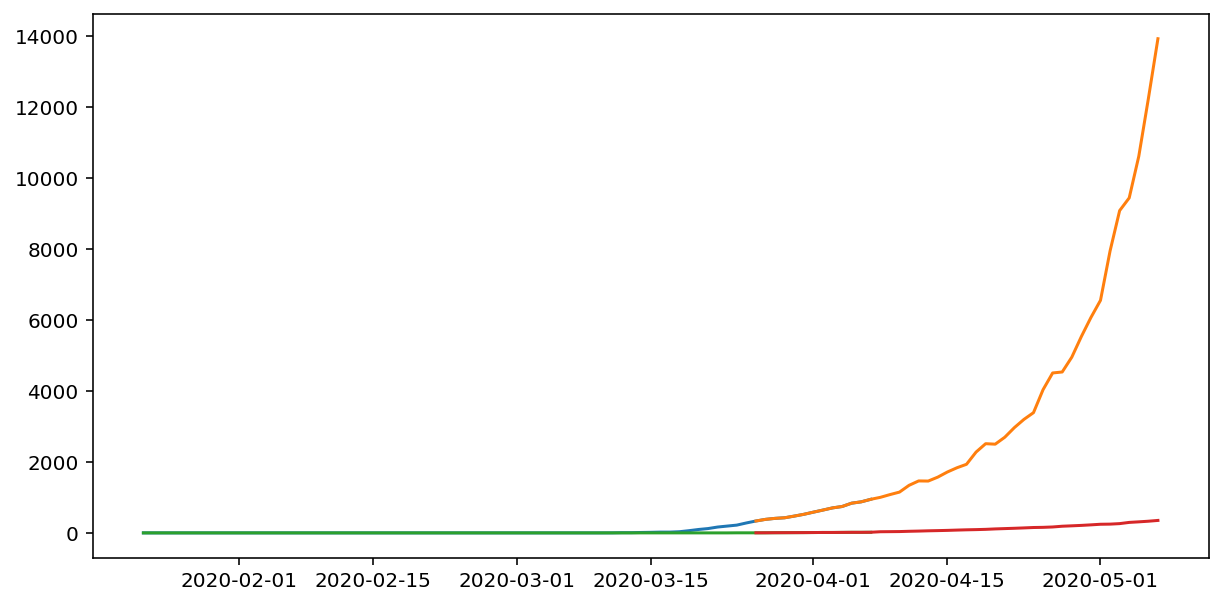

California


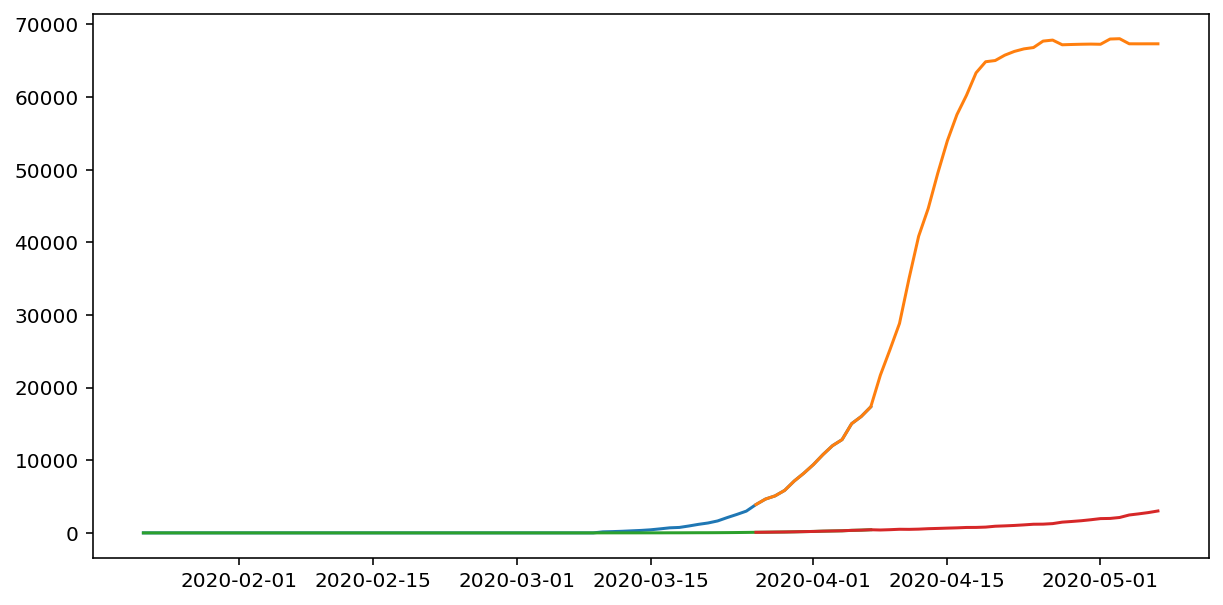

Colorado


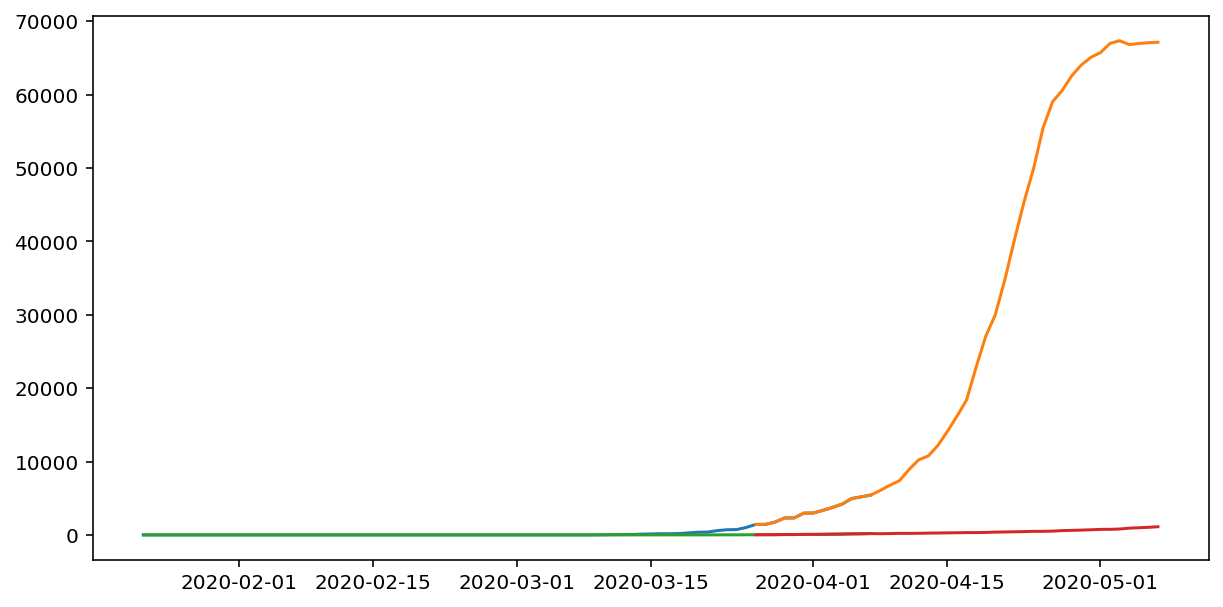

Connecticut


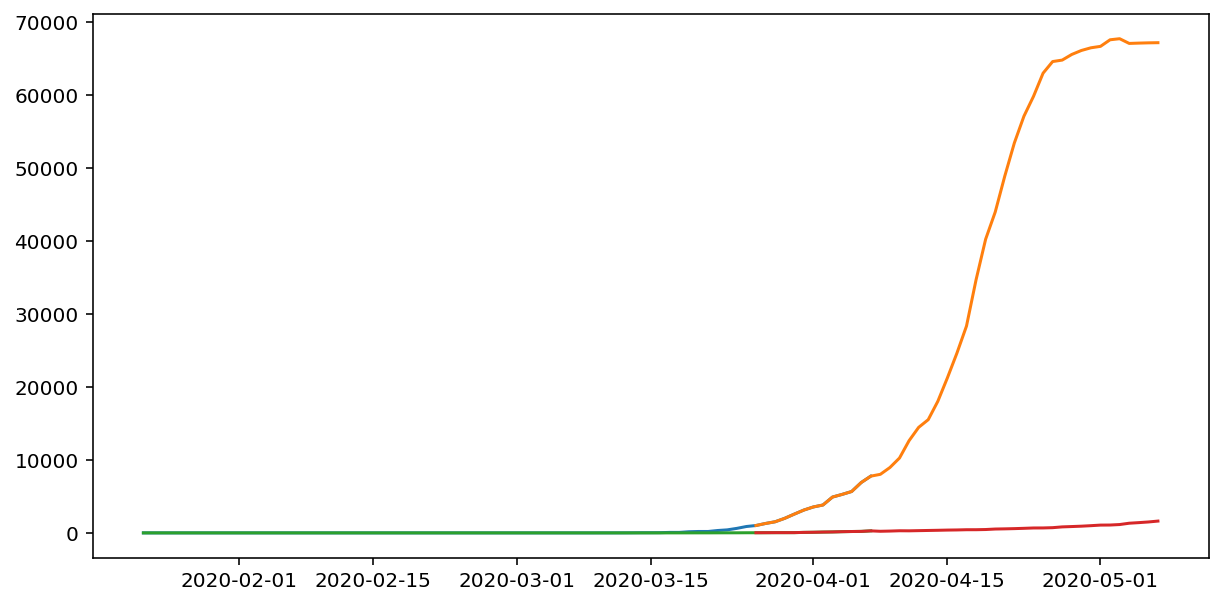

Delaware


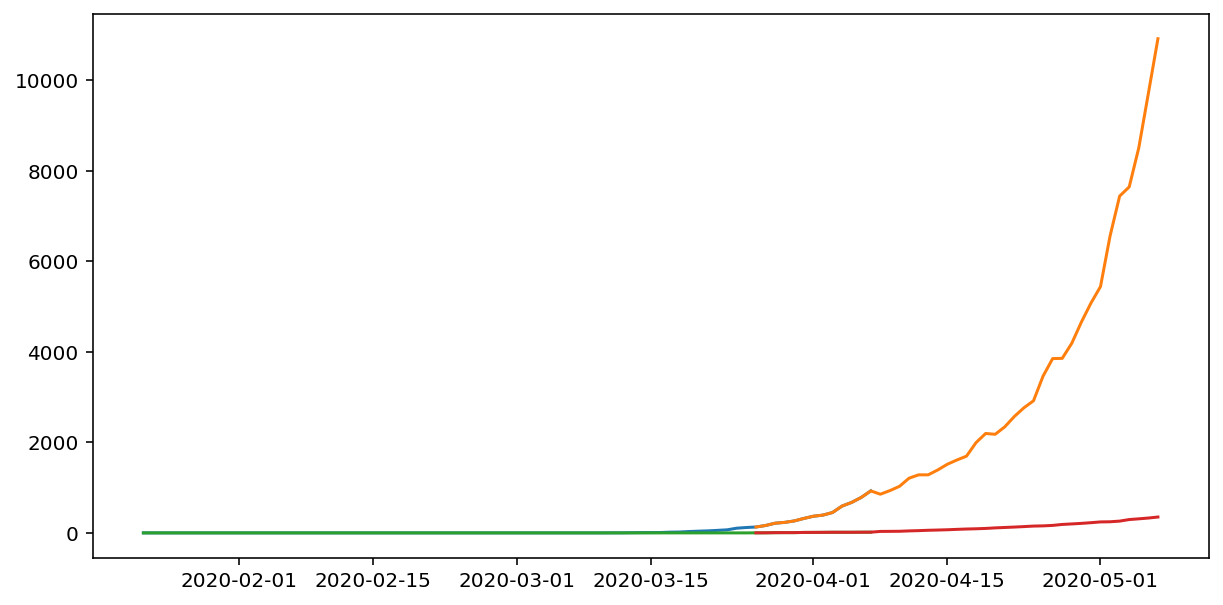

District of Columbia


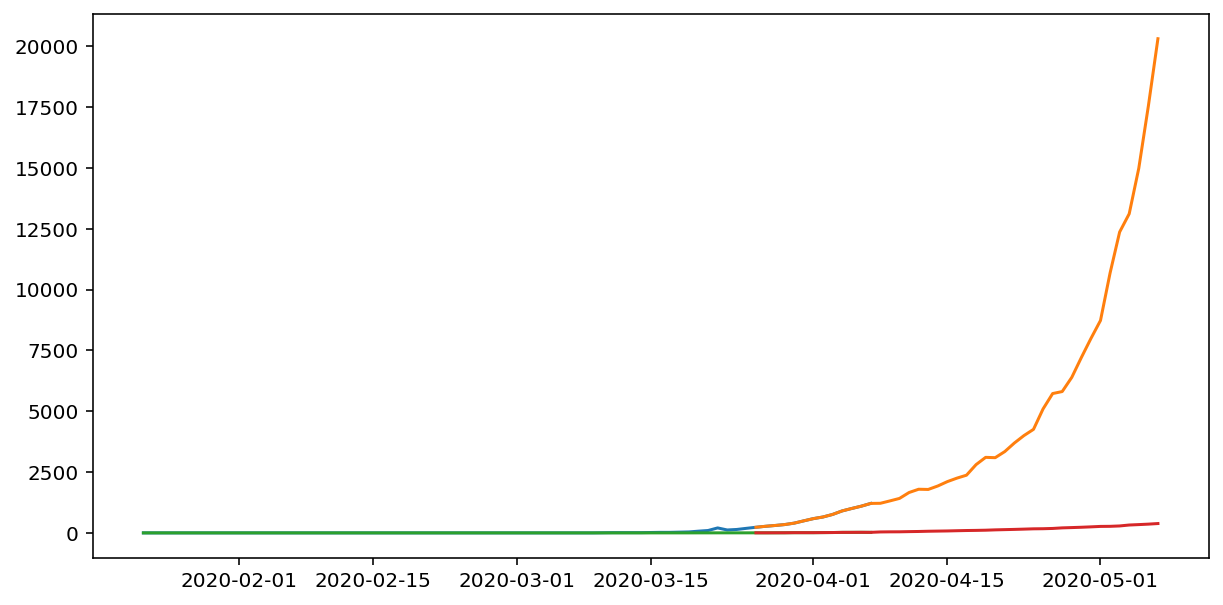

Florida


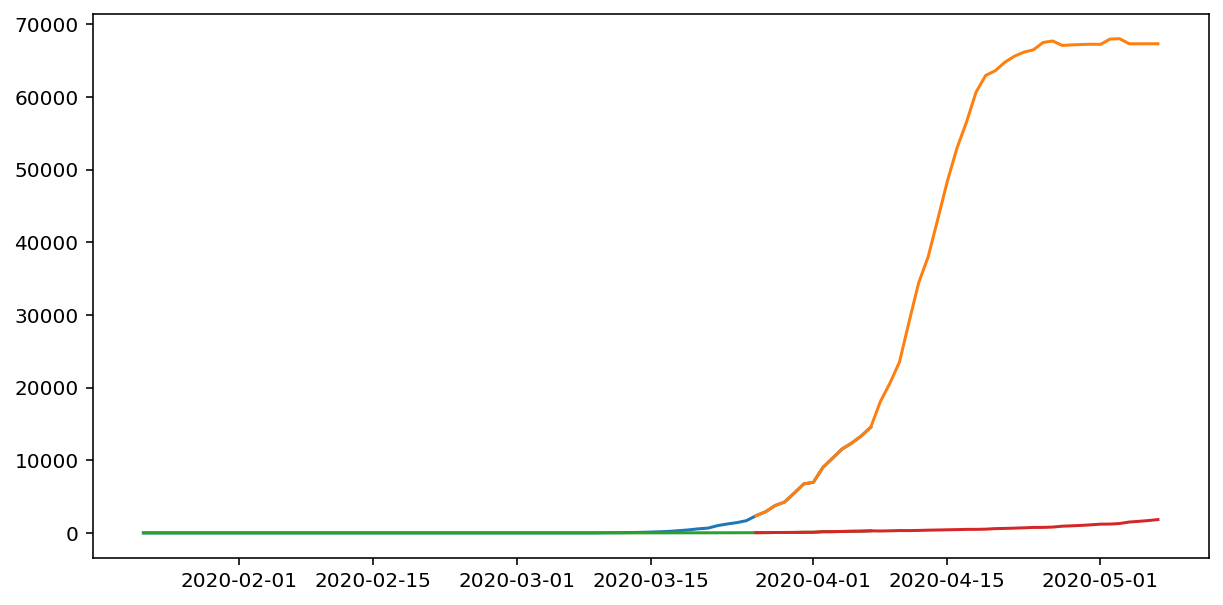

Georgia


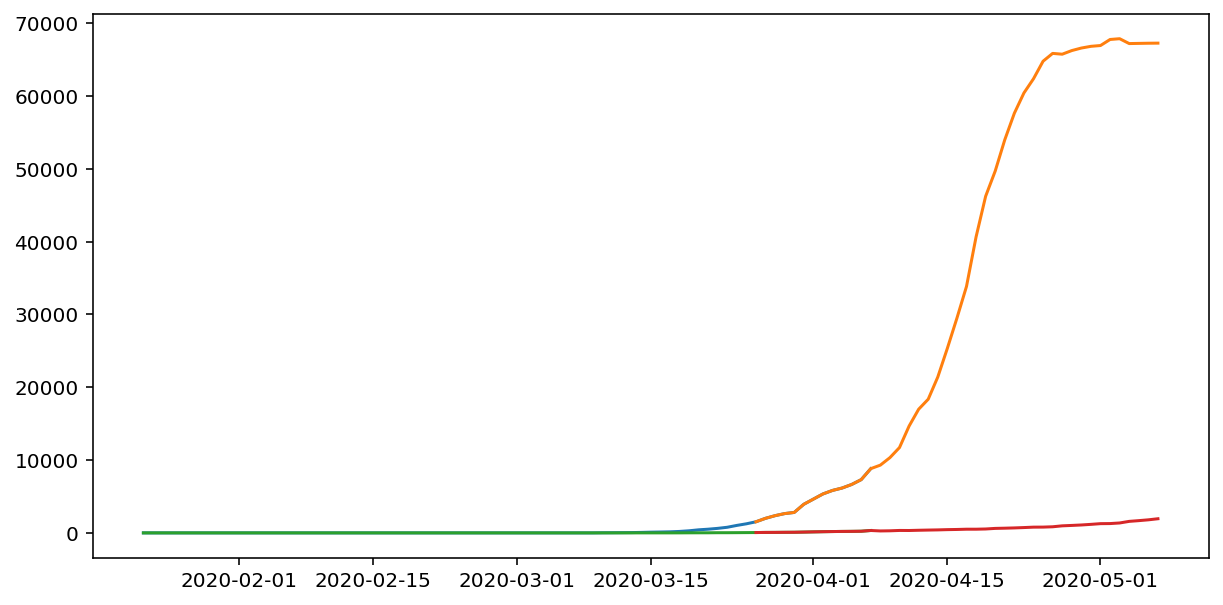

Guam


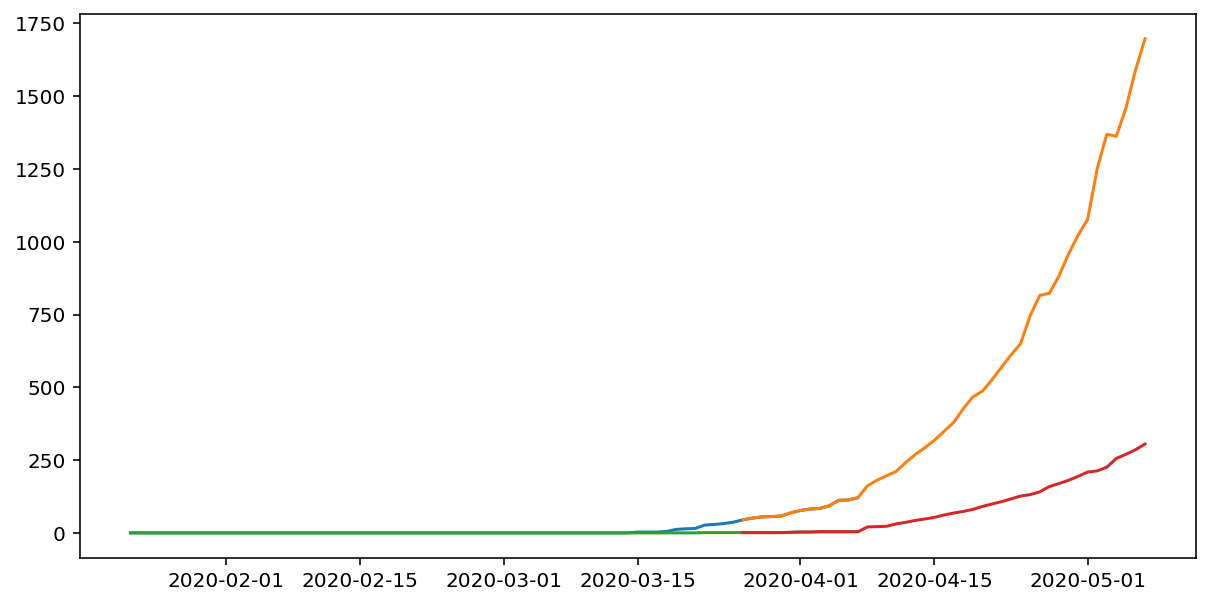

Hawaii


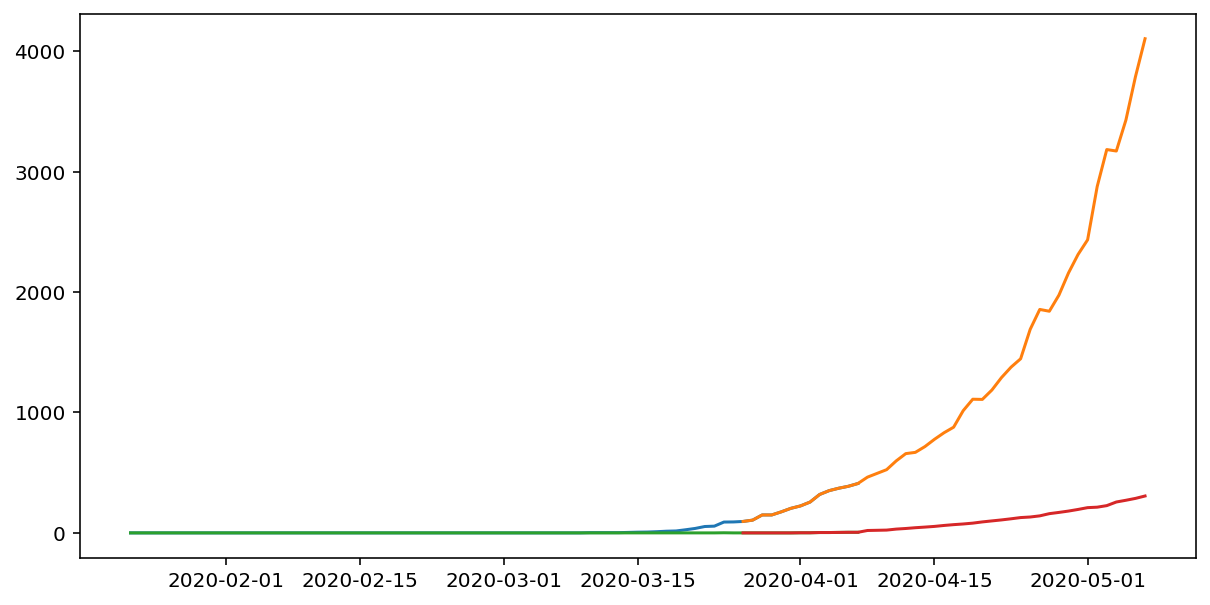

Idaho


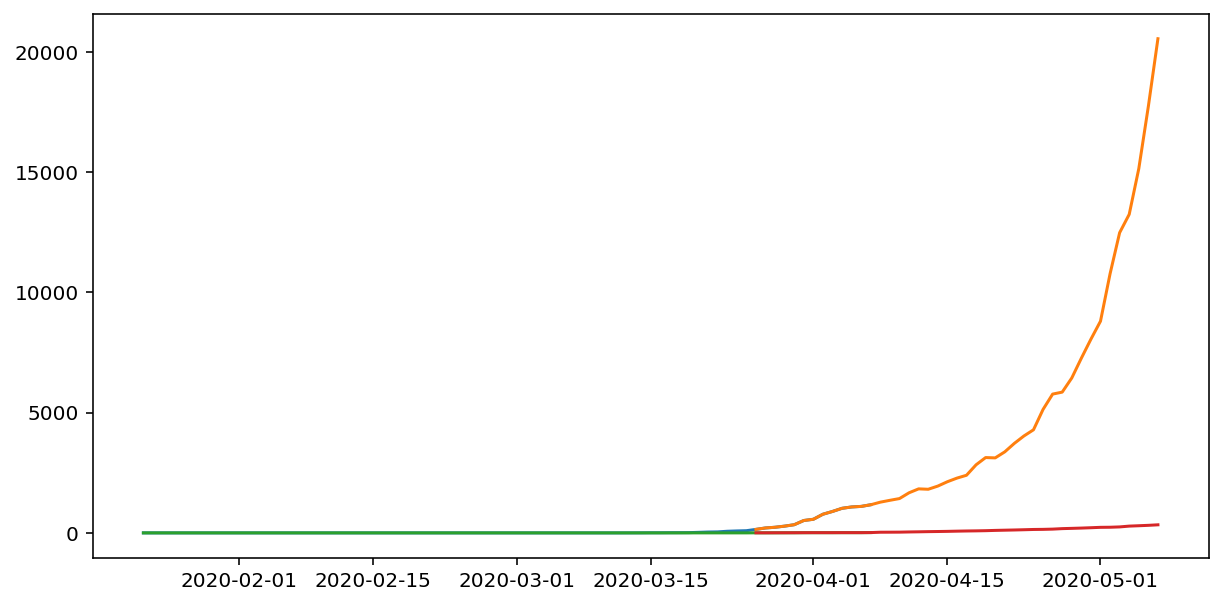

Illinois


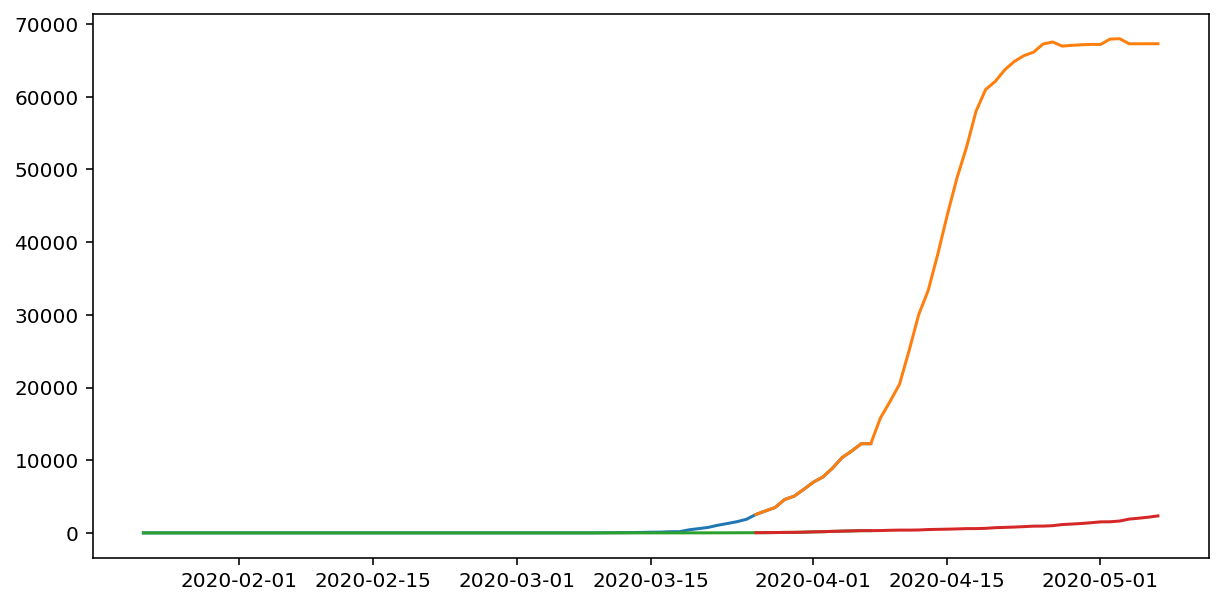

Indiana


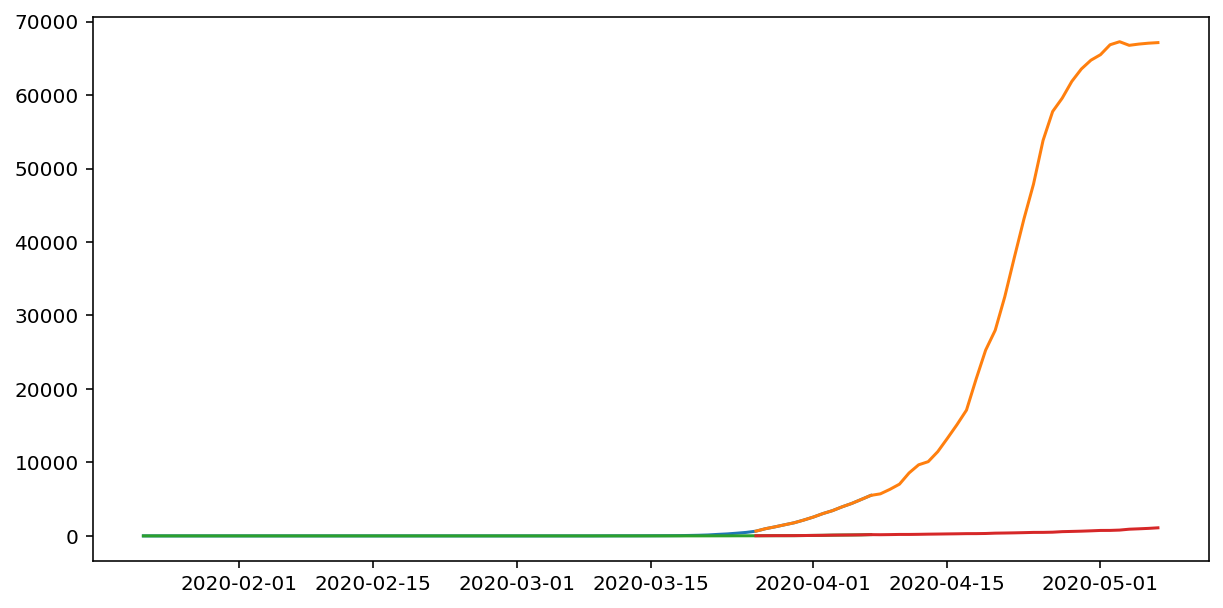

Iowa


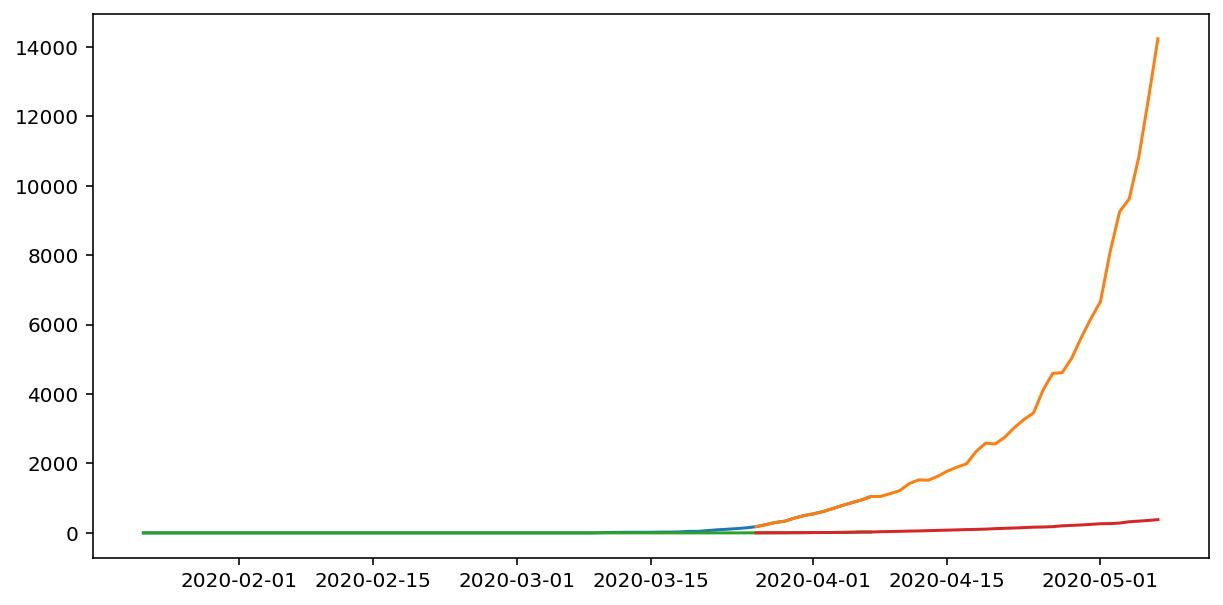

Kansas


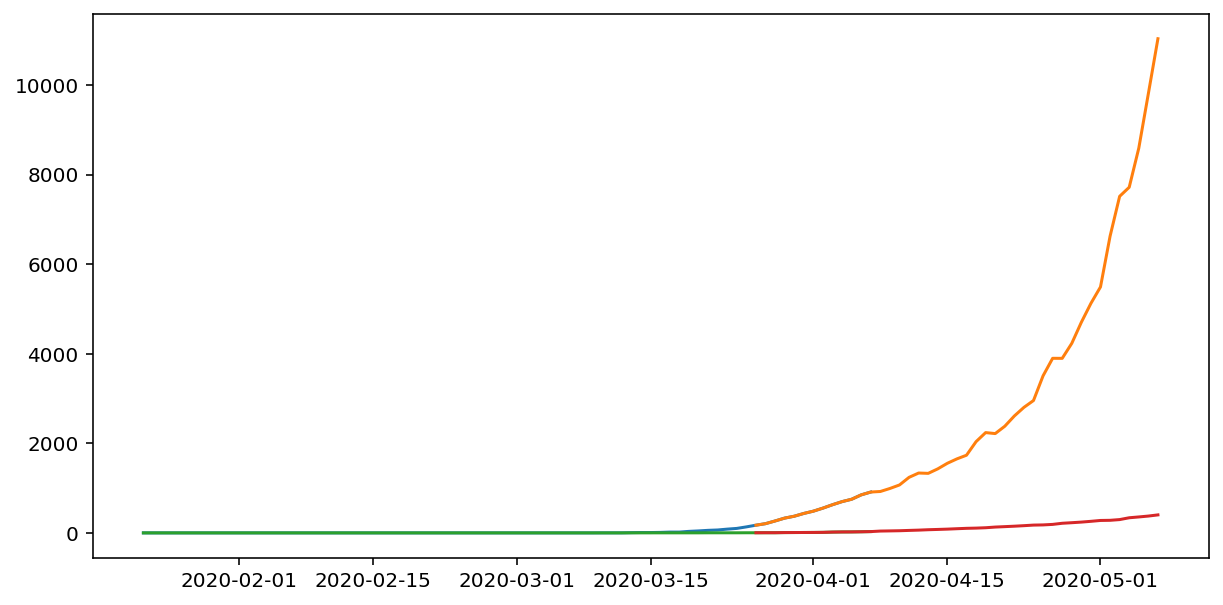

Kentucky


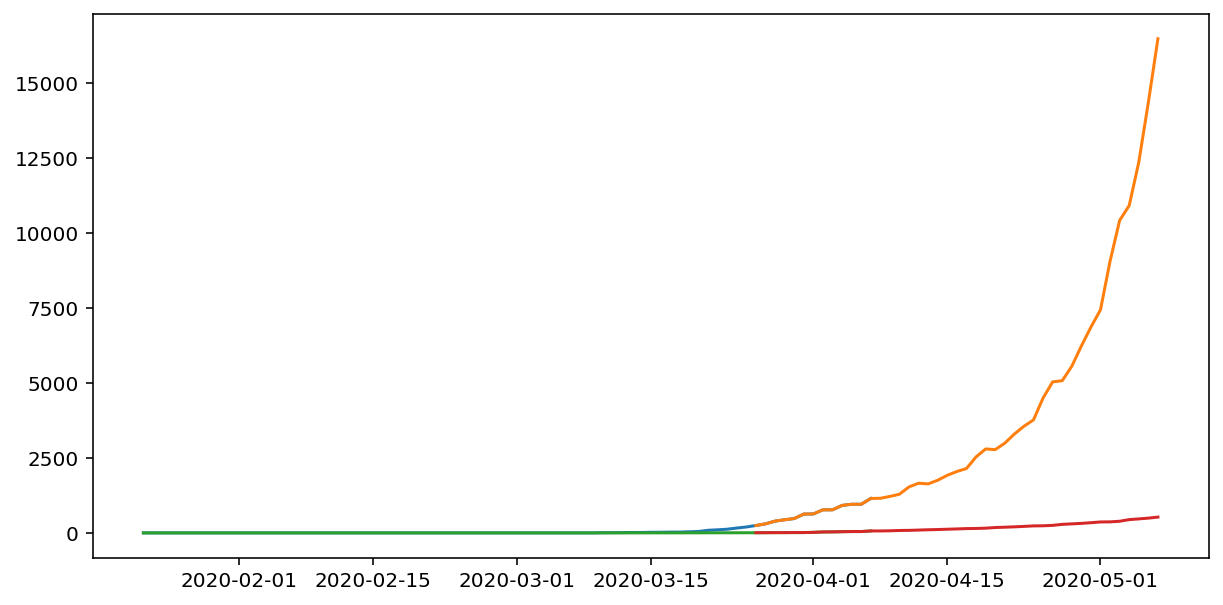

Louisiana


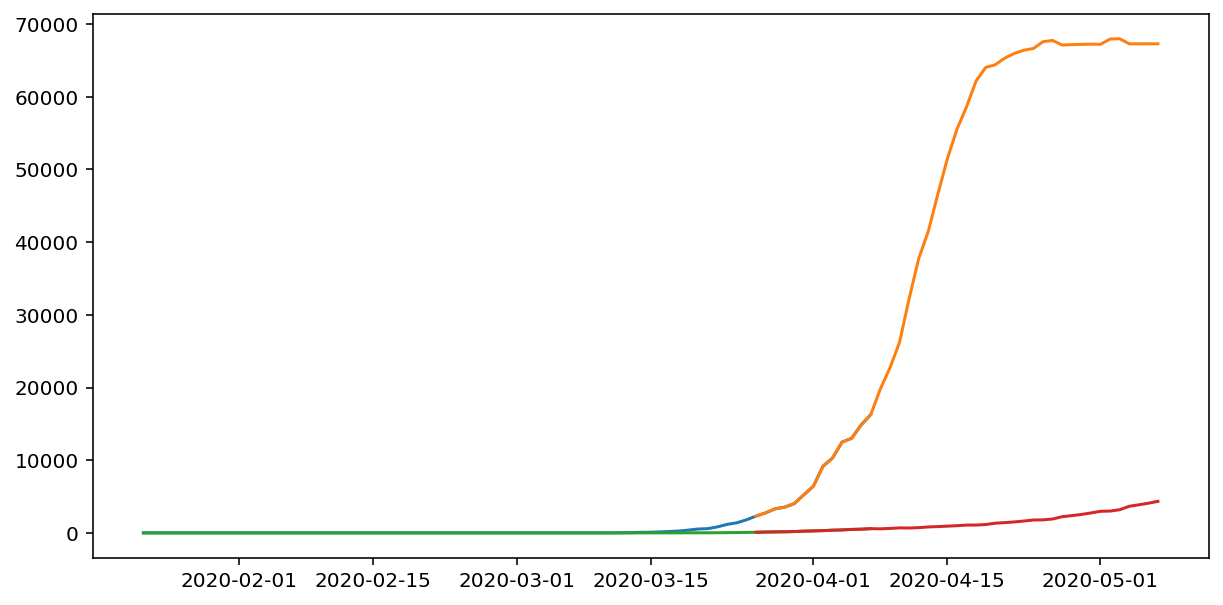

Maine


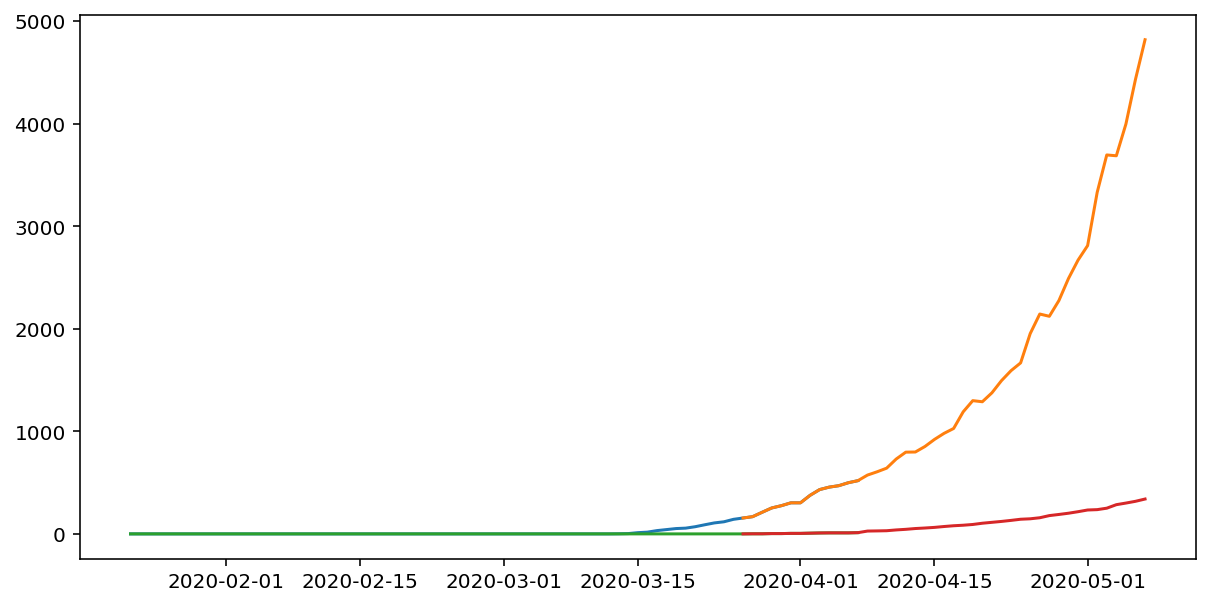

Maryland


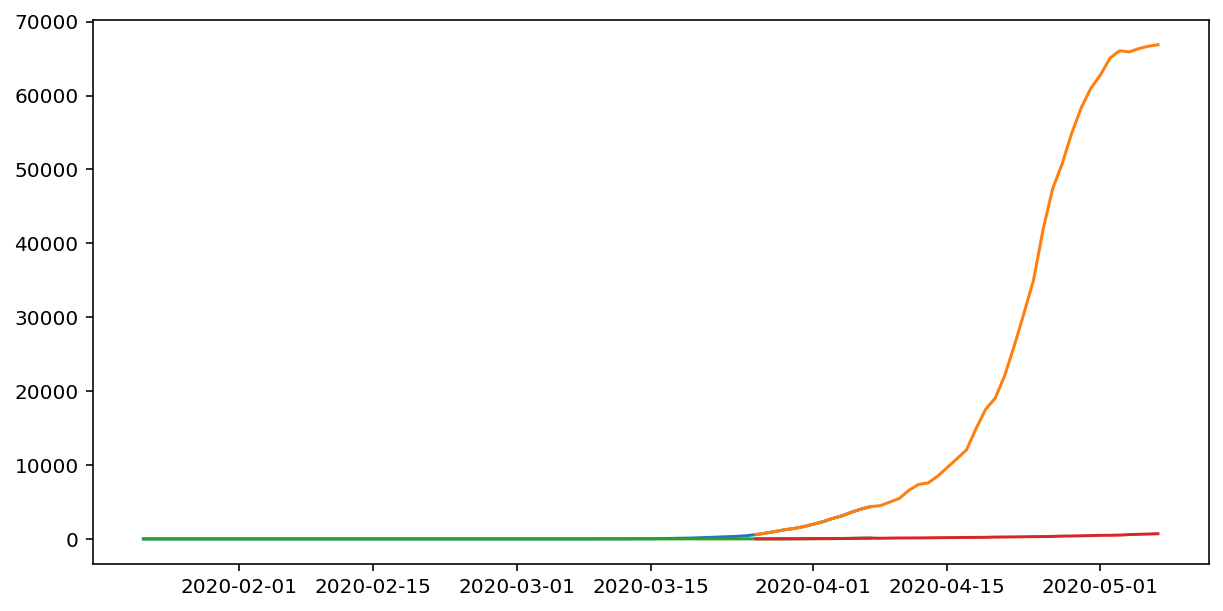

Massachusetts


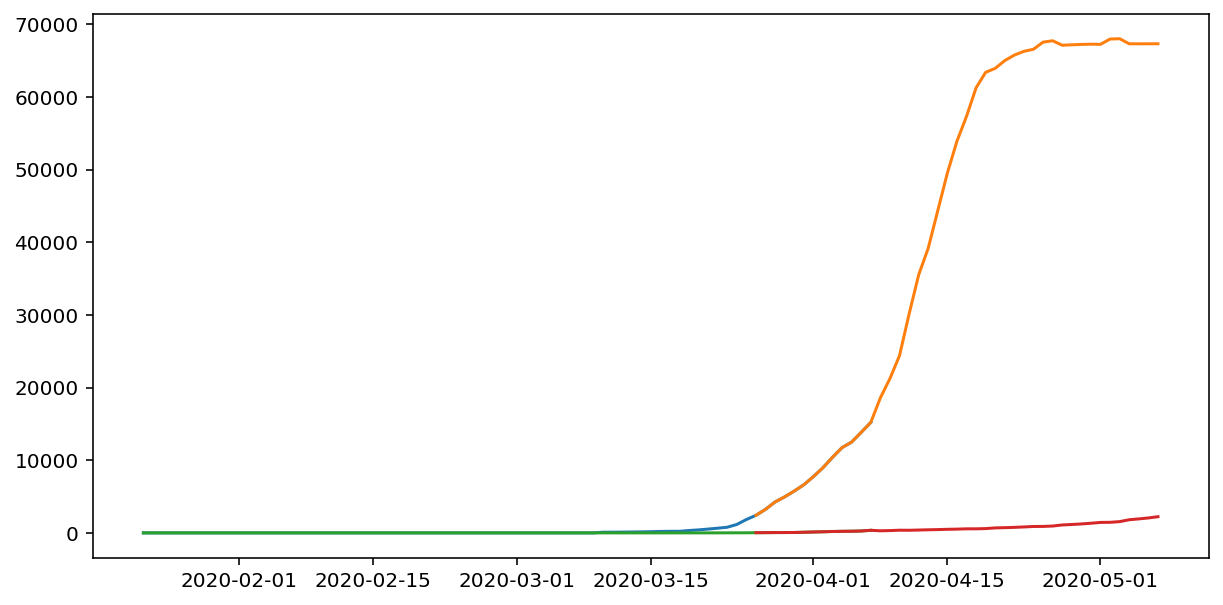

Michigan


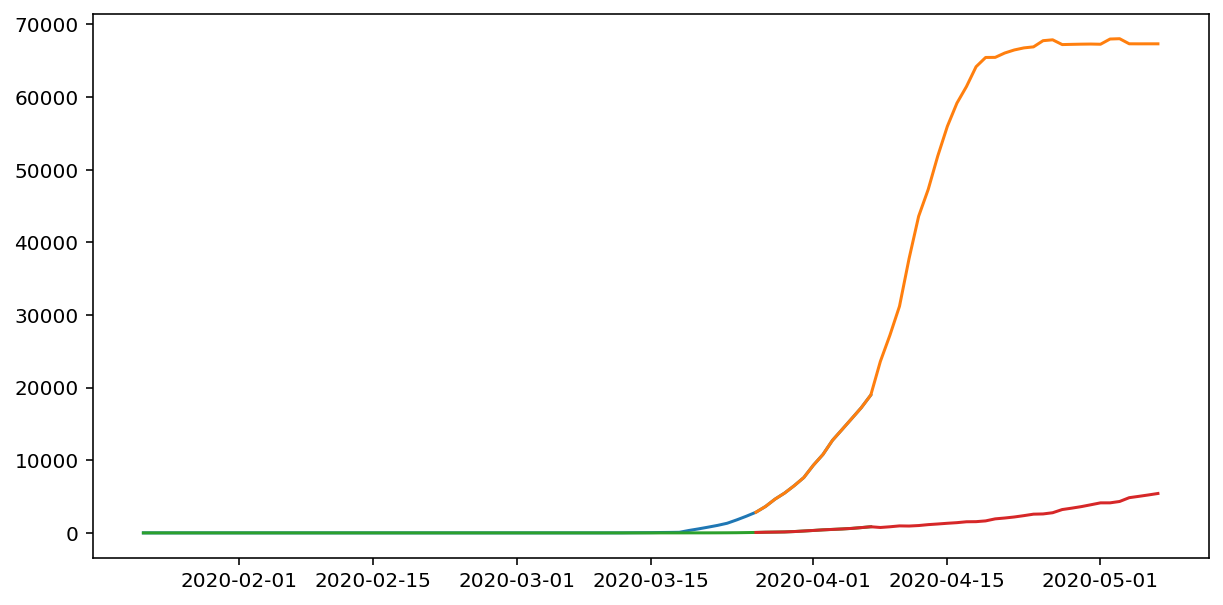

Minnesota


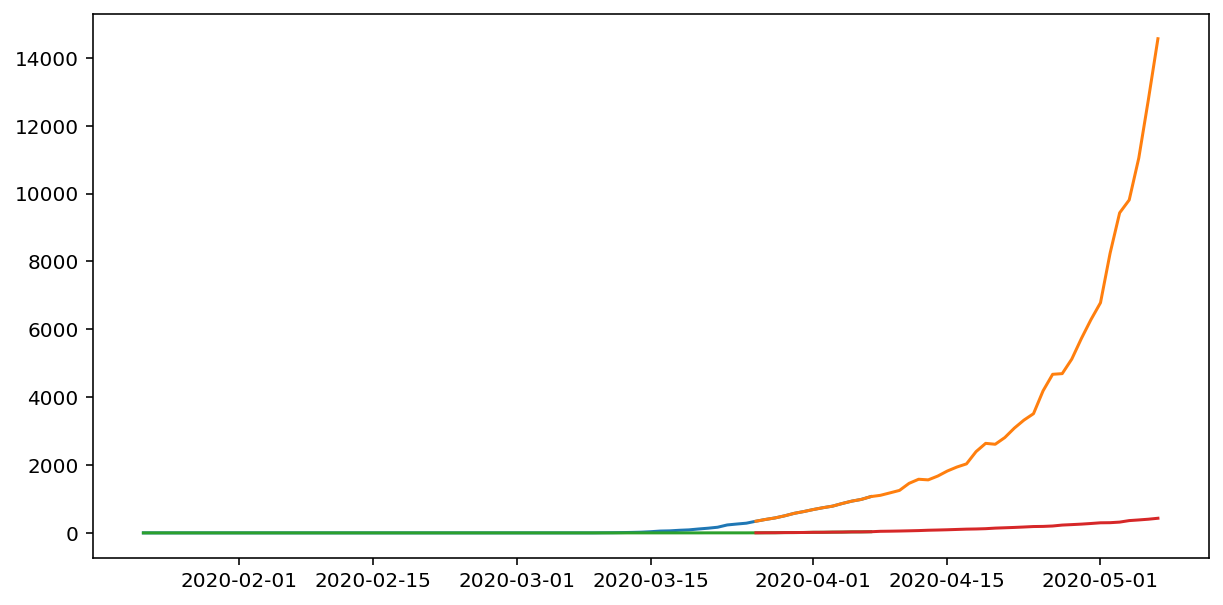

Mississippi


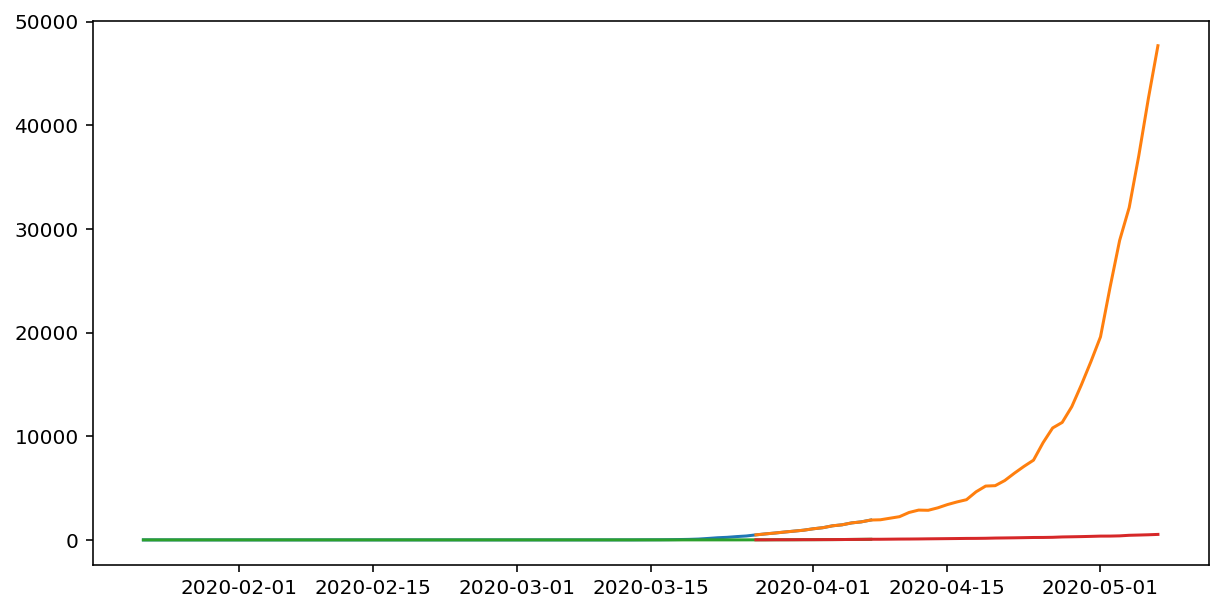

Missouri


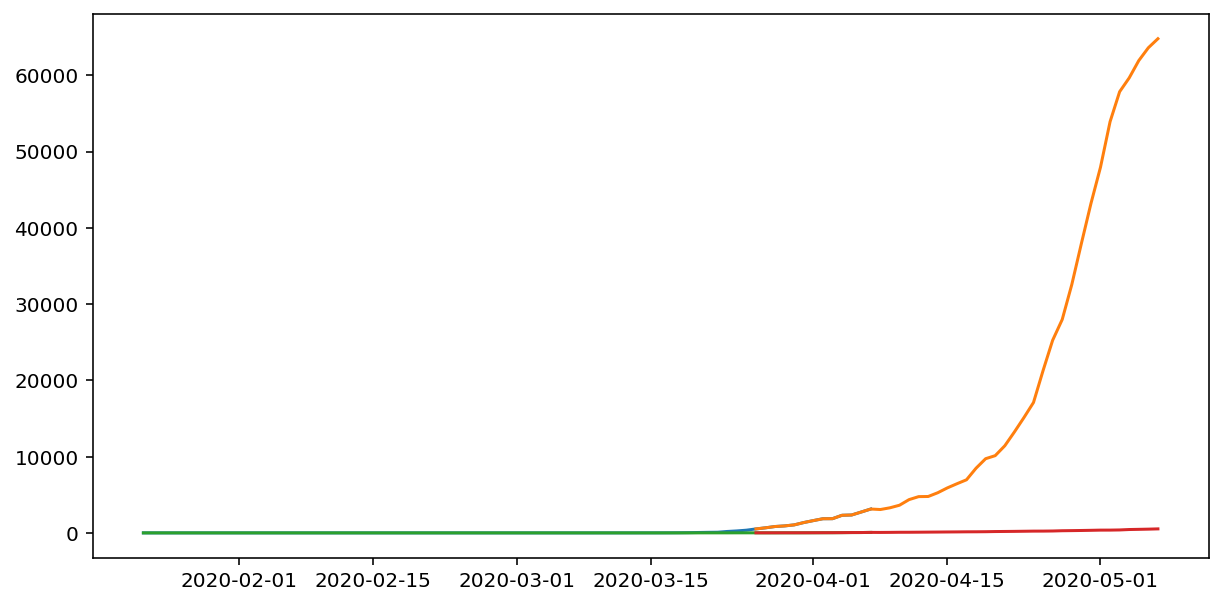

Montana


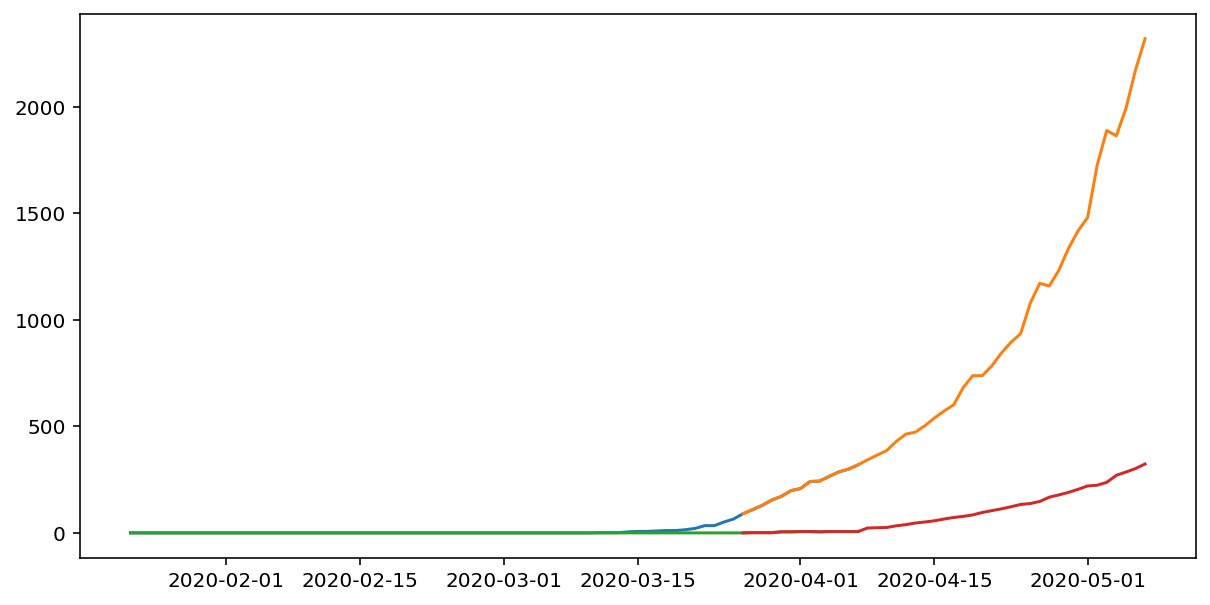

Nebraska


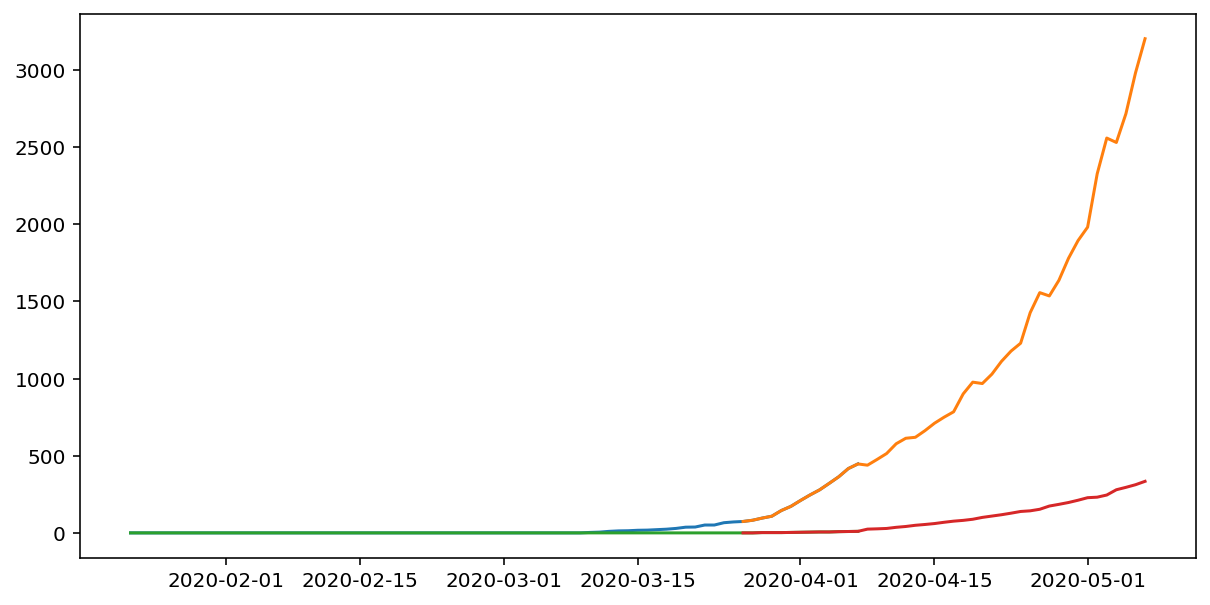

Nevada


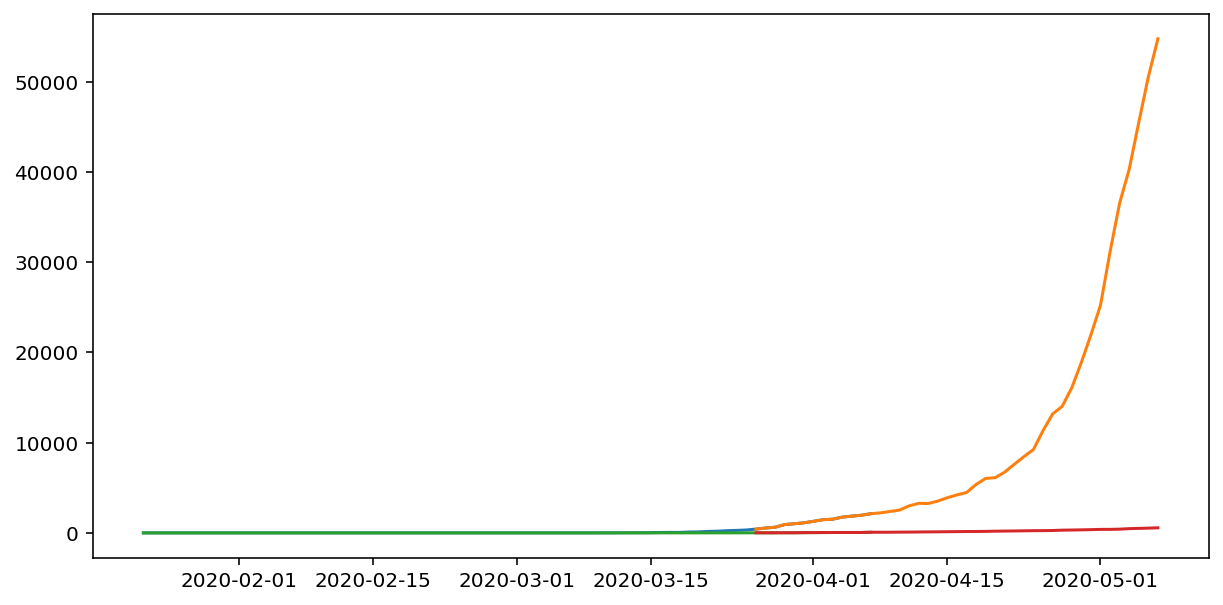

New Hampshire


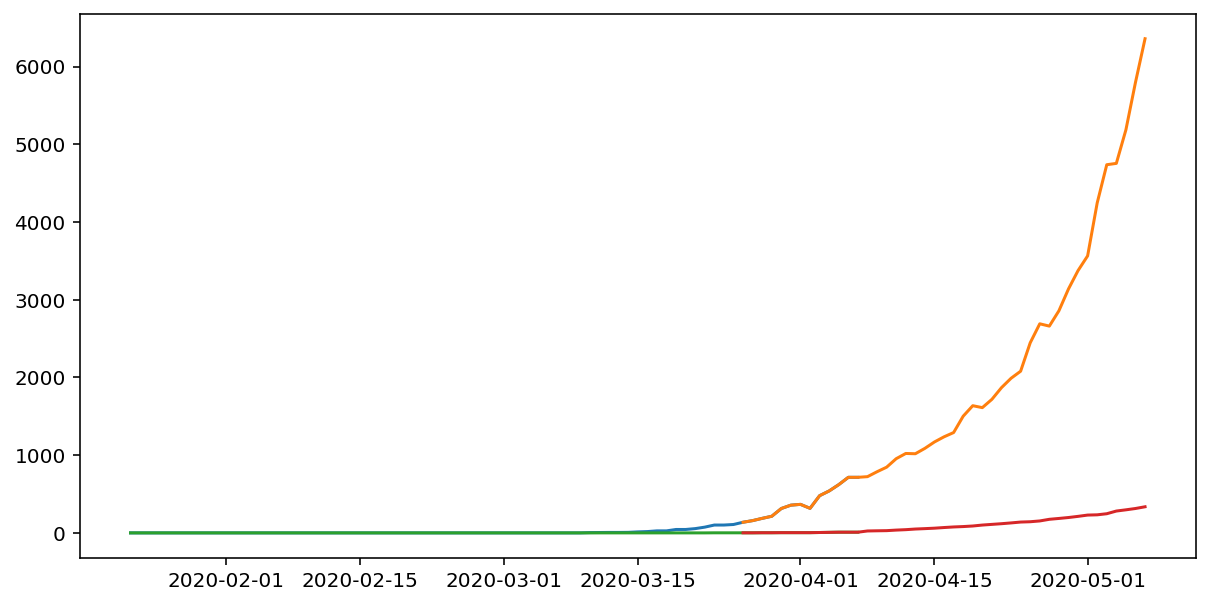

New Jersey


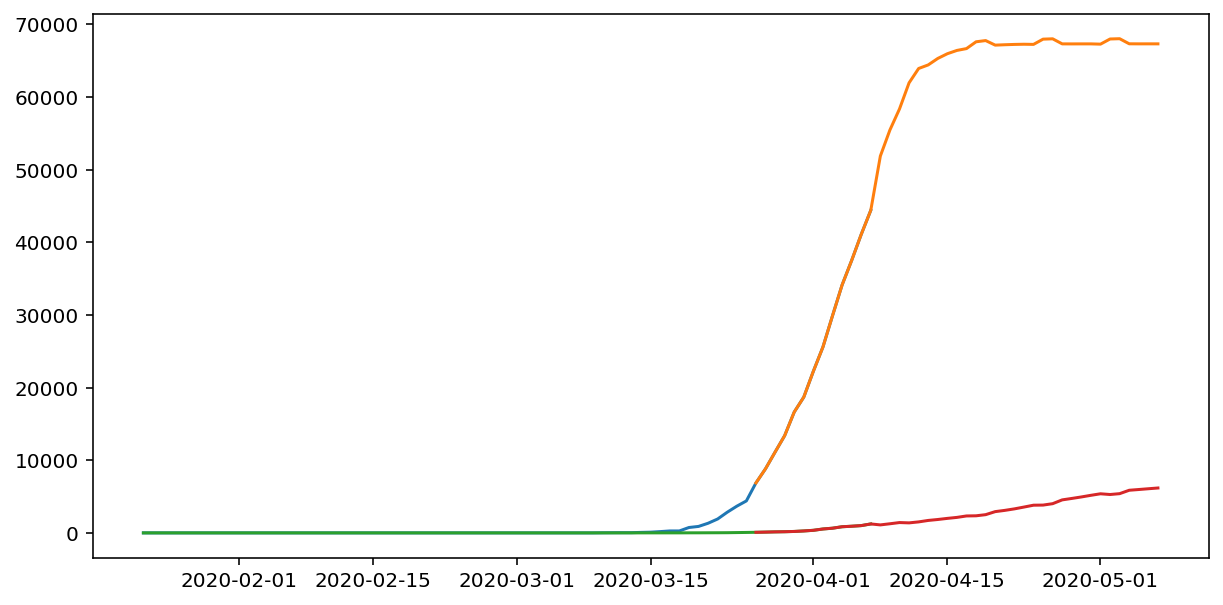

New Mexico


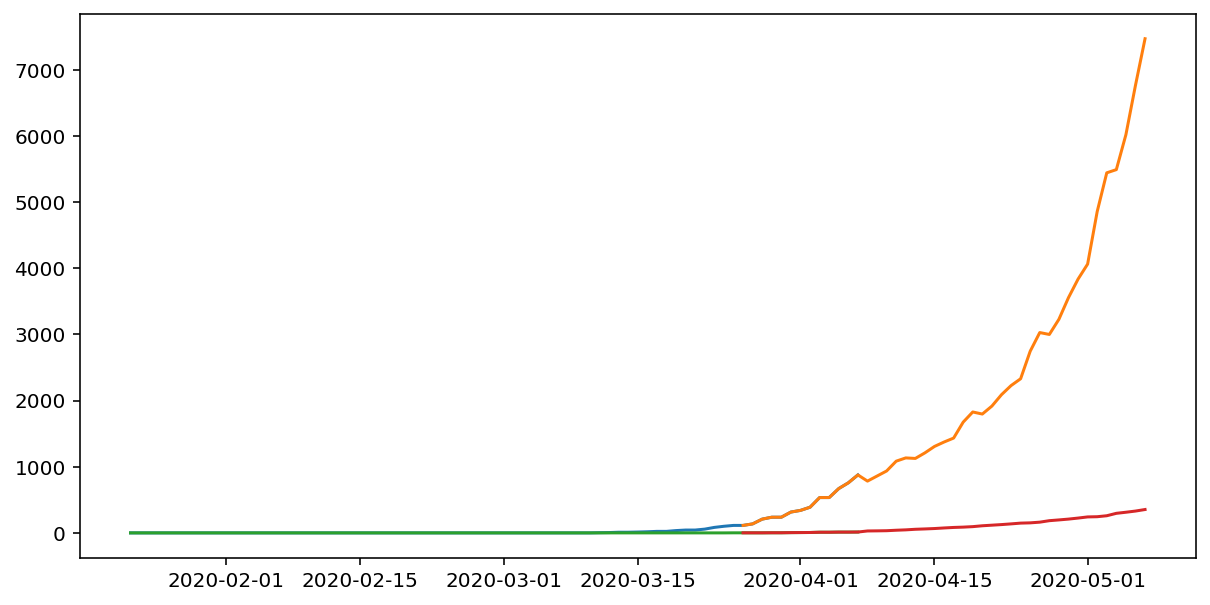

New York


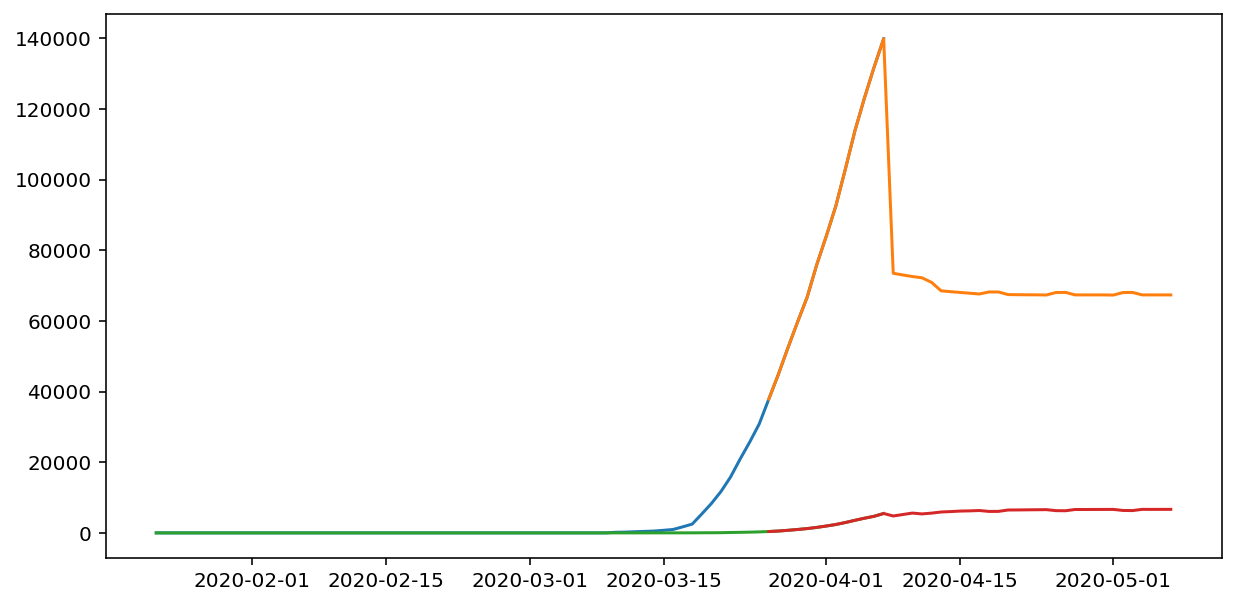

North Carolina


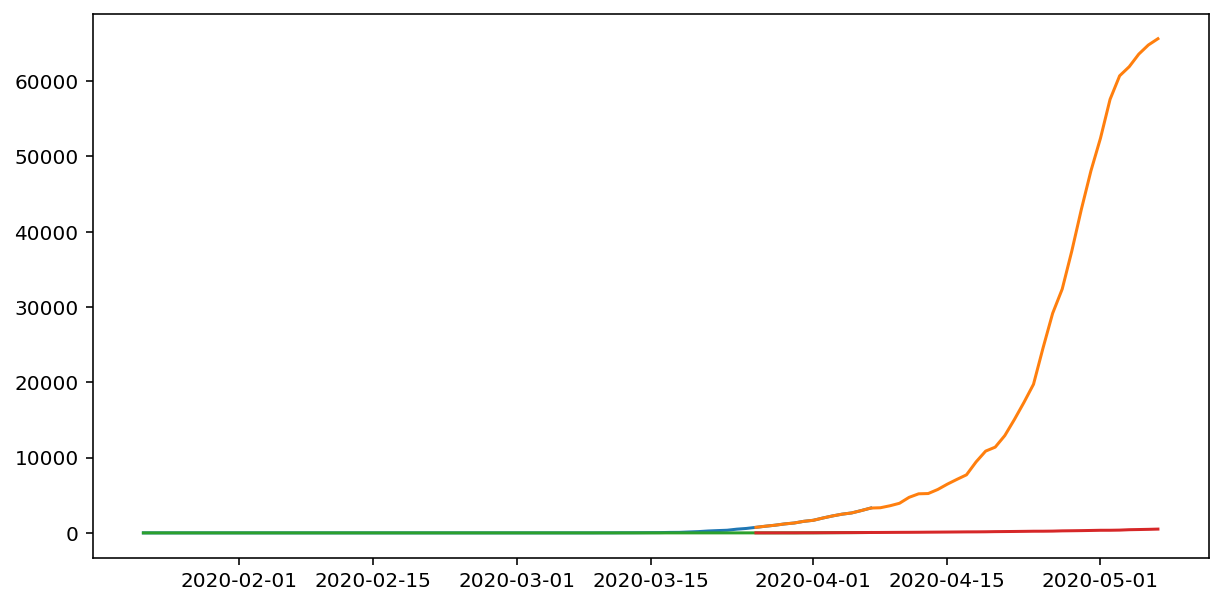

North Dakota


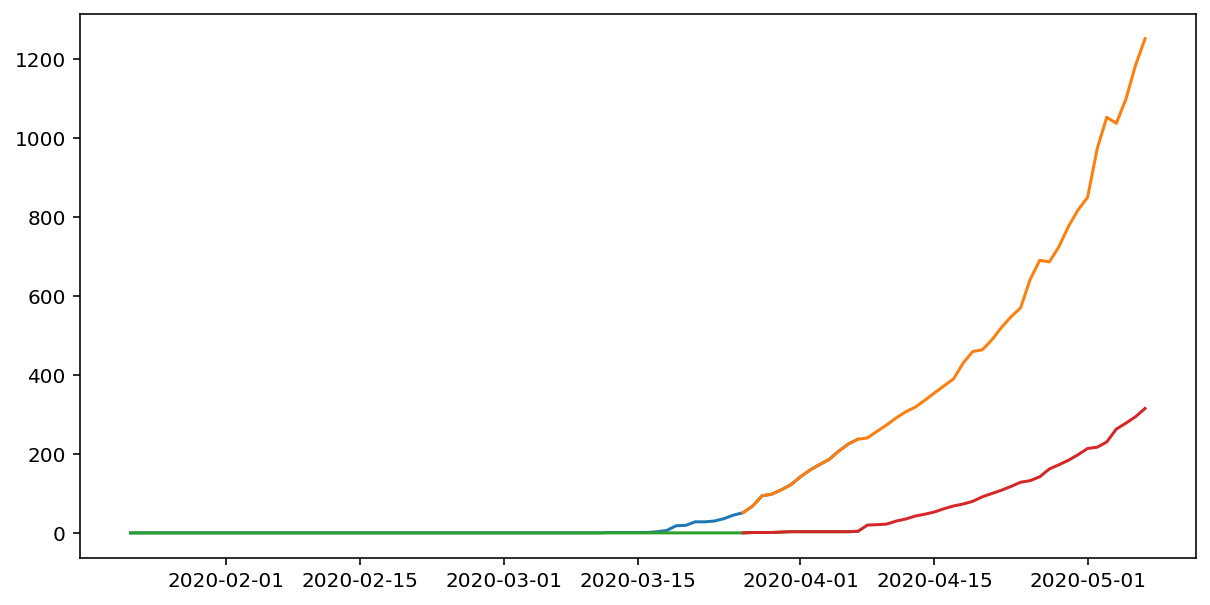

Ohio


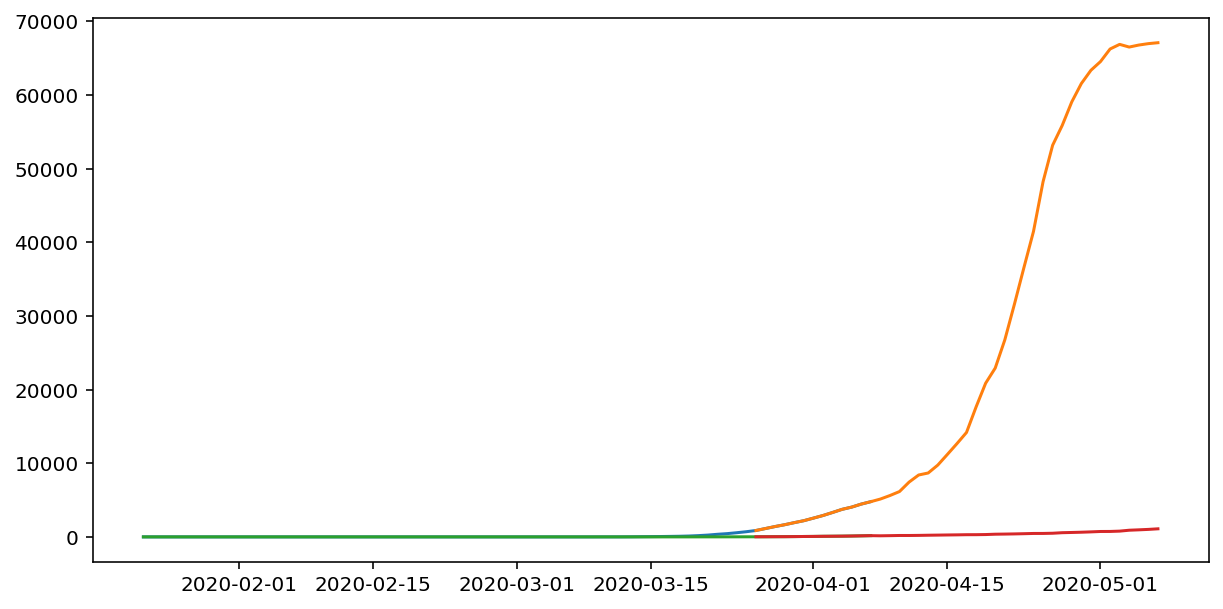

Oklahoma


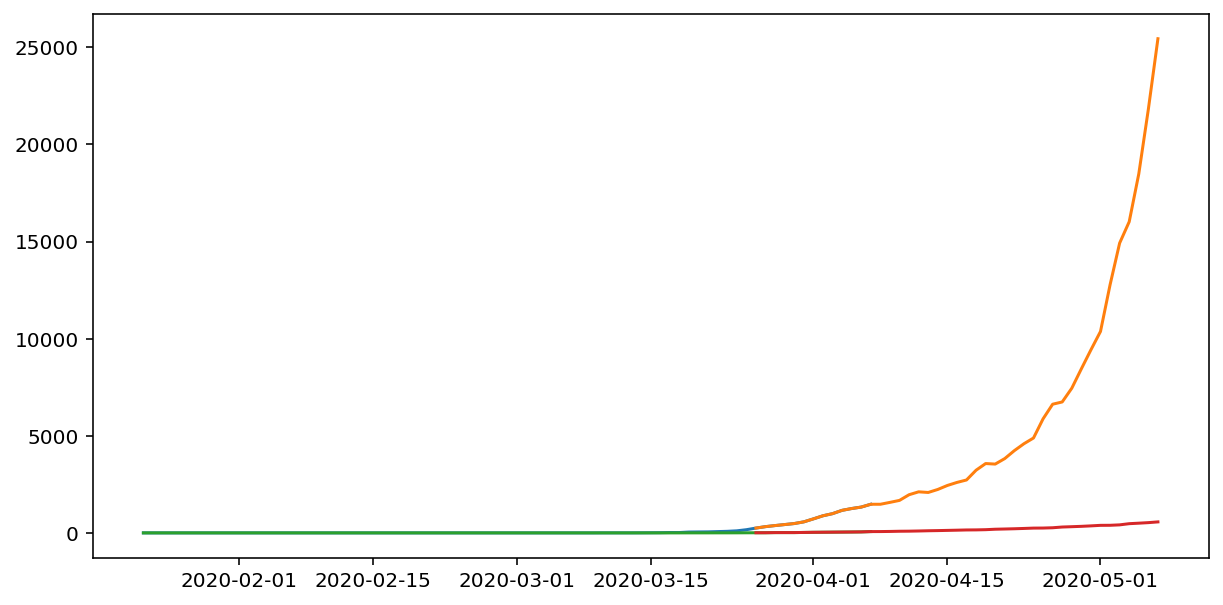

Oregon


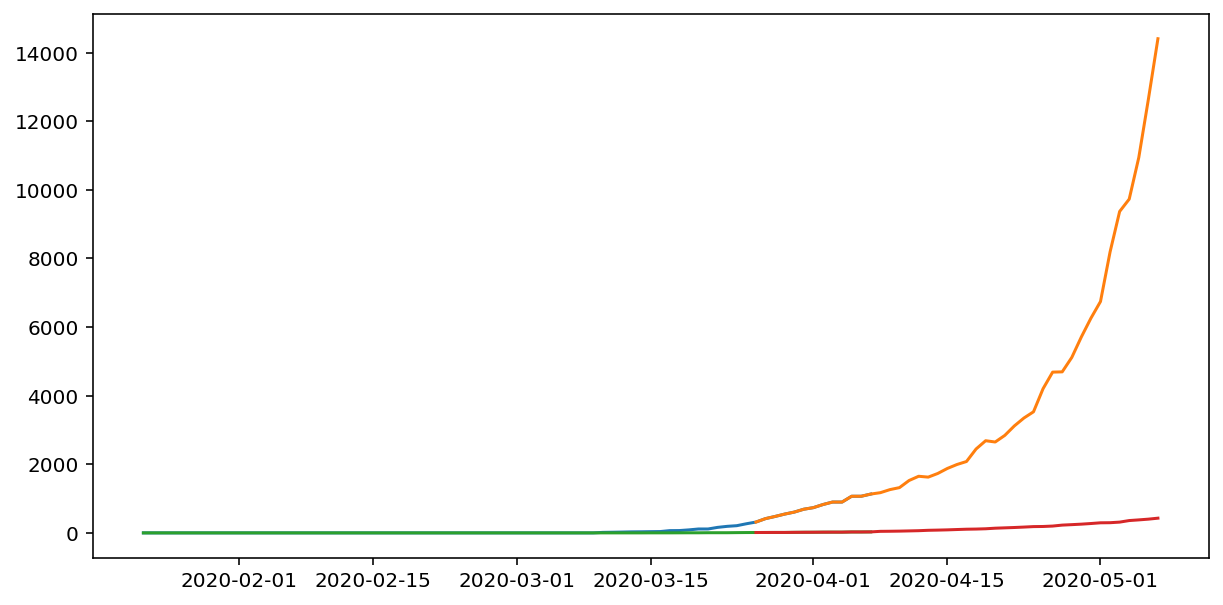

Pennsylvania


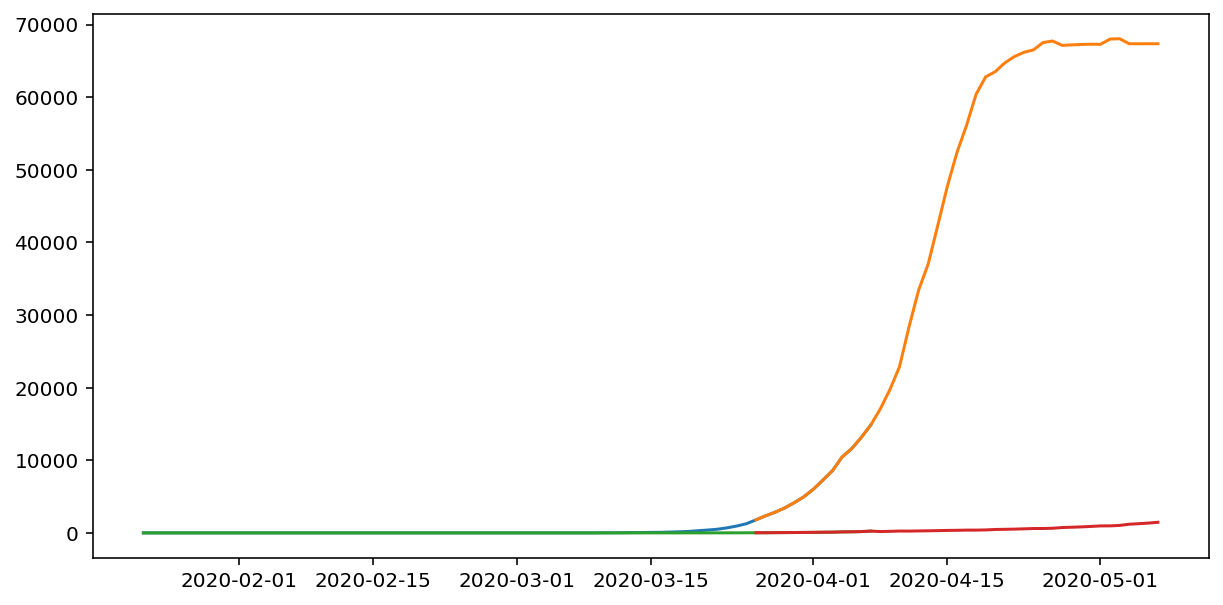

Puerto Rico


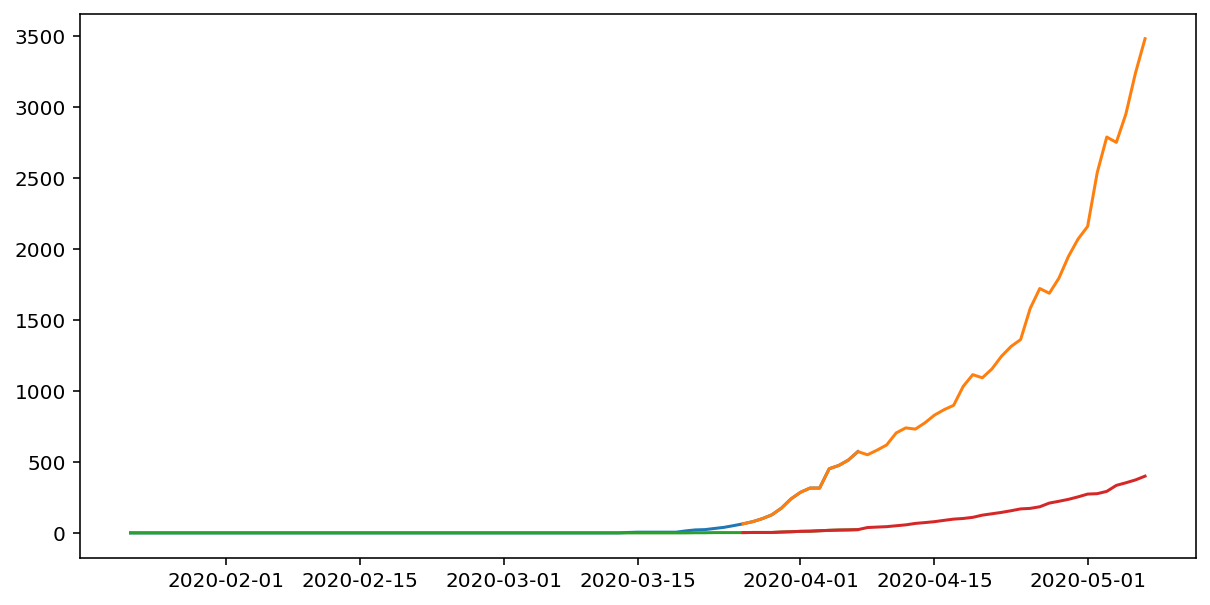

Rhode Island


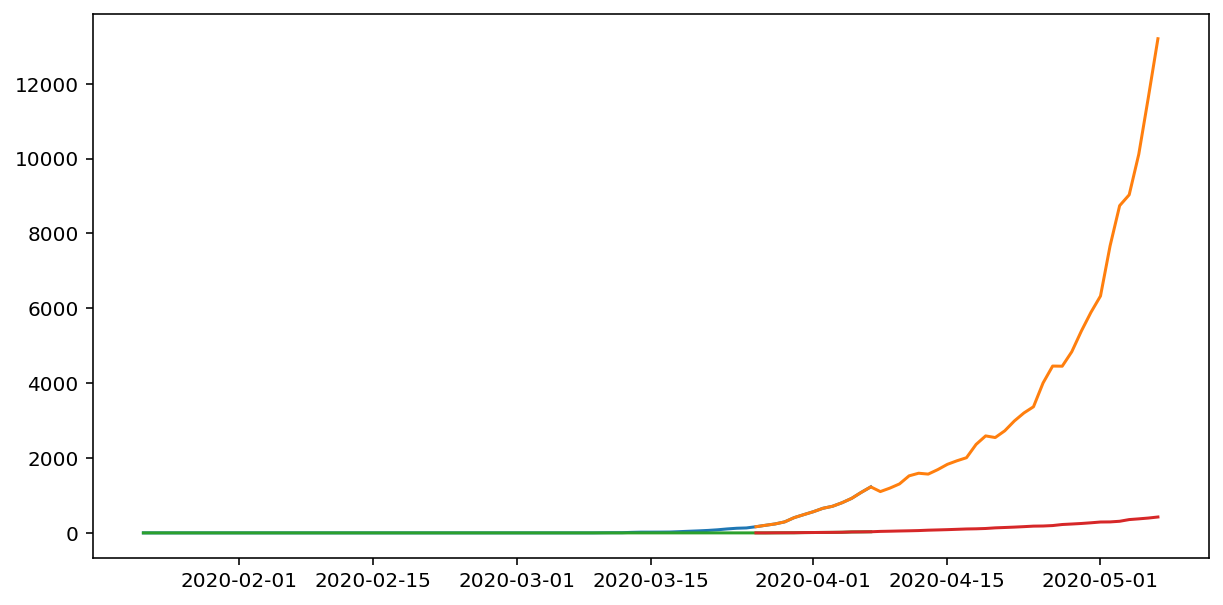

South Carolina


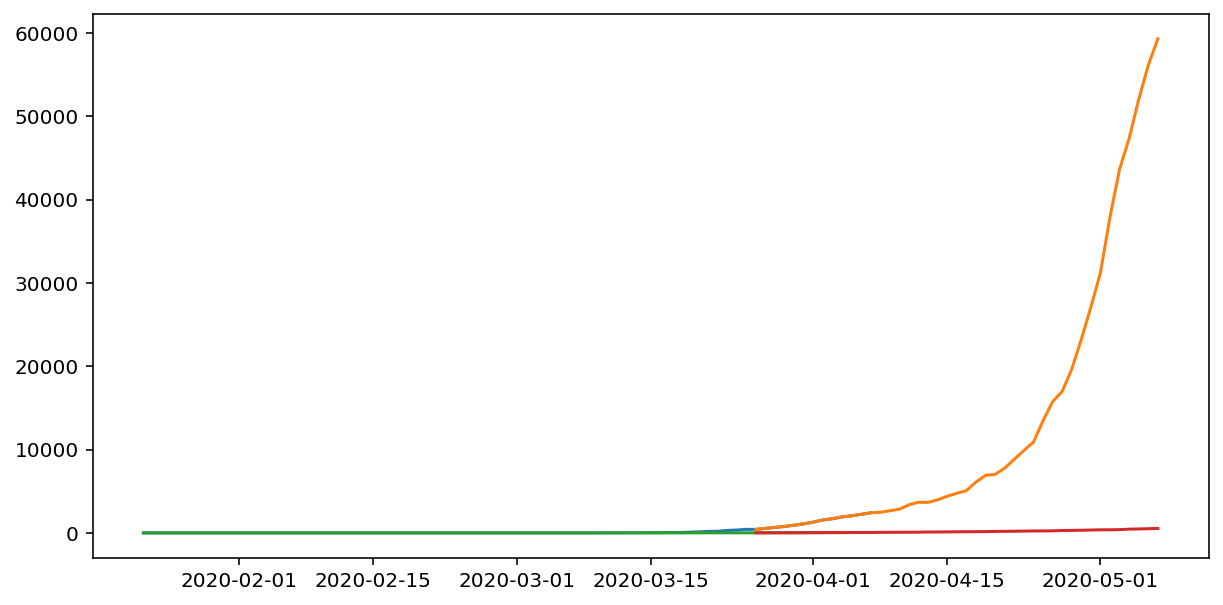

South Dakota


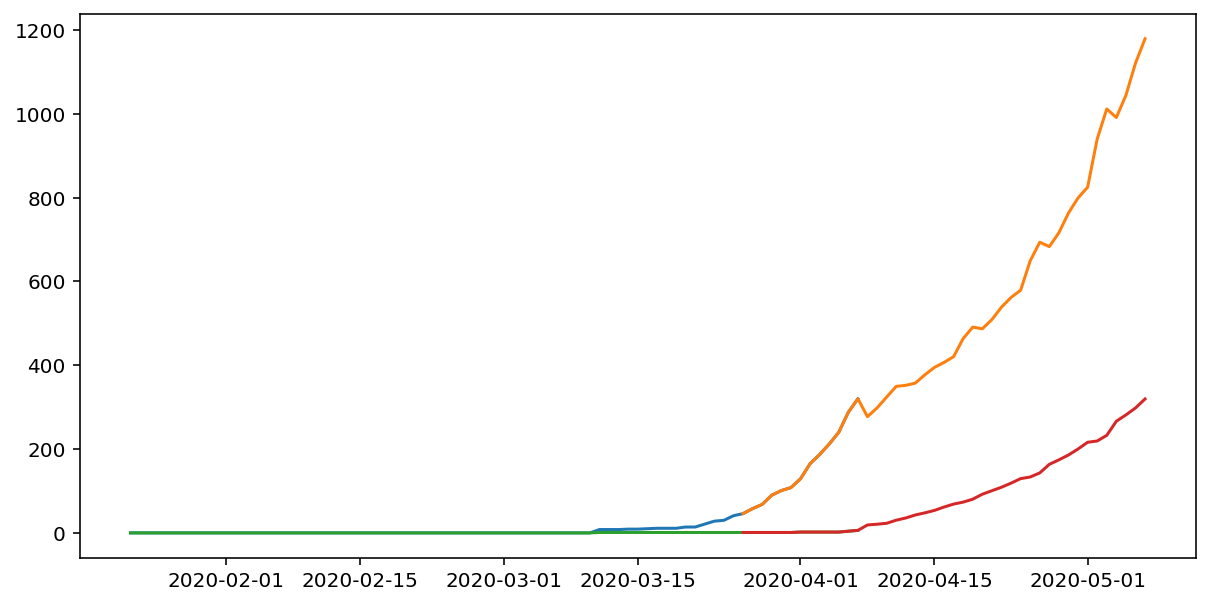

Tennessee


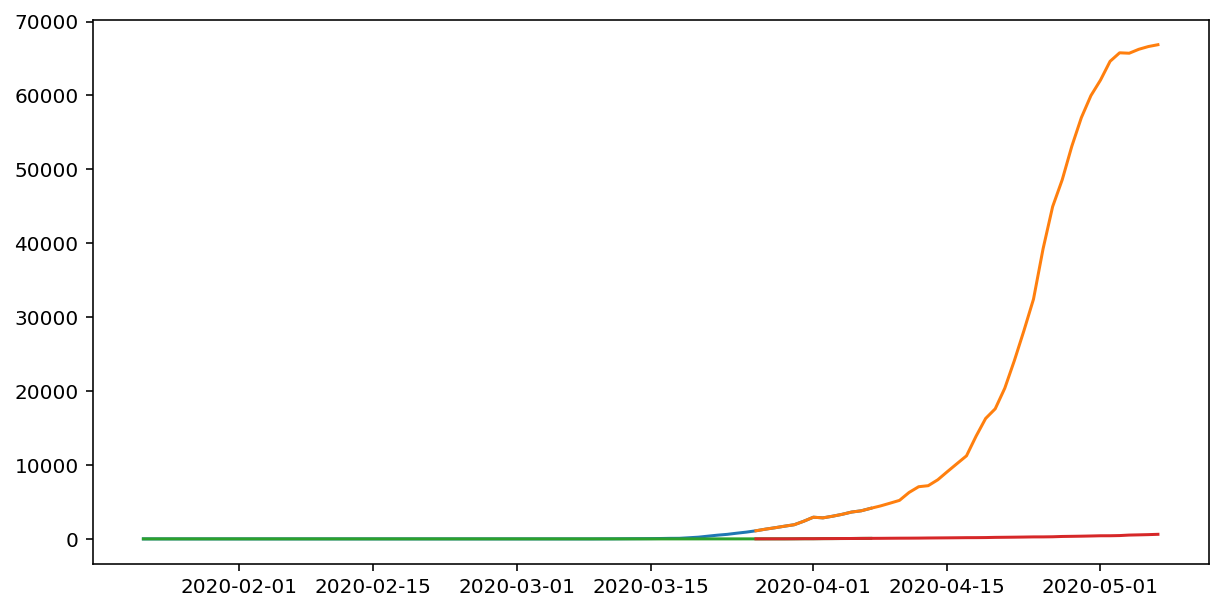

Texas


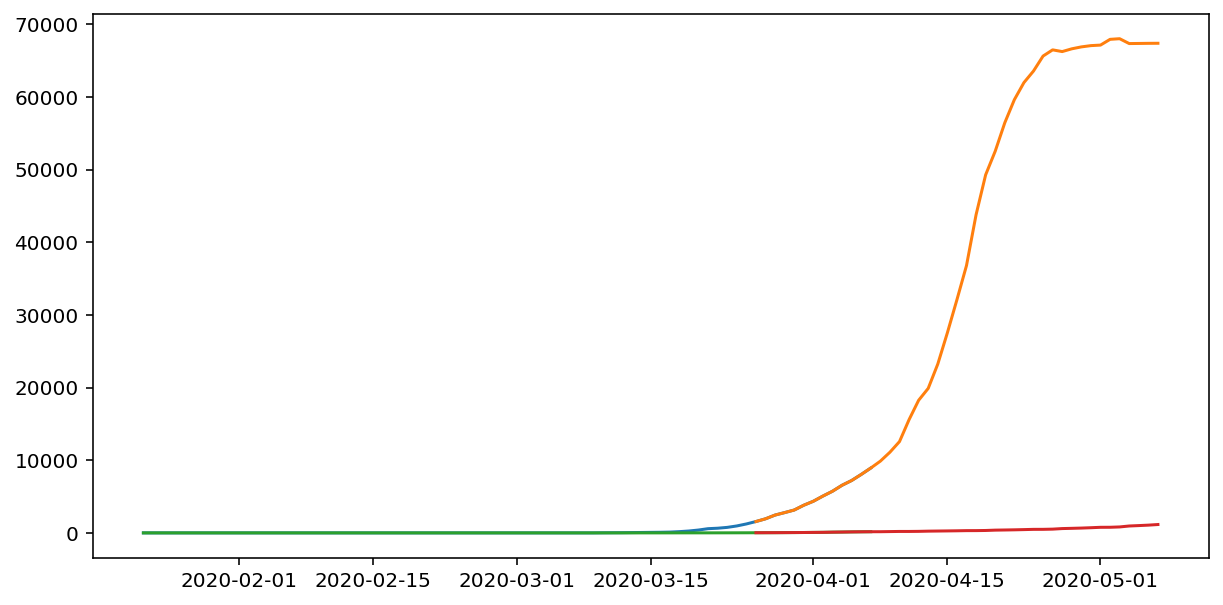

Utah


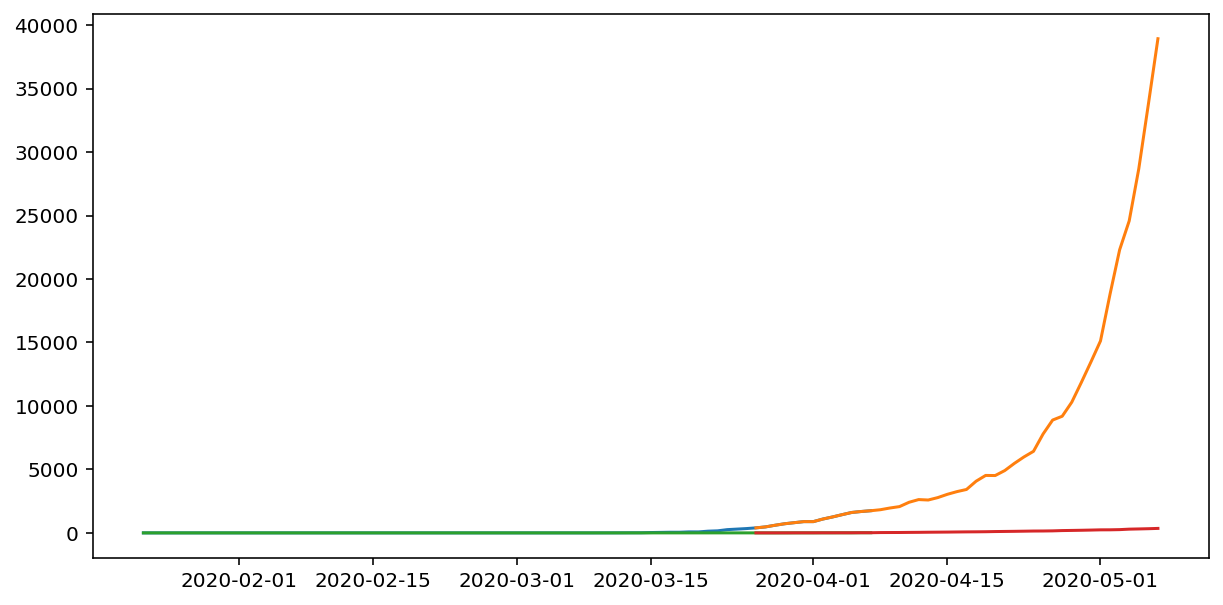

Vermont


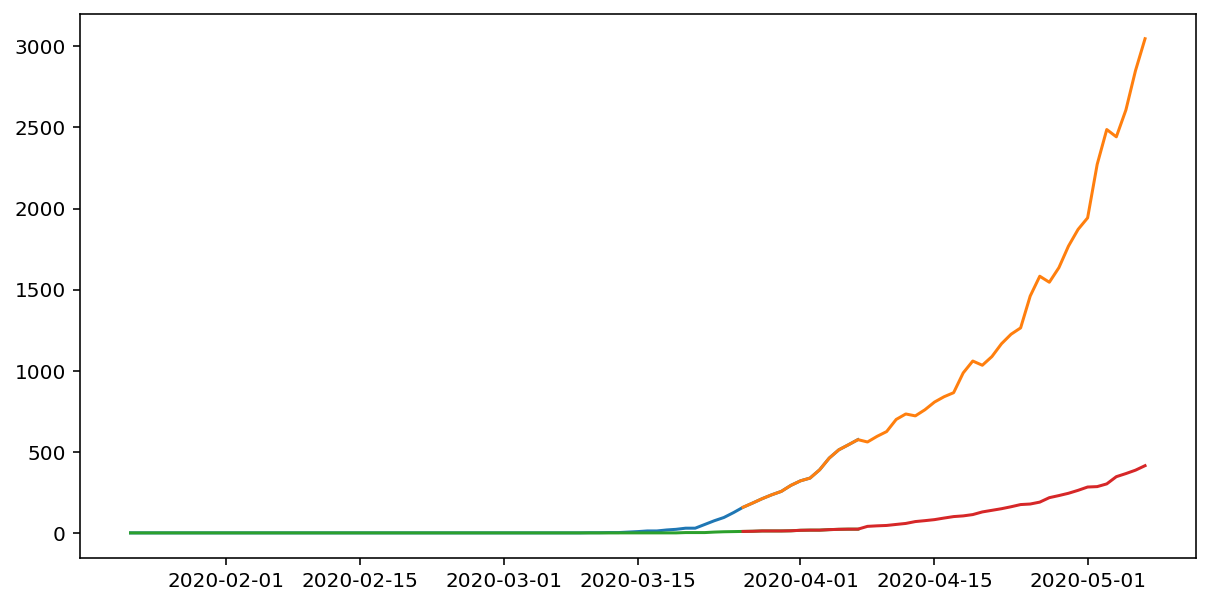

Virgin Islands


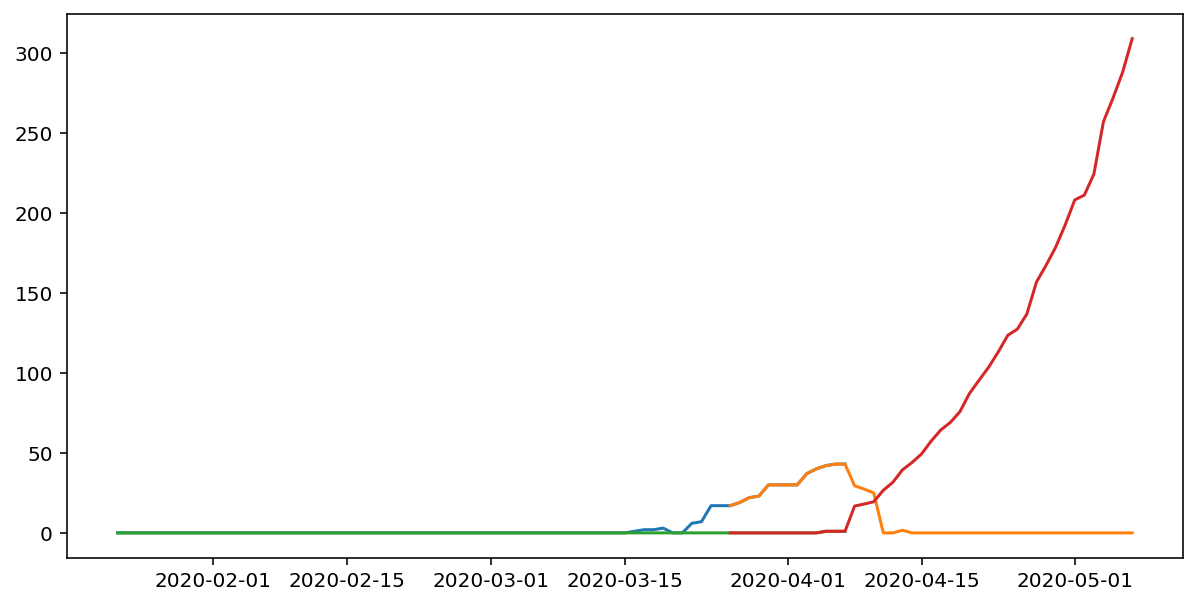

Virginia


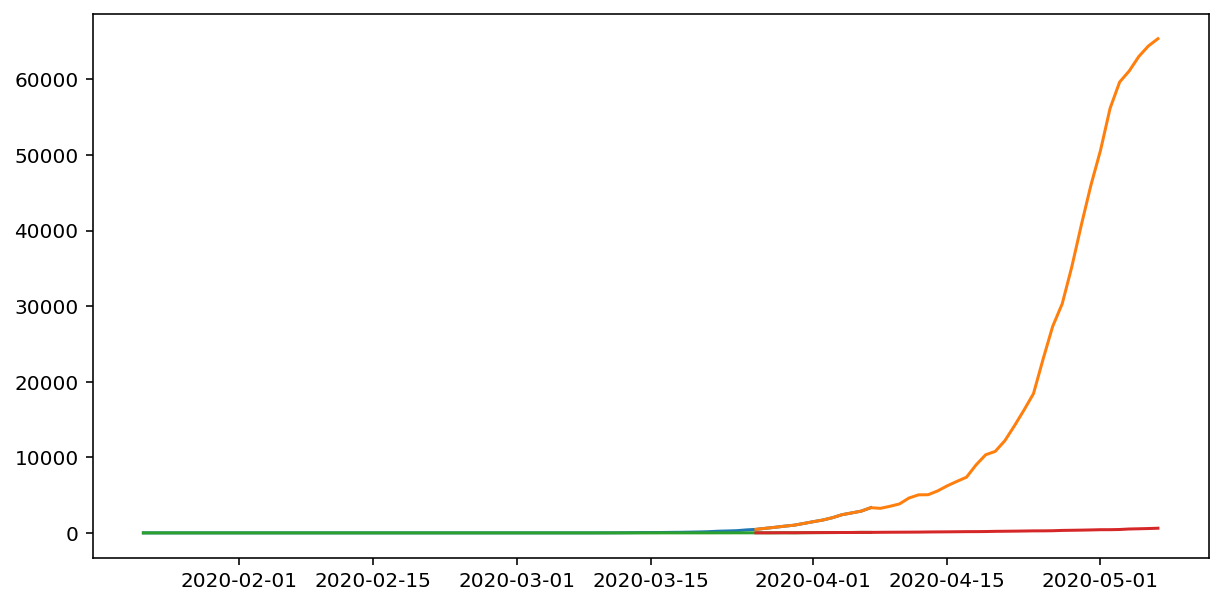

Washington


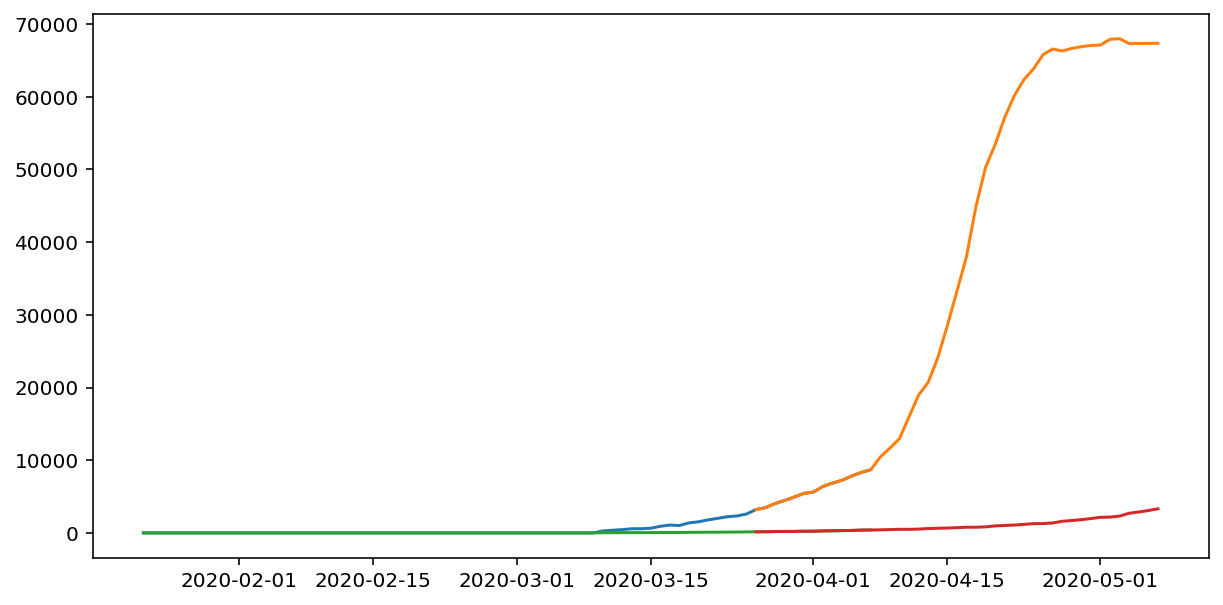

West Virginia


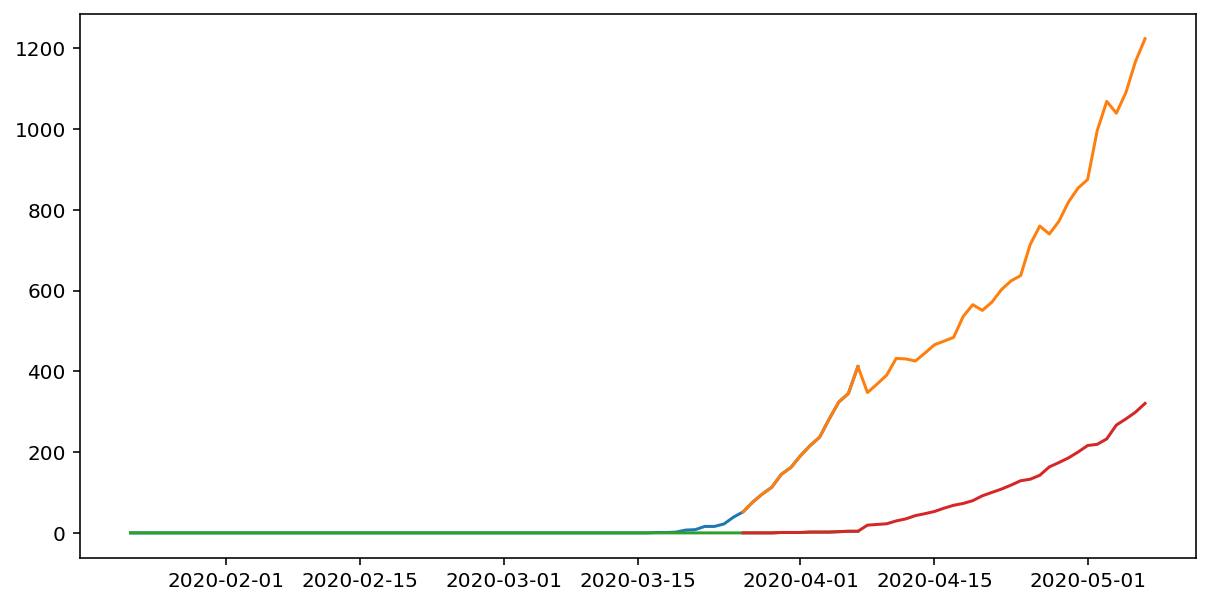

Wisconsin


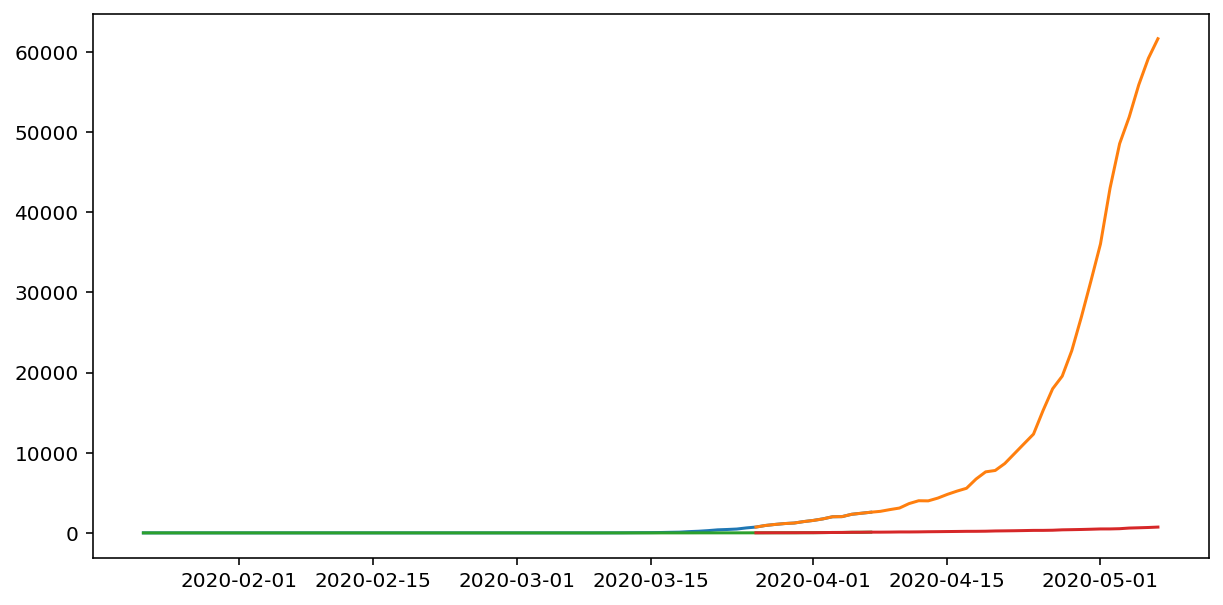

Wyoming


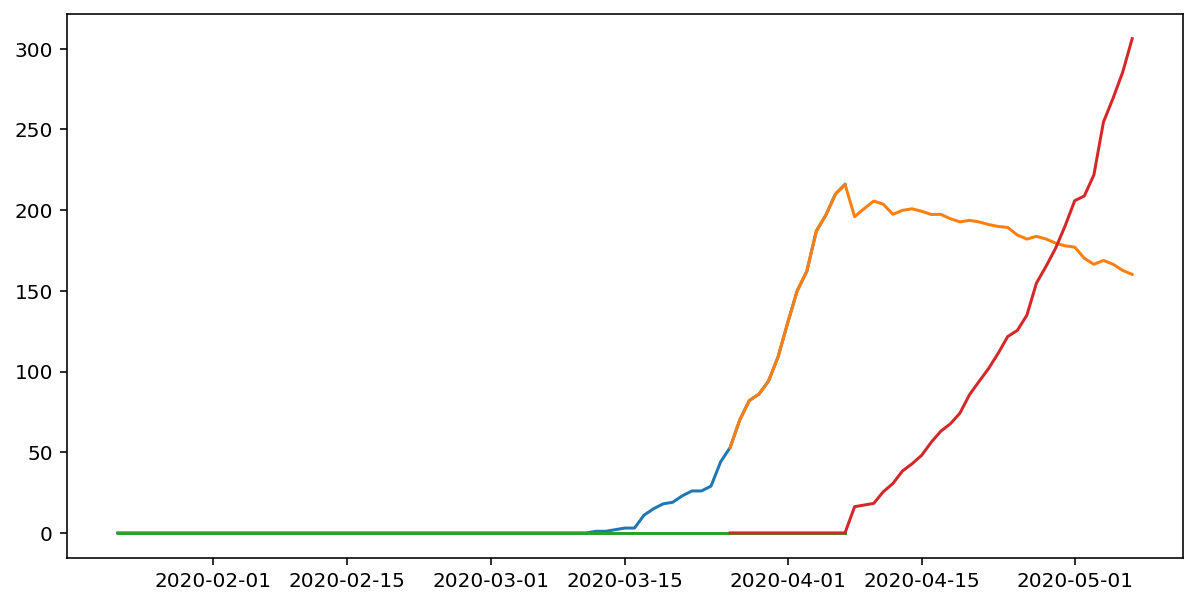

In [53]:
country = 'US'#
for i in test_data[test_data['Country_Region']==country]['Province_State'].unique().tolist():
    fig = plt.figure(figsize=(10,5))
    print(i)
    data_train = train[(train['Country_Region']==country) & (train['Province_State']==i)]
    data_test = test_data[(test_data['Country_Region']==country) & (test_data['Province_State']==i)]
    plt.plot(data_train['Date'], data_train['ConfirmedCases'])
    plt.plot(data_test['Date'], data_test['ConfirmedCases'])
    plt.plot(data_train['Date'], data_train['Fatalities'])
    plt.plot(data_test['Date'], data_test['Fatalities'])
    plt.show()

Australian Capital Territory


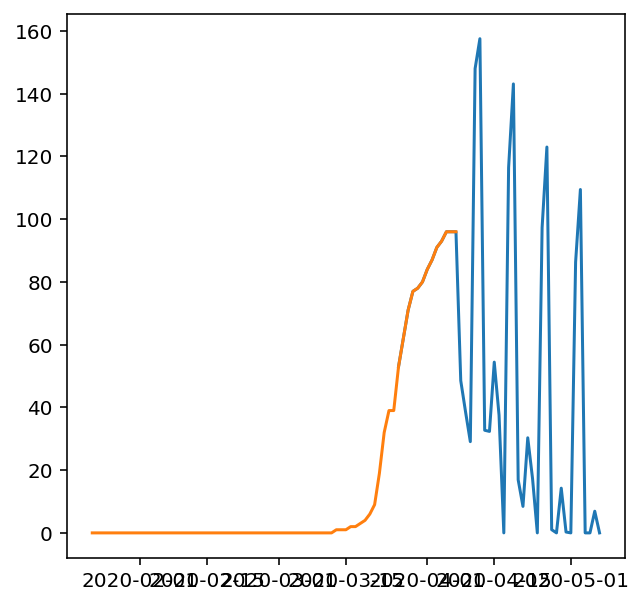

New South Wales


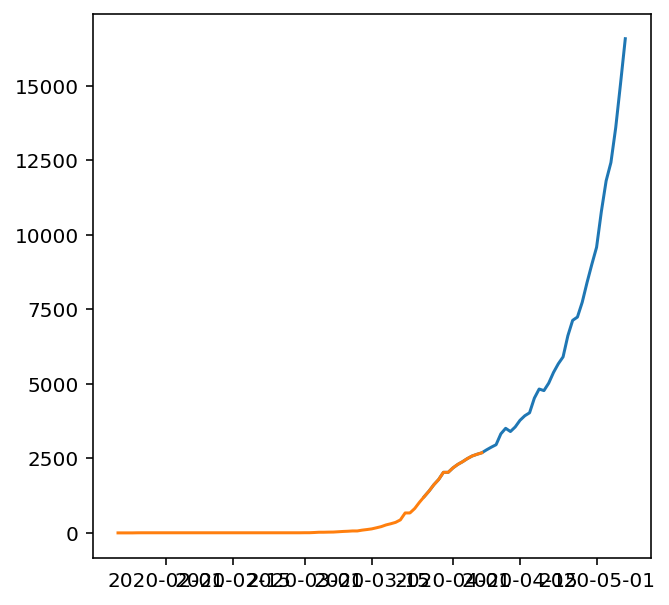

Northern Territory


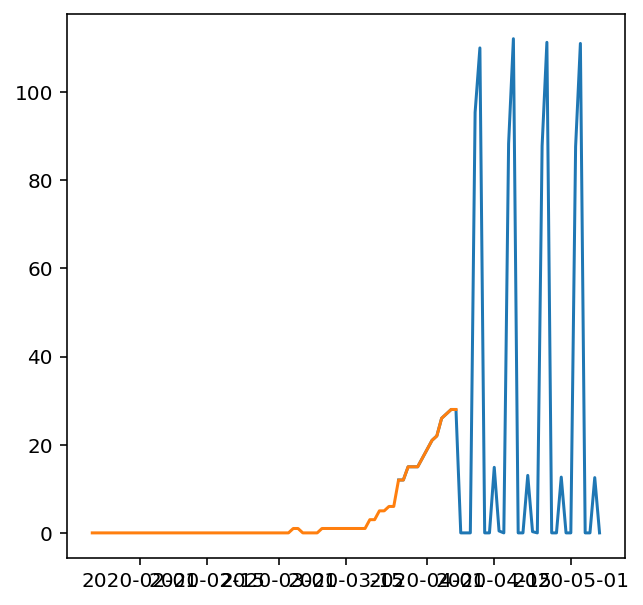

Queensland


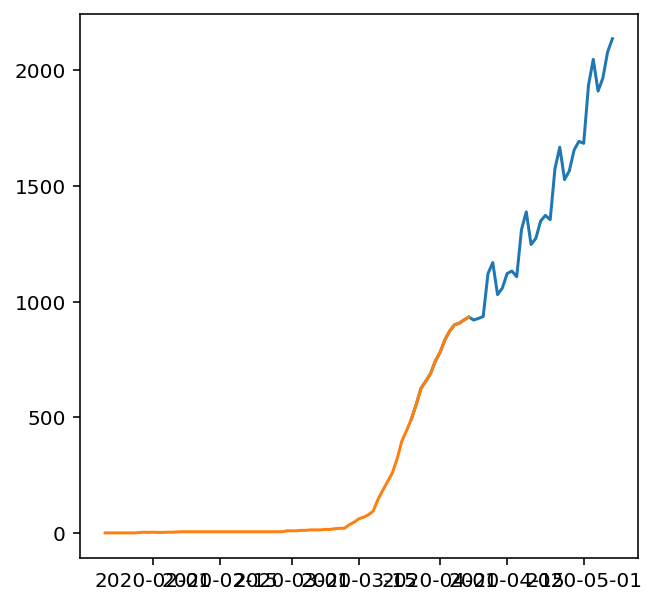

South Australia


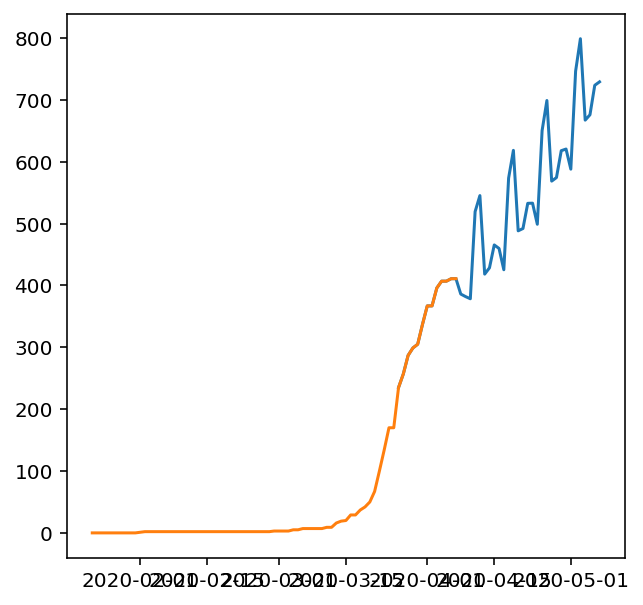

Tasmania


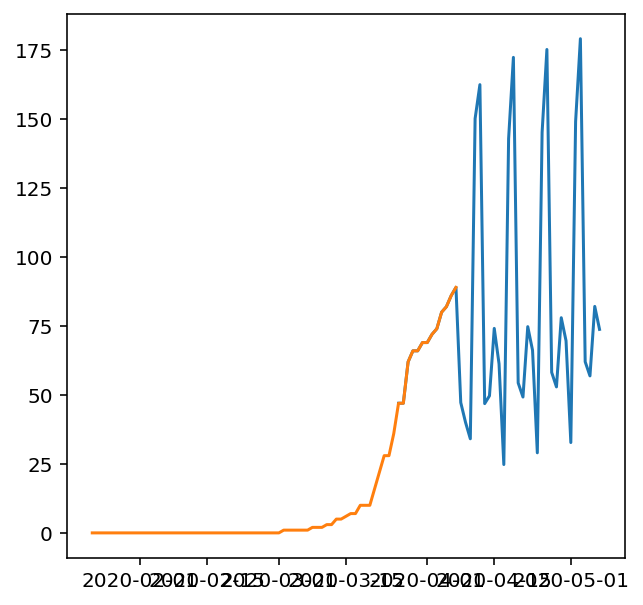

Victoria


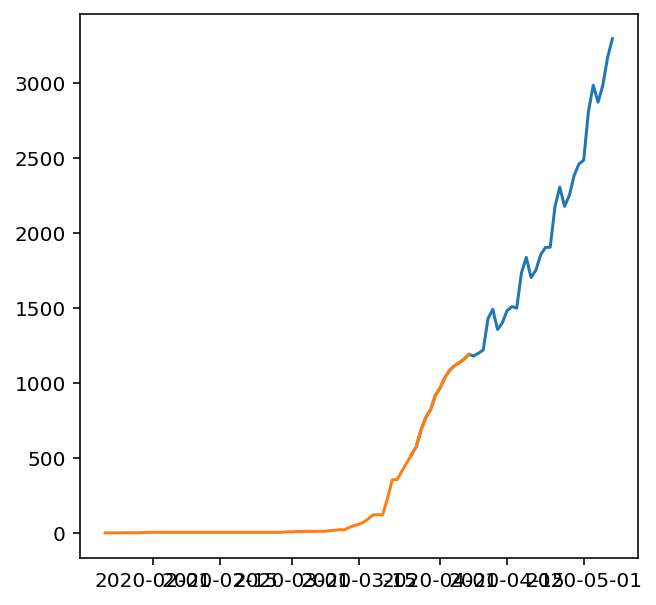

Western Australia


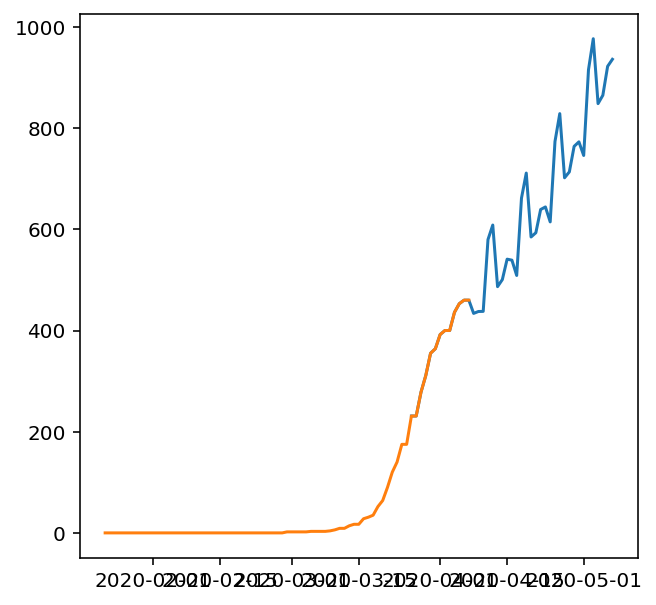

In [54]:
country = 'Australia'#
for i in test_data[test_data['Country_Region']==country]['Province_State'].unique().tolist():
    fig = plt.figure(figsize=(5,5))
    print(i)
    y1 = train[(train['Country_Region']==country) & (train['Province_State']==i)]['ConfirmedCases']
    x1 = train[(train['Country_Region']==country) & (train['Province_State']==i)]['Date']
    y = test_data[(test_data['Country_Region']==country) & (test_data['Province_State']==i)]['ConfirmedCases']
    x = test_data[(test_data['Country_Region']==country) & (test_data['Province_State']==i)]['Date']

    plt.plot(x, y)
    plt.plot(x1, y1)
    plt.show()

In [ ]:
test_data.Country_Region.unique()

In [58]:
test_data[(test_data['Country_Region']==country) ]

ForecastId Province_State Country_Region       Date  days  weekend  \
5977        5978            NaN          India 2020-03-26    85        0   
5978        5979            NaN          India 2020-03-27    86        0   
5979        5980            NaN          India 2020-03-28    87        1   
5980        5981            NaN          India 2020-03-29    88        1   
5981        5982            NaN          India 2020-03-30    89        0   
5982        5983            NaN          India 2020-03-31    90        0   
5983        5984            NaN          India 2020-04-01    91        0   
5984        5985            NaN          India 2020-04-02    92        0   
5985        5986            NaN          India 2020-04-03    93        0   
5986        5987            NaN          India 2020-04-04    94        1   
5987        5988            NaN          India 2020-04-05    95        1   
5988        5989            NaN          India 2020-04-06    96        0   
5989        5990            NaN          India 2020-04-07    97        0   
5990        5991            NaN          India 2020-04-08    98        0   
5991        5992            NaN          India 2020-04-09    99        0   
5992        5993            NaN          India 2020-04-10   100        0   
5993        5994            NaN          India 2020-04-11   101        1   
5994        5995            NaN          India 2020-04-12   102        1   
5995        5996            NaN          India 2020-04-13   103        0   
5996        5997            NaN          India 2020-04-14   104        0   
5997        5998            NaN          India 2020-04-15   105        0   
5998        5999            NaN          India 2020-04-16   106        0   
5999        6000            NaN          India 2020-04-17   107        0   
6000        6001            NaN          India 2020-04-18   108        1   
6001        6002            NaN          India 2020-04-19   109        1   
6002        6003            NaN          India 2020-04-20   110        0   
6003        6004            NaN          India 2020-04-21   111        0   
6004        6005            NaN          India 2020-04-22   112        0   
6005        6006            NaN          India 2020-04-23   113        0   
6006        6007            NaN          India 2020-04-24   114        0   
6007        6008            NaN          India 2020-04-25   115        1   
6008        6009            NaN          India 2020-04-26   116        1   
6009        6010            NaN          India 2020-04-27   117        0   
6010        6011            NaN          India 2020-04-28   118        0   
6011        6012            NaN          India 2020-04-29   119        0   
6012        6013            NaN          India 2020-04-30   120        0   
6013        6014            NaN          India 2020-05-01   121        0   
6014        6015            NaN          India 2020-05-02   122        1   
6015        6016            NaN          India 2020-05-03   123        1   
6016        6017            NaN          India 2020-05-04   124        0   
6017        6018            NaN          India 2020-05-05   125        0   
6018        6019            NaN          India 2020-05-06   126        0   
6019        6020            NaN          India 2020-05-07   127        0   

     ConfirmedCases Fatalities  
5977            727         20  
5978            887         20  
5979            987         24  
5980           1024         27  
5981           1251         32  
5982           1397         35  
5983           1998         58  
5984           2543         72  
5985           2567         72  
5986           3082         86  
5987           3588         99  
5988           4778        136  
5989           5311        150  
5990        6010.23    101.387  
5991        7236.14    120.544  
5992        8812.66    137.322  
5993        11362.3    171.346  
5994        13836.9    173.905  
5995        15985.3    136.397  
5

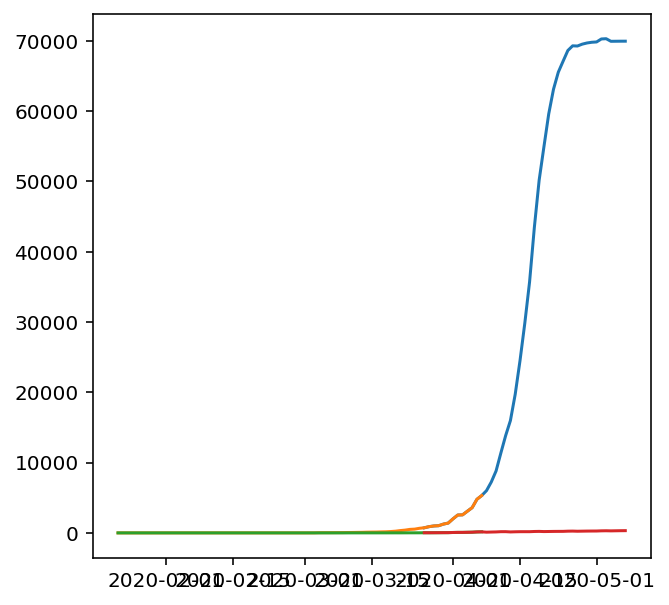

In [56]:
fig = plt.figure(figsize=(5,5))
country='India' # 'Australia'
y1 = train[(train['Country_Region']==country)]['ConfirmedCases']
x1 = train[(train['Country_Region']==country) ]['Date']
y = test_data[(test_data['Country_Region']==country) ]['ConfirmedCases']
x = test_data[(test_data['Country_Region']==country) ]['Date']

plt.plot(x, y)
plt.plot(x1, y1)
plt.plot(x1, train[(train['Country_Region']==country)]['Fatalities'])
plt.plot(x, test_data[(test_data['Country_Region']==country) ]['Fatalities'])
plt.show()

In [ ]:
fig = plt.figure(figsize=(5,5))
y1 = train[(train['Country_Region']=='South')]['ConfirmedCases']
x1 = train[(train['Country_Region']=='India') ]['Date']
y = test_data[(test_data['Country_Region']=='India') ]['ConfirmedCases']
x = test_data[(test_data['Country_Region']=='India') ]['Date']

plt.plot(x, y)
plt.plot(x1, y1)
plt.show()

#####################

In [ ]:
def nn_block(input_layer, size, dropout_rate, activation):
    out_layer = KL.Dense(size, activation=None)(input_layer)
    #out_layer = KL.BatchNormalization()(out_layer)
    out_layer = KL.Activation(activation)(out_layer)
    out_layer = KL.Dropout(dropout_rate)(out_layer)
    return out_layer


def get_model():
    inp = KL.Input(shape=(len(features),))

    hidden_layer = nn_block(inp, 128, 0.0, "relu")
    hidden_layer = nn_block(hidden_layer, 64, 0.0, "relu")
    gate_layer = nn_block(hidden_layer, 32, 0.0, "sigmoid")
    hidden_layer = nn_block(hidden_layer, 48, 0.0, "relu")
    hidden_layer = nn_block(hidden_layer, 32, 0.0, "relu")
    hidden_layer = KL.multiply([hidden_layer, gate_layer])

    out = KL.Dense(len(TARGETS), activation="linear")(hidden_layer)

    model = tf.keras.models.Model(inputs=[inp], outputs=out)
    return model

get_model().summary()

def get_input(df):
    return [df[features]]

NUM_MODELS = 1


def train_models(df, save=False):
    models = []
    for i in range(NUM_MODELS):
        model = get_model()
        model.compile(loss="mean_squared_error", optimizer=Nadam(lr=1e-4))
        hist = model.fit(get_input(df), df[TARGETS],
                         batch_size=2048, epochs=10, callbacks=[EarlyStopping(monitor='val_loss', patience=10)],verbose=1, shuffle=True)
        if save:
            model.save_weights("model{}.h5".format(i))
        models.append(model)
    return models,hist

models,hist = train_models(dev_df)
prev_targets = ['prev_ConfirmedCases_1', 'prev_Fatalities_1']

def predict_one(df, models):
    pred = np.zeros((df.shape[0], 2))
    for model in models:
        pred += model.predict(get_input(df))/len(models)
    pred = np.maximum(pred, df[prev_targets].values)
    pred[:, 0] = np.log1p(np.expm1(pred[:, 0]) + 0.1)
    pred[:, 1] = np.log1p(np.expm1(pred[:, 1]) + 0.01)
    return np.clip(pred, None, 15)

print([mean_squared_error(dev_df[TARGETS[i]], predict_one(dev_df, models)[:, i]) for i in range(len(TARGETS))])
print([mean_squared_error(test_df[TARGETS[i]], predict_one(test_df, models)[:, i]) for i in range(len(TARGETS))])